### Laboratorio 6 - Generative Adversarial Network
Stefano Aragoni, Carol Arévalo

-----------

En esta práctica se diseñó una Generative Adversarial Network (GAN) con el propósito de poder generar imágenes artificiales que imiten la distribución de los datos originales Para esto, fue necesario diseñar una red neuronal que fuera capaz de generar imágenes, y otra red neuronal que fuera capaz de diferenciar entre imágenes reales y generadas. 

A continuación se muestra el código utilizado para la creación de la GAN, así como los resultados obtenidos.

------- 

##### Importar librerías

Como primer paso, se importaron las librerías necesarias para la creación de la GAN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
import tensorflow as tf
from keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
import os
import cv2
from tqdm import tqdm 
import pickle
from keras.preprocessing.image import ImageDataGenerator
import sys

--------
### **Preparación de Datos**

##### Cargar el dataset de CelebA y Preprocesamiento de Datos 

Para iniciar, se descargó el dataset de CelebA. Este conjunto de datos consta de más de 200,000 imágenes a color, de 128 X 128 X 3 c/u. A continuación se muestra la ubicación de las imágenes en el dataset.

In [2]:
# Direcciones de los archivos
fotos_dir = 'archive/img_align_celeba/'
fotos_dir_class = 'archive/img_align_celeba/img_align_celeba/'

# Cantidad de fotos en el directorio
n_fotos = len(os.listdir(fotos_dir_class))
print(n_fotos, "fotos en el directorio")

202599 fotos en el directorio


A través de la librería de Keras, se cargaron las imágenes por batches.

Asimismo, se les aplicó un preprocesamiento, el cual consistió en normalizar los valores de los pixeles de las imágenes, recortarlas y redimensionarlas a 64 X 64 X 3.

In [3]:
# Batch size
batch_size = 100000
# Tamaño de las imágenes
img_size = 64

In [4]:
# Leer las imagenes -> Función recomendada por Prof. Luis Furlan.

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,                    # PRE-PROCESAMIENTO: Normalizar los valores de los pixeles
    horizontal_flip=True,
)

In [5]:
# Carga las imagenes de entrenamiento

train_generator = datagen.flow_from_directory(
    fotos_dir,
    target_size=(img_size, img_size),        # PRE-PROCESAMIENTO: RECORTAR Y REDIMENSIONAR IMÁGENES
    batch_size=batch_size,
    class_mode=None,
    subset='training'
)

Found 202599 images belonging to 1 classes.


(100000, 64, 64, 3)


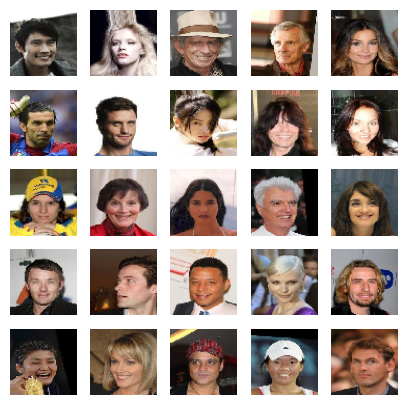

In [6]:
# Mostrar 25 imagenes de entrenamiento

X_train = train_generator[0]
print(X_train.shape)
fig, axs = plt.subplots(5, 5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        img = X_train[i * 5 + j]
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

plt.show()

--------
### **Implementación de la GAN**

##### Diseño del generador y el discriminador

A continuación se demuestra el modelo del <font color=orange>generador</font>. En este caso, se utilizó una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Se encargará de generar imágenes a partir de un vector de ruido.

In [7]:
tamanio_codificacion = 100

img_shape = train_generator[0].shape[1:]
print(img_shape)

(64, 64, 3)


In [8]:
# Generador
generador = Sequential()
generador.add(Dense(8 * 8 * 256, input_shape=[tamanio_codificacion])) 
generador.add(Reshape([8, 8, 256]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))  
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))  
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="sigmoid")) 

A continuación se demuestra el modelo del <font color=orange>discriminador</font>. El discriminador es una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Esta se encarga de diferenciar entre imágenes reales y generadas.

In [9]:
# Discriminador
discriminador = Sequential()
discriminador.add(Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=(64, 64, 3)))
discriminador.add(LeakyReLU(0.3))
discriminador.add(Dropout(0.5))
discriminador.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminador.add(LeakyReLU(0.3))
discriminador.add(Dropout(0.5))
discriminador.add(Flatten())
discriminador.add(Dense(1, activation="sigmoid"))

##### Definición de funciones de pérdida y optimizadores

Con los modelos listos, se procedió a definir las funciones de pérdida y los optimizadores. Esto con el propósito de poder entrenar la GAN. Más específicamente, se utilizó la función de <font color=orange>Binary Cross Entropy</font> (BCE) como función de pérdida, y el <font color=orange>optimizador Adam</font>. 

Asimismo, se indicó que el discriminador no se entrenaría durante el entrenamiento de la GAN, ya que el objetivo es entrenar al generador para que engañe al discriminador.

In [10]:
# Compilar Discriminador
discriminador.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Generador
z = Input(shape=(tamanio_codificacion,))
img = generador(z)

# El discriminador no debe ser entrenado durante el entrenamiento del generador
discriminador.trainable = False

# Discriminador para evaluar el generador
validity = discriminador(img)

# El modelo combinado
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.002, 0.5))

--------
### **Entrenamiento de la GAN**

##### Implementación del bucle de entrenamiento

In [11]:
# Entrenamiento
epochs = 1000
batch_size = 128
half_batch = batch_size // 2

for epoch in tqdm(range(epochs)):
    
    # Entrenar el discriminador
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, tamanio_codificacion))
    gen_imgs = generador.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminador.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminador.train_on_batch(gen_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, tamanio_codificacion))
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_labels)

    # Imprimir el progreso
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 [==============================] - 0s 41ms/step


  0%|          | 1/1000 [00:02<48:47,  2.93s/it]

0/1000 [D loss: 0.8531351089477539 | D accuracy: 46.09375] [G loss: 0.5255825519561768]
2/2 [==============================] - 0s 41ms/step


  0%|          | 2/1000 [00:03<29:52,  1.80s/it]

1/1000 [D loss: 0.7123212814331055 | D accuracy: 50.0] [G loss: 0.5223281383514404]
2/2 [==============================] - 0s 42ms/step


  0%|          | 3/1000 [00:04<23:55,  1.44s/it]

2/1000 [D loss: 0.6991741955280304 | D accuracy: 50.78125] [G loss: 0.513161301612854]
2/2 [==============================] - 0s 43ms/step


  0%|          | 4/1000 [00:05<21:05,  1.27s/it]

3/1000 [D loss: 0.6810057759284973 | D accuracy: 58.59375] [G loss: 0.4953116178512573]
2/2 [==============================] - 0s 42ms/step


  0%|          | 5/1000 [00:06<19:35,  1.18s/it]

4/1000 [D loss: 0.6789706647396088 | D accuracy: 61.71875] [G loss: 0.434276819229126]
2/2 [==============================] - 0s 40ms/step


  1%|          | 6/1000 [00:08<18:43,  1.13s/it]

5/1000 [D loss: 0.6755508482456207 | D accuracy: 63.28125] [G loss: 0.37597572803497314]
2/2 [==============================] - 0s 42ms/step


  1%|          | 7/1000 [00:09<18:08,  1.10s/it]

6/1000 [D loss: 0.671867698431015 | D accuracy: 64.0625] [G loss: 0.32509249448776245]
2/2 [==============================] - 0s 42ms/step


  1%|          | 8/1000 [00:10<17:50,  1.08s/it]

7/1000 [D loss: 0.6562972664833069 | D accuracy: 71.875] [G loss: 0.27328068017959595]
2/2 [==============================] - 0s 43ms/step


  1%|          | 9/1000 [00:11<17:22,  1.05s/it]

8/1000 [D loss: 0.6487480998039246 | D accuracy: 75.78125] [G loss: 0.24428832530975342]
2/2 [==============================] - 0s 43ms/step


  1%|          | 10/1000 [00:12<17:00,  1.03s/it]

9/1000 [D loss: 0.6497951745986938 | D accuracy: 73.4375] [G loss: 0.18729446828365326]
2/2 [==============================] - 0s 42ms/step


  1%|          | 11/1000 [00:13<16:48,  1.02s/it]

10/1000 [D loss: 0.629187136888504 | D accuracy: 82.03125] [G loss: 0.15272672474384308]
2/2 [==============================] - 0s 40ms/step


  1%|          | 12/1000 [00:14<16:41,  1.01s/it]

11/1000 [D loss: 0.6175160109996796 | D accuracy: 81.25] [G loss: 0.13040420413017273]
2/2 [==============================] - 0s 39ms/step


  1%|▏         | 13/1000 [00:15<16:36,  1.01s/it]

12/1000 [D loss: 0.63399738073349 | D accuracy: 75.0] [G loss: 0.10345934331417084]
2/2 [==============================] - 0s 40ms/step


  1%|▏         | 14/1000 [00:16<16:32,  1.01s/it]

13/1000 [D loss: 0.6279975175857544 | D accuracy: 80.46875] [G loss: 0.0846499651670456]
2/2 [==============================] - 0s 43ms/step


  2%|▏         | 15/1000 [00:17<16:31,  1.01s/it]

14/1000 [D loss: 0.5992226302623749 | D accuracy: 84.375] [G loss: 0.0667872428894043]
2/2 [==============================] - 0s 39ms/step


  2%|▏         | 16/1000 [00:18<16:27,  1.00s/it]

15/1000 [D loss: 0.5952891111373901 | D accuracy: 81.25] [G loss: 0.05391710251569748]
2/2 [==============================] - 0s 43ms/step


  2%|▏         | 17/1000 [00:19<16:25,  1.00s/it]

16/1000 [D loss: 0.6015395820140839 | D accuracy: 83.59375] [G loss: 0.0429171659052372]
2/2 [==============================] - 0s 38ms/step


  2%|▏         | 18/1000 [00:20<16:23,  1.00s/it]

17/1000 [D loss: 0.611724853515625 | D accuracy: 81.25] [G loss: 0.03262724727392197]
2/2 [==============================] - 0s 43ms/step


  2%|▏         | 19/1000 [00:21<16:28,  1.01s/it]

18/1000 [D loss: 0.5942611992359161 | D accuracy: 81.25] [G loss: 0.02712758630514145]
2/2 [==============================] - 0s 54ms/step


  2%|▏         | 20/1000 [00:22<16:31,  1.01s/it]

19/1000 [D loss: 0.5973381400108337 | D accuracy: 82.03125] [G loss: 0.022472448647022247]
2/2 [==============================] - 0s 41ms/step


  2%|▏         | 21/1000 [00:23<16:27,  1.01s/it]

20/1000 [D loss: 0.6178362965583801 | D accuracy: 78.90625] [G loss: 0.018101483583450317]
2/2 [==============================] - 0s 44ms/step


  2%|▏         | 22/1000 [00:24<16:27,  1.01s/it]

21/1000 [D loss: 0.6004558503627777 | D accuracy: 82.03125] [G loss: 0.014573534950613976]
2/2 [==============================] - 0s 42ms/step


  2%|▏         | 23/1000 [00:25<16:30,  1.01s/it]

22/1000 [D loss: 0.6147855818271637 | D accuracy: 80.46875] [G loss: 0.012151896953582764]
2/2 [==============================] - 0s 40ms/step


  2%|▏         | 24/1000 [00:26<16:31,  1.02s/it]

23/1000 [D loss: 0.5933164060115814 | D accuracy: 79.6875] [G loss: 0.010880108922719955]
2/2 [==============================] - 0s 44ms/step


  2%|▎         | 25/1000 [00:27<16:33,  1.02s/it]

24/1000 [D loss: 0.586842268705368 | D accuracy: 79.6875] [G loss: 0.008894864469766617]
2/2 [==============================] - 0s 42ms/step


  3%|▎         | 26/1000 [00:28<16:32,  1.02s/it]

25/1000 [D loss: 0.6392982602119446 | D accuracy: 75.78125] [G loss: 0.0076148053631186485]
2/2 [==============================] - 0s 43ms/step


  3%|▎         | 27/1000 [00:29<16:33,  1.02s/it]

26/1000 [D loss: 0.6049342155456543 | D accuracy: 77.34375] [G loss: 0.006911393254995346]
2/2 [==============================] - 0s 46ms/step


  3%|▎         | 28/1000 [00:30<16:33,  1.02s/it]

27/1000 [D loss: 0.581628829240799 | D accuracy: 80.46875] [G loss: 0.005836908705532551]
2/2 [==============================] - 0s 45ms/step


  3%|▎         | 29/1000 [00:31<16:35,  1.02s/it]

28/1000 [D loss: 0.5334497094154358 | D accuracy: 88.28125] [G loss: 0.005821339786052704]
2/2 [==============================] - 0s 43ms/step


  3%|▎         | 30/1000 [00:32<16:37,  1.03s/it]

29/1000 [D loss: 0.5502330362796783 | D accuracy: 79.6875] [G loss: 0.004561412148177624]
2/2 [==============================] - 0s 41ms/step


  3%|▎         | 31/1000 [00:33<16:34,  1.03s/it]

30/1000 [D loss: 0.5299123525619507 | D accuracy: 84.375] [G loss: 0.0038944222033023834]
2/2 [==============================] - 0s 43ms/step


  3%|▎         | 32/1000 [00:34<16:37,  1.03s/it]

31/1000 [D loss: 0.4968518316745758 | D accuracy: 88.28125] [G loss: 0.003107313998043537]
2/2 [==============================] - 0s 43ms/step


  3%|▎         | 33/1000 [00:35<16:36,  1.03s/it]

32/1000 [D loss: 0.5398121178150177 | D accuracy: 86.71875] [G loss: 0.0024859036784619093]
2/2 [==============================] - 0s 42ms/step


  3%|▎         | 34/1000 [00:36<16:32,  1.03s/it]

33/1000 [D loss: 0.4534493237733841 | D accuracy: 92.1875] [G loss: 0.0020509150344878435]
2/2 [==============================] - 0s 45ms/step


  4%|▎         | 35/1000 [00:37<16:34,  1.03s/it]

34/1000 [D loss: 0.5424018502235413 | D accuracy: 83.59375] [G loss: 0.0013521896908059716]
2/2 [==============================] - 0s 44ms/step


  4%|▎         | 36/1000 [00:38<16:34,  1.03s/it]

35/1000 [D loss: 0.487664133310318 | D accuracy: 86.71875] [G loss: 0.0012687179259955883]
2/2 [==============================] - 0s 42ms/step


  4%|▎         | 37/1000 [00:39<16:33,  1.03s/it]

36/1000 [D loss: 0.37986525893211365 | D accuracy: 91.40625] [G loss: 0.0009486691560596228]
2/2 [==============================] - 0s 43ms/step


  4%|▍         | 38/1000 [00:40<16:38,  1.04s/it]

37/1000 [D loss: 0.4115554392337799 | D accuracy: 89.0625] [G loss: 0.0005149139324203134]
2/2 [==============================] - 0s 42ms/step


  4%|▍         | 39/1000 [00:41<16:34,  1.04s/it]

38/1000 [D loss: 0.3535454571247101 | D accuracy: 92.96875] [G loss: 0.0003550979890860617]
2/2 [==============================] - 0s 46ms/step


  4%|▍         | 40/1000 [00:42<16:35,  1.04s/it]

39/1000 [D loss: 0.3384758085012436 | D accuracy: 93.75] [G loss: 0.0001985799754038453]
2/2 [==============================] - 0s 46ms/step


  4%|▍         | 41/1000 [00:43<16:34,  1.04s/it]

40/1000 [D loss: 0.3265904039144516 | D accuracy: 91.40625] [G loss: 0.00013147661229595542]
2/2 [==============================] - 0s 44ms/step


  4%|▍         | 42/1000 [00:44<16:34,  1.04s/it]

41/1000 [D loss: 0.3039623498916626 | D accuracy: 94.53125] [G loss: 6.222590309334919e-05]
2/2 [==============================] - 0s 43ms/step


  4%|▍         | 43/1000 [00:45<16:37,  1.04s/it]

42/1000 [D loss: 0.2296084612607956 | D accuracy: 96.09375] [G loss: 4.607027585734613e-05]
2/2 [==============================] - 0s 44ms/step


  4%|▍         | 44/1000 [00:46<16:37,  1.04s/it]

43/1000 [D loss: 0.24842305481433868 | D accuracy: 93.75] [G loss: 1.9968778360635042e-05]
2/2 [==============================] - 0s 43ms/step


  4%|▍         | 45/1000 [00:47<16:36,  1.04s/it]

44/1000 [D loss: 0.11836894601583481 | D accuracy: 100.0] [G loss: 2.199252412538044e-05]
2/2 [==============================] - 0s 48ms/step


  5%|▍         | 46/1000 [00:48<16:40,  1.05s/it]

45/1000 [D loss: 0.17338906973600388 | D accuracy: 96.09375] [G loss: 8.096914825728163e-06]
2/2 [==============================] - 0s 44ms/step


  5%|▍         | 47/1000 [00:49<16:40,  1.05s/it]

46/1000 [D loss: 0.12034697458148003 | D accuracy: 98.4375] [G loss: 4.224533768137917e-06]
2/2 [==============================] - 0s 45ms/step


  5%|▍         | 48/1000 [00:51<16:39,  1.05s/it]

47/1000 [D loss: 0.09865633025765419 | D accuracy: 98.4375] [G loss: 3.0432045150519116e-06]
2/2 [==============================] - 0s 43ms/step


  5%|▍         | 49/1000 [00:52<16:36,  1.05s/it]

48/1000 [D loss: 0.10912782698869705 | D accuracy: 97.65625] [G loss: 8.313595003528462e-07]
2/2 [==============================] - 0s 44ms/step


  5%|▌         | 50/1000 [00:53<16:32,  1.05s/it]

49/1000 [D loss: 0.06649844720959663 | D accuracy: 99.21875] [G loss: 6.178804596856935e-07]
2/2 [==============================] - 0s 44ms/step


  5%|▌         | 51/1000 [00:54<16:35,  1.05s/it]

50/1000 [D loss: 0.05567707493901253 | D accuracy: 99.21875] [G loss: 3.7635595617757645e-07]
2/2 [==============================] - 0s 43ms/step


  5%|▌         | 52/1000 [00:55<16:35,  1.05s/it]

51/1000 [D loss: 0.035152141004800797 | D accuracy: 100.0] [G loss: 2.2118996412245906e-07]
2/2 [==============================] - 0s 45ms/step


  5%|▌         | 53/1000 [00:56<16:34,  1.05s/it]

52/1000 [D loss: 0.05492488667368889 | D accuracy: 99.21875] [G loss: 1.4063721209822688e-07]
2/2 [==============================] - 0s 46ms/step


  5%|▌         | 54/1000 [00:57<16:36,  1.05s/it]

53/1000 [D loss: 0.037528617307543755 | D accuracy: 100.0] [G loss: 1.587349771625668e-07]
2/2 [==============================] - 0s 44ms/step


  6%|▌         | 55/1000 [00:58<16:37,  1.06s/it]

54/1000 [D loss: 0.04310631565749645 | D accuracy: 99.21875] [G loss: 1.1511788500229159e-07]
2/2 [==============================] - 0s 44ms/step


  6%|▌         | 56/1000 [00:59<16:33,  1.05s/it]

55/1000 [D loss: 0.02643713168799877 | D accuracy: 100.0] [G loss: 5.6527625247326796e-08]
2/2 [==============================] - 0s 43ms/step


  6%|▌         | 57/1000 [01:00<16:33,  1.05s/it]

56/1000 [D loss: 0.013491732999682426 | D accuracy: 100.0] [G loss: 8.317746846842056e-08]
2/2 [==============================] - 0s 43ms/step


  6%|▌         | 58/1000 [01:01<16:35,  1.06s/it]

57/1000 [D loss: 0.014748155139386654 | D accuracy: 100.0] [G loss: 2.9467960516171843e-08]
2/2 [==============================] - 0s 42ms/step


  6%|▌         | 59/1000 [01:02<16:39,  1.06s/it]

58/1000 [D loss: 0.009579307399690151 | D accuracy: 100.0] [G loss: 3.032782558420877e-08]
2/2 [==============================] - 0s 43ms/step


  6%|▌         | 60/1000 [01:03<16:35,  1.06s/it]

59/1000 [D loss: 0.03408363973721862 | D accuracy: 99.21875] [G loss: 1.577681274511633e-08]
2/2 [==============================] - 0s 47ms/step


  6%|▌         | 61/1000 [01:04<16:35,  1.06s/it]

60/1000 [D loss: 0.008892673766240478 | D accuracy: 100.0] [G loss: 1.7833079013485076e-08]
2/2 [==============================] - 0s 48ms/step


  6%|▌         | 62/1000 [01:05<16:35,  1.06s/it]

61/1000 [D loss: 0.007072621025145054 | D accuracy: 100.0] [G loss: 1.3625358619151484e-08]
2/2 [==============================] - 0s 47ms/step


  6%|▋         | 63/1000 [01:06<16:35,  1.06s/it]

62/1000 [D loss: 0.02090328186750412 | D accuracy: 99.21875] [G loss: 7.519224354268772e-09]
2/2 [==============================] - 0s 45ms/step


  6%|▋         | 64/1000 [01:07<16:36,  1.07s/it]

63/1000 [D loss: 0.005022127414122224 | D accuracy: 100.0] [G loss: 1.5370638095646427e-08]
2/2 [==============================] - 0s 52ms/step


  6%|▋         | 65/1000 [01:09<16:39,  1.07s/it]

64/1000 [D loss: 0.004771867184899747 | D accuracy: 100.0] [G loss: 5.648742806840801e-09]
2/2 [==============================] - 0s 43ms/step


  7%|▋         | 66/1000 [01:10<16:38,  1.07s/it]

65/1000 [D loss: 0.0032809716649353504 | D accuracy: 100.0] [G loss: 1.1048497228216547e-08]
2/2 [==============================] - 0s 47ms/step


  7%|▋         | 67/1000 [01:11<16:35,  1.07s/it]

66/1000 [D loss: 0.0028112827567383647 | D accuracy: 100.0] [G loss: 1.1049597681278556e-08]
2/2 [==============================] - 0s 42ms/step


  7%|▋         | 68/1000 [01:12<16:35,  1.07s/it]

67/1000 [D loss: 0.0029744900530204177 | D accuracy: 100.0] [G loss: 4.8924251316861955e-09]
2/2 [==============================] - 0s 41ms/step


  7%|▋         | 69/1000 [01:13<16:36,  1.07s/it]

68/1000 [D loss: 0.0038911309093236923 | D accuracy: 100.0] [G loss: 7.062986639994051e-09]
2/2 [==============================] - 0s 44ms/step


  7%|▋         | 70/1000 [01:14<16:33,  1.07s/it]

69/1000 [D loss: 0.00405494193546474 | D accuracy: 100.0] [G loss: 6.81985223849324e-09]
2/2 [==============================] - 0s 45ms/step


  7%|▋         | 71/1000 [01:15<16:30,  1.07s/it]

70/1000 [D loss: 0.0037518267054110765 | D accuracy: 100.0] [G loss: 3.992434827182478e-09]
2/2 [==============================] - 0s 44ms/step


  7%|▋         | 72/1000 [01:16<16:29,  1.07s/it]

71/1000 [D loss: 0.0020426501287147403 | D accuracy: 100.0] [G loss: 3.9564600484709445e-09]
2/2 [==============================] - 0s 45ms/step


  7%|▋         | 73/1000 [01:17<16:29,  1.07s/it]

72/1000 [D loss: 0.002473963890224695 | D accuracy: 100.0] [G loss: 7.339884700030552e-09]
2/2 [==============================] - 0s 42ms/step


  7%|▋         | 74/1000 [01:18<16:24,  1.06s/it]

73/1000 [D loss: 0.019475006381981075 | D accuracy: 99.21875] [G loss: 4.423599264669065e-09]
2/2 [==============================] - 0s 43ms/step


  8%|▊         | 75/1000 [01:19<16:24,  1.06s/it]

74/1000 [D loss: 0.001495851029176265 | D accuracy: 100.0] [G loss: 1.9299393194671666e-09]
2/2 [==============================] - 0s 46ms/step


  8%|▊         | 76/1000 [01:20<16:25,  1.07s/it]

75/1000 [D loss: 0.005031546927057207 | D accuracy: 100.0] [G loss: 1.2811862681871844e-09]
2/2 [==============================] - 0s 47ms/step


  8%|▊         | 77/1000 [01:21<16:22,  1.06s/it]

76/1000 [D loss: 0.001441852713469416 | D accuracy: 100.0] [G loss: 7.85061460284453e-10]
2/2 [==============================] - 0s 47ms/step


  8%|▊         | 78/1000 [01:22<16:22,  1.07s/it]

77/1000 [D loss: 0.001319809292908758 | D accuracy: 100.0] [G loss: 1.1762703033824096e-09]
2/2 [==============================] - 0s 43ms/step


  8%|▊         | 79/1000 [01:23<16:22,  1.07s/it]

78/1000 [D loss: 0.0013325040927156806 | D accuracy: 100.0] [G loss: 2.3579211916313625e-09]
2/2 [==============================] - 0s 43ms/step


  8%|▊         | 80/1000 [01:25<16:21,  1.07s/it]

79/1000 [D loss: 0.001168915128801018 | D accuracy: 100.0] [G loss: 4.598805336542e-09]
2/2 [==============================] - 0s 41ms/step


  8%|▊         | 81/1000 [01:26<16:12,  1.06s/it]

80/1000 [D loss: 0.0015008849441073835 | D accuracy: 100.0] [G loss: 5.620158227692684e-10]
2/2 [==============================] - 0s 44ms/step


  8%|▊         | 82/1000 [01:27<16:14,  1.06s/it]

81/1000 [D loss: 0.0025559584610164165 | D accuracy: 100.0] [G loss: 5.973236572032192e-09]
2/2 [==============================] - 0s 45ms/step


  8%|▊         | 83/1000 [01:28<16:18,  1.07s/it]

82/1000 [D loss: 0.012048191507346928 | D accuracy: 99.21875] [G loss: 1.7561512244412825e-09]
2/2 [==============================] - 0s 44ms/step


  8%|▊         | 84/1000 [01:29<16:17,  1.07s/it]

83/1000 [D loss: 0.001179651531856507 | D accuracy: 100.0] [G loss: 8.548883823067399e-10]
2/2 [==============================] - 0s 45ms/step


  8%|▊         | 85/1000 [01:30<16:13,  1.06s/it]

84/1000 [D loss: 0.001628478232305497 | D accuracy: 100.0] [G loss: 3.3508218422184655e-10]
2/2 [==============================] - 0s 46ms/step


  9%|▊         | 86/1000 [01:31<16:10,  1.06s/it]

85/1000 [D loss: 0.000749205268220976 | D accuracy: 100.0] [G loss: 5.590824470047551e-10]
2/2 [==============================] - 0s 42ms/step


  9%|▊         | 87/1000 [01:32<16:04,  1.06s/it]

86/1000 [D loss: 0.0007558810757473111 | D accuracy: 100.0] [G loss: 4.4548015276646424e-10]
2/2 [==============================] - 0s 45ms/step


  9%|▉         | 88/1000 [01:33<16:07,  1.06s/it]

87/1000 [D loss: 0.0007419979083351791 | D accuracy: 100.0] [G loss: 3.315808461135106e-10]
2/2 [==============================] - 0s 45ms/step


  9%|▉         | 89/1000 [01:34<16:04,  1.06s/it]

88/1000 [D loss: 0.006185945559991524 | D accuracy: 100.0] [G loss: 4.967067868122399e-10]
2/2 [==============================] - 0s 45ms/step


  9%|▉         | 90/1000 [01:35<16:02,  1.06s/it]

89/1000 [D loss: 0.0005067078745923936 | D accuracy: 100.0] [G loss: 1.2251585856937197e-10]
2/2 [==============================] - 0s 47ms/step


  9%|▉         | 91/1000 [01:36<16:01,  1.06s/it]

90/1000 [D loss: 0.0017582084401510656 | D accuracy: 100.0] [G loss: 1.7307050237391763e-10]
2/2 [==============================] - 0s 46ms/step


  9%|▉         | 92/1000 [01:37<16:00,  1.06s/it]

91/1000 [D loss: 0.0027171972033102065 | D accuracy: 100.0] [G loss: 3.9360581460812227e-10]
2/2 [==============================] - 0s 47ms/step


  9%|▉         | 93/1000 [01:38<16:08,  1.07s/it]

92/1000 [D loss: 0.0005414296501839999 | D accuracy: 100.0] [G loss: 6.556341025643064e-10]
2/2 [==============================] - 0s 45ms/step


  9%|▉         | 94/1000 [01:39<16:04,  1.06s/it]

93/1000 [D loss: 0.00045435437641572207 | D accuracy: 100.0] [G loss: 6.942492414285795e-11]
2/2 [==============================] - 0s 43ms/step


 10%|▉         | 95/1000 [01:40<16:02,  1.06s/it]

94/1000 [D loss: 0.0004884008958470076 | D accuracy: 100.0] [G loss: 3.7437866695633204e-10]
2/2 [==============================] - 0s 47ms/step


 10%|▉         | 96/1000 [01:42<16:01,  1.06s/it]

95/1000 [D loss: 0.0004285242030164227 | D accuracy: 100.0] [G loss: 1.6464732355281342e-10]
2/2 [==============================] - 0s 43ms/step


 10%|▉         | 97/1000 [01:43<15:58,  1.06s/it]

96/1000 [D loss: 0.00034208210126962513 | D accuracy: 100.0] [G loss: 9.212303836436675e-11]
2/2 [==============================] - 0s 45ms/step


 10%|▉         | 98/1000 [01:44<15:57,  1.06s/it]

97/1000 [D loss: 0.00042313562880735844 | D accuracy: 100.0] [G loss: 1.813662553473705e-10]
2/2 [==============================] - 0s 47ms/step


 10%|▉         | 99/1000 [01:45<15:56,  1.06s/it]

98/1000 [D loss: 0.0004102436651010066 | D accuracy: 100.0] [G loss: 1.462424348286362e-10]
2/2 [==============================] - 0s 53ms/step


 10%|█         | 100/1000 [01:46<15:58,  1.06s/it]

99/1000 [D loss: 0.0003123404167126864 | D accuracy: 100.0] [G loss: 1.9234347448104927e-10]
2/2 [==============================] - 0s 45ms/step


 10%|█         | 101/1000 [01:47<15:57,  1.07s/it]

100/1000 [D loss: 0.00026465072005521506 | D accuracy: 100.0] [G loss: 2.116327946222185e-10]
2/2 [==============================] - 0s 44ms/step


 10%|█         | 102/1000 [01:48<15:55,  1.06s/it]

101/1000 [D loss: 0.00034114939626306295 | D accuracy: 100.0] [G loss: 8.929639666588329e-11]
2/2 [==============================] - 0s 47ms/step


 10%|█         | 103/1000 [01:49<15:53,  1.06s/it]

102/1000 [D loss: 0.0019671957998070866 | D accuracy: 100.0] [G loss: 4.2076692130521565e-10]
2/2 [==============================] - 0s 43ms/step


 10%|█         | 104/1000 [01:50<15:52,  1.06s/it]

103/1000 [D loss: 0.0037655892374459654 | D accuracy: 100.0] [G loss: 3.2633262758707815e-10]
2/2 [==============================] - 0s 48ms/step


 10%|█         | 105/1000 [01:51<15:52,  1.06s/it]

104/1000 [D loss: 0.0003481911262497306 | D accuracy: 100.0] [G loss: 8.358820580145476e-11]
2/2 [==============================] - 0s 48ms/step


 11%|█         | 106/1000 [01:52<15:51,  1.06s/it]

105/1000 [D loss: 0.00023157953910413198 | D accuracy: 100.0] [G loss: 1.116146619573044e-10]
2/2 [==============================] - 0s 43ms/step


 11%|█         | 107/1000 [01:53<15:48,  1.06s/it]

106/1000 [D loss: 0.00024352269247174263 | D accuracy: 100.0] [G loss: 1.352605805138296e-10]
2/2 [==============================] - 0s 47ms/step


 11%|█         | 108/1000 [01:54<15:45,  1.06s/it]

107/1000 [D loss: 0.00023316071383305825 | D accuracy: 100.0] [G loss: 2.774601659538689e-10]
2/2 [==============================] - 0s 46ms/step


 11%|█         | 109/1000 [01:55<15:46,  1.06s/it]

108/1000 [D loss: 0.0002013165649259463 | D accuracy: 100.0] [G loss: 1.333942400982835e-10]
2/2 [==============================] - 0s 43ms/step


 11%|█         | 110/1000 [01:56<15:45,  1.06s/it]

109/1000 [D loss: 0.00024169038806576282 | D accuracy: 100.0] [G loss: 1.0066978500811175e-10]
2/2 [==============================] - 0s 43ms/step


 11%|█         | 111/1000 [01:57<15:43,  1.06s/it]

110/1000 [D loss: 0.0001910340433823876 | D accuracy: 100.0] [G loss: 1.4440271201010546e-10]
2/2 [==============================] - 0s 46ms/step


 11%|█         | 112/1000 [01:59<15:44,  1.06s/it]

111/1000 [D loss: 0.00014743067367817275 | D accuracy: 100.0] [G loss: 9.399950262611867e-11]
2/2 [==============================] - 0s 46ms/step


 11%|█▏        | 113/1000 [02:00<15:45,  1.07s/it]

112/1000 [D loss: 0.00025797131820581853 | D accuracy: 100.0] [G loss: 1.3812276322688888e-10]
2/2 [==============================] - 0s 44ms/step


 11%|█▏        | 114/1000 [02:01<15:45,  1.07s/it]

113/1000 [D loss: 0.00014687269140267745 | D accuracy: 100.0] [G loss: 2.3669255444502824e-10]
2/2 [==============================] - 0s 46ms/step


 12%|█▏        | 115/1000 [02:02<15:50,  1.07s/it]

114/1000 [D loss: 0.00017587977345101535 | D accuracy: 100.0] [G loss: 7.49044229420015e-11]
2/2 [==============================] - 0s 47ms/step


 12%|█▏        | 116/1000 [02:03<15:47,  1.07s/it]

115/1000 [D loss: 0.00032987007580231875 | D accuracy: 100.0] [G loss: 1.1592311138786116e-10]
2/2 [==============================] - 0s 48ms/step


 12%|█▏        | 117/1000 [02:04<15:45,  1.07s/it]

116/1000 [D loss: 0.00011284333231742494 | D accuracy: 100.0] [G loss: 1.1480390249563044e-10]
2/2 [==============================] - 0s 45ms/step


 12%|█▏        | 118/1000 [02:05<15:43,  1.07s/it]

117/1000 [D loss: 0.00017803941591409966 | D accuracy: 100.0] [G loss: 8.14529069192993e-11]
2/2 [==============================] - 0s 46ms/step


 12%|█▏        | 119/1000 [02:06<15:42,  1.07s/it]

118/1000 [D loss: 0.0001315748377237469 | D accuracy: 100.0] [G loss: 2.4975391199610897e-10]
2/2 [==============================] - 0s 52ms/step


 12%|█▏        | 120/1000 [02:07<15:41,  1.07s/it]

119/1000 [D loss: 0.0006449730281019583 | D accuracy: 100.0] [G loss: 1.4217496624446824e-10]
2/2 [==============================] - 0s 46ms/step


 12%|█▏        | 121/1000 [02:08<15:34,  1.06s/it]

120/1000 [D loss: 0.00013271867646835744 | D accuracy: 100.0] [G loss: 1.7465820456585845e-10]
2/2 [==============================] - 0s 44ms/step


 12%|█▏        | 122/1000 [02:09<15:35,  1.07s/it]

121/1000 [D loss: 0.00011204948168597184 | D accuracy: 100.0] [G loss: 5.82556017314495e-11]
2/2 [==============================] - 0s 45ms/step


 12%|█▏        | 123/1000 [02:10<15:37,  1.07s/it]

122/1000 [D loss: 0.00029389526753220707 | D accuracy: 100.0] [G loss: 6.791447959564323e-11]
2/2 [==============================] - 0s 46ms/step


 12%|█▏        | 124/1000 [02:11<15:38,  1.07s/it]

123/1000 [D loss: 7.957947309478186e-05 | D accuracy: 100.0] [G loss: 5.212349649119652e-11]
2/2 [==============================] - 0s 46ms/step


 12%|█▎        | 125/1000 [02:12<15:37,  1.07s/it]

124/1000 [D loss: 0.00014642362657468766 | D accuracy: 100.0] [G loss: 5.018361420860984e-11]
2/2 [==============================] - 0s 46ms/step


 13%|█▎        | 126/1000 [02:14<15:33,  1.07s/it]

125/1000 [D loss: 0.00020066489378223196 | D accuracy: 100.0] [G loss: 1.3213719007865166e-10]
2/2 [==============================] - 0s 45ms/step


 13%|█▎        | 127/1000 [02:15<15:34,  1.07s/it]

126/1000 [D loss: 0.00017566206952324137 | D accuracy: 100.0] [G loss: 5.5310294538868376e-11]
2/2 [==============================] - 0s 42ms/step


 13%|█▎        | 128/1000 [02:16<15:33,  1.07s/it]

127/1000 [D loss: 0.0002806399279506877 | D accuracy: 100.0] [G loss: 8.390546590852921e-11]
2/2 [==============================] - 0s 44ms/step


 13%|█▎        | 129/1000 [02:17<15:33,  1.07s/it]

128/1000 [D loss: 0.00016696678358130157 | D accuracy: 100.0] [G loss: 2.501506779495344e-10]
2/2 [==============================] - 0s 50ms/step


 13%|█▎        | 130/1000 [02:18<15:30,  1.07s/it]

129/1000 [D loss: 0.00013048297114437446 | D accuracy: 100.0] [G loss: 5.929019775141597e-11]
2/2 [==============================] - 0s 45ms/step


 13%|█▎        | 131/1000 [02:19<15:35,  1.08s/it]

130/1000 [D loss: 0.000303097753203474 | D accuracy: 100.0] [G loss: 6.25367951867517e-11]
2/2 [==============================] - 0s 48ms/step


 13%|█▎        | 132/1000 [02:20<15:33,  1.08s/it]

131/1000 [D loss: 0.001026595949952025 | D accuracy: 100.0] [G loss: 5.44223797971366e-11]
2/2 [==============================] - 0s 49ms/step


 13%|█▎        | 133/1000 [02:21<15:31,  1.07s/it]

132/1000 [D loss: 0.0001898991467896849 | D accuracy: 100.0] [G loss: 3.73787771568157e-11]
2/2 [==============================] - 0s 44ms/step


 13%|█▎        | 134/1000 [02:22<15:29,  1.07s/it]

133/1000 [D loss: 0.000402664936700603 | D accuracy: 100.0] [G loss: 6.5534876136919e-11]
2/2 [==============================] - 0s 54ms/step


 14%|█▎        | 135/1000 [02:23<15:29,  1.07s/it]

134/1000 [D loss: 7.305641884158831e-05 | D accuracy: 100.0] [G loss: 2.0012073942421438e-10]
2/2 [==============================] - 0s 45ms/step


 14%|█▎        | 136/1000 [02:24<15:30,  1.08s/it]

135/1000 [D loss: 6.756703805876896e-05 | D accuracy: 100.0] [G loss: 4.701910041871038e-11]
2/2 [==============================] - 0s 47ms/step


 14%|█▎        | 137/1000 [02:25<15:25,  1.07s/it]

136/1000 [D loss: 0.0003547683445503935 | D accuracy: 100.0] [G loss: 6.532801383185571e-11]
2/2 [==============================] - 0s 46ms/step


 14%|█▍        | 138/1000 [02:26<15:27,  1.08s/it]

137/1000 [D loss: 8.815922774374485e-05 | D accuracy: 100.0] [G loss: 3.428630990232051e-11]
2/2 [==============================] - 0s 51ms/step


 14%|█▍        | 139/1000 [02:27<15:24,  1.07s/it]

138/1000 [D loss: 0.0001710886717773974 | D accuracy: 100.0] [G loss: 4.25700377726379e-11]
2/2 [==============================] - 0s 46ms/step


 14%|█▍        | 140/1000 [02:29<15:26,  1.08s/it]

139/1000 [D loss: 0.00010278692934662104 | D accuracy: 100.0] [G loss: 3.157999556302471e-11]
2/2 [==============================] - 0s 51ms/step


 14%|█▍        | 141/1000 [02:30<15:23,  1.08s/it]

140/1000 [D loss: 9.735359344631433e-05 | D accuracy: 100.0] [G loss: 8.236955562068715e-11]
2/2 [==============================] - 0s 47ms/step


 14%|█▍        | 142/1000 [02:31<15:21,  1.07s/it]

141/1000 [D loss: 6.49934881948866e-05 | D accuracy: 100.0] [G loss: 2.914223723449183e-11]
2/2 [==============================] - 0s 46ms/step


 14%|█▍        | 143/1000 [02:32<15:20,  1.07s/it]

142/1000 [D loss: 0.00014853370885248296 | D accuracy: 100.0] [G loss: 5.0877899115953085e-11]
2/2 [==============================] - 0s 46ms/step


 14%|█▍        | 144/1000 [02:33<15:18,  1.07s/it]

143/1000 [D loss: 0.0001540869998279959 | D accuracy: 100.0] [G loss: 2.890715271319788e-11]
2/2 [==============================] - 0s 52ms/step


 14%|█▍        | 145/1000 [02:34<15:18,  1.07s/it]

144/1000 [D loss: 6.639760977122933e-05 | D accuracy: 100.0] [G loss: 1.0313623566293728e-10]
2/2 [==============================] - 0s 44ms/step


 15%|█▍        | 146/1000 [02:35<15:15,  1.07s/it]

145/1000 [D loss: 0.00013686194870388135 | D accuracy: 100.0] [G loss: 2.993967920805751e-11]
2/2 [==============================] - 0s 45ms/step


 15%|█▍        | 147/1000 [02:36<15:19,  1.08s/it]

146/1000 [D loss: 6.99411266396055e-05 | D accuracy: 100.0] [G loss: 7.650546862691954e-11]
2/2 [==============================] - 0s 45ms/step


 15%|█▍        | 148/1000 [02:37<15:18,  1.08s/it]

147/1000 [D loss: 0.0001781194150680676 | D accuracy: 100.0] [G loss: 1.2758319400951734e-10]
2/2 [==============================] - 0s 42ms/step


 15%|█▍        | 149/1000 [02:38<15:16,  1.08s/it]

148/1000 [D loss: 5.579962453339249e-05 | D accuracy: 100.0] [G loss: 1.8497514631121703e-10]
2/2 [==============================] - 0s 48ms/step


 15%|█▌        | 150/1000 [02:39<15:14,  1.08s/it]

149/1000 [D loss: 9.654724271968007e-05 | D accuracy: 100.0] [G loss: 2.957575503947929e-11]
2/2 [==============================] - 0s 49ms/step


 15%|█▌        | 151/1000 [02:40<15:13,  1.08s/it]

150/1000 [D loss: 5.0984481276827864e-05 | D accuracy: 100.0] [G loss: 3.085730629348582e-11]
2/2 [==============================] - 0s 45ms/step


 15%|█▌        | 152/1000 [02:41<15:13,  1.08s/it]

151/1000 [D loss: 4.8749296183814295e-05 | D accuracy: 100.0] [G loss: 6.884488118474863e-11]
2/2 [==============================] - 0s 45ms/step


 15%|█▌        | 153/1000 [02:43<15:13,  1.08s/it]

152/1000 [D loss: 9.346920705866069e-05 | D accuracy: 100.0] [G loss: 3.5086135385942185e-11]
2/2 [==============================] - 0s 45ms/step


 15%|█▌        | 154/1000 [02:44<15:12,  1.08s/it]

153/1000 [D loss: 0.0016185931526706554 | D accuracy: 100.0] [G loss: 1.0050656140681014e-10]
2/2 [==============================] - 0s 49ms/step


 16%|█▌        | 155/1000 [02:45<15:10,  1.08s/it]

154/1000 [D loss: 0.00012109092131140642 | D accuracy: 100.0] [G loss: 3.85736997898789e-11]
2/2 [==============================] - 0s 50ms/step


 16%|█▌        | 156/1000 [02:46<15:08,  1.08s/it]

155/1000 [D loss: 0.00013947564730187878 | D accuracy: 100.0] [G loss: 5.286242277247055e-11]
2/2 [==============================] - 0s 47ms/step


 16%|█▌        | 157/1000 [02:47<15:08,  1.08s/it]

156/1000 [D loss: 0.0017278387203987222 | D accuracy: 100.0] [G loss: 8.975080401096847e-11]
2/2 [==============================] - 0s 50ms/step


 16%|█▌        | 158/1000 [02:48<15:08,  1.08s/it]

157/1000 [D loss: 0.00010035989544121549 | D accuracy: 100.0] [G loss: 7.182433120478393e-11]
2/2 [==============================] - 0s 52ms/step


 16%|█▌        | 159/1000 [02:49<15:06,  1.08s/it]

158/1000 [D loss: 0.0001438340696040541 | D accuracy: 100.0] [G loss: 3.730920780653513e-11]
2/2 [==============================] - 0s 48ms/step


 16%|█▌        | 160/1000 [02:50<15:04,  1.08s/it]

159/1000 [D loss: 0.0003624430210038554 | D accuracy: 100.0] [G loss: 9.915107623825747e-11]
2/2 [==============================] - 0s 44ms/step


 16%|█▌        | 161/1000 [02:51<15:05,  1.08s/it]

160/1000 [D loss: 0.0003002266130351927 | D accuracy: 100.0] [G loss: 2.450850980495467e-11]
2/2 [==============================] - 0s 53ms/step


 16%|█▌        | 162/1000 [02:52<15:02,  1.08s/it]

161/1000 [D loss: 0.00018925046606454998 | D accuracy: 100.0] [G loss: 5.037079781056164e-11]
2/2 [==============================] - 0s 48ms/step


 16%|█▋        | 163/1000 [02:53<15:02,  1.08s/it]

162/1000 [D loss: 0.0001109973673010245 | D accuracy: 100.0] [G loss: 2.6895210017419124e-11]
2/2 [==============================] - 0s 49ms/step


 16%|█▋        | 164/1000 [02:54<15:00,  1.08s/it]

163/1000 [D loss: 6.0376531109795906e-05 | D accuracy: 100.0] [G loss: 3.023985922778749e-11]
2/2 [==============================] - 0s 48ms/step


 16%|█▋        | 165/1000 [02:55<14:58,  1.08s/it]

164/1000 [D loss: 9.996458538807929e-05 | D accuracy: 100.0] [G loss: 3.053105684935886e-11]
2/2 [==============================] - 0s 50ms/step


 17%|█▋        | 166/1000 [02:57<15:00,  1.08s/it]

165/1000 [D loss: 9.101371324504726e-05 | D accuracy: 100.0] [G loss: 1.4163541867118212e-11]
2/2 [==============================] - 0s 47ms/step


 17%|█▋        | 167/1000 [02:58<14:59,  1.08s/it]

166/1000 [D loss: 0.0004507100529735908 | D accuracy: 100.0] [G loss: 9.318402993674368e-11]
2/2 [==============================] - 0s 47ms/step


 17%|█▋        | 168/1000 [02:59<14:58,  1.08s/it]

167/1000 [D loss: 0.00011987397738266736 | D accuracy: 100.0] [G loss: 6.897842019792932e-11]
2/2 [==============================] - 0s 46ms/step


 17%|█▋        | 169/1000 [03:00<14:57,  1.08s/it]

168/1000 [D loss: 4.64934746560175e-05 | D accuracy: 100.0] [G loss: 2.3595538717335884e-11]
2/2 [==============================] - 0s 50ms/step


 17%|█▋        | 170/1000 [03:01<14:58,  1.08s/it]

169/1000 [D loss: 0.00011533257202245295 | D accuracy: 100.0] [G loss: 1.1092200769002858e-10]
2/2 [==============================] - 0s 53ms/step


 17%|█▋        | 171/1000 [03:02<15:00,  1.09s/it]

170/1000 [D loss: 6.446878614951856e-05 | D accuracy: 100.0] [G loss: 4.968143604844322e-11]
2/2 [==============================] - 0s 48ms/step


 17%|█▋        | 172/1000 [03:03<14:56,  1.08s/it]

171/1000 [D loss: 5.666228389600292e-05 | D accuracy: 100.0] [G loss: 3.2386766879444195e-11]
2/2 [==============================] - 0s 45ms/step


 17%|█▋        | 173/1000 [03:04<14:53,  1.08s/it]

172/1000 [D loss: 8.035074642975815e-05 | D accuracy: 100.0] [G loss: 2.0227375330250652e-11]
2/2 [==============================] - 0s 50ms/step


 17%|█▋        | 174/1000 [03:05<14:51,  1.08s/it]

173/1000 [D loss: 0.0001408993048244156 | D accuracy: 100.0] [G loss: 2.6422735527331653e-11]
2/2 [==============================] - 0s 48ms/step


 18%|█▊        | 175/1000 [03:06<14:55,  1.09s/it]

174/1000 [D loss: 9.595619485480711e-05 | D accuracy: 100.0] [G loss: 4.23591474396634e-11]
2/2 [==============================] - 0s 48ms/step


 18%|█▊        | 176/1000 [03:07<14:55,  1.09s/it]

175/1000 [D loss: 4.7550875024171546e-05 | D accuracy: 100.0] [G loss: 1.2342832311773577e-10]
2/2 [==============================] - 0s 50ms/step


 18%|█▊        | 177/1000 [03:08<14:55,  1.09s/it]

176/1000 [D loss: 5.757861799793318e-05 | D accuracy: 100.0] [G loss: 2.3761211748185573e-11]
2/2 [==============================] - 0s 49ms/step


 18%|█▊        | 178/1000 [03:10<14:56,  1.09s/it]

177/1000 [D loss: 0.00017728309285303112 | D accuracy: 100.0] [G loss: 2.1848392539602912e-10]
2/2 [==============================] - 0s 47ms/step


 18%|█▊        | 179/1000 [03:11<14:52,  1.09s/it]

178/1000 [D loss: 0.00026509327290114015 | D accuracy: 100.0] [G loss: 6.637090876893126e-11]
2/2 [==============================] - 0s 49ms/step


 18%|█▊        | 180/1000 [03:12<14:59,  1.10s/it]

179/1000 [D loss: 6.478278010035865e-05 | D accuracy: 100.0] [G loss: 4.5660983327699967e-10]
2/2 [==============================] - 0s 47ms/step


 18%|█▊        | 181/1000 [03:13<14:54,  1.09s/it]

180/1000 [D loss: 5.9733098169090226e-05 | D accuracy: 100.0] [G loss: 1.6286416659738734e-11]
2/2 [==============================] - 0s 48ms/step


 18%|█▊        | 182/1000 [03:14<14:49,  1.09s/it]

181/1000 [D loss: 5.357405825634487e-05 | D accuracy: 100.0] [G loss: 5.0551913349794475e-11]
2/2 [==============================] - 0s 44ms/step


 18%|█▊        | 183/1000 [03:15<14:46,  1.09s/it]

182/1000 [D loss: 0.00020295317881391384 | D accuracy: 100.0] [G loss: 2.1241753148104614e-11]
2/2 [==============================] - 0s 46ms/step


 18%|█▊        | 184/1000 [03:16<14:47,  1.09s/it]

183/1000 [D loss: 4.724221071228385e-05 | D accuracy: 100.0] [G loss: 1.497359354563077e-11]
2/2 [==============================] - 0s 54ms/step


 18%|█▊        | 185/1000 [03:17<14:47,  1.09s/it]

184/1000 [D loss: 4.337157770351041e-05 | D accuracy: 100.0] [G loss: 2.319142967943666e-11]
2/2 [==============================] - 0s 46ms/step


 19%|█▊        | 186/1000 [03:18<14:46,  1.09s/it]

185/1000 [D loss: 7.999653462320566e-05 | D accuracy: 100.0] [G loss: 1.0677273301618051e-11]
2/2 [==============================] - 0s 48ms/step


 19%|█▊        | 187/1000 [03:19<14:42,  1.09s/it]

186/1000 [D loss: 8.674631681060418e-05 | D accuracy: 100.0] [G loss: 1.619848352674147e-11]
2/2 [==============================] - 0s 49ms/step


 19%|█▉        | 188/1000 [03:20<14:40,  1.08s/it]

187/1000 [D loss: 7.316934352274984e-05 | D accuracy: 100.0] [G loss: 5.553070503427904e-11]
2/2 [==============================] - 0s 48ms/step


 19%|█▉        | 189/1000 [03:22<14:40,  1.09s/it]

188/1000 [D loss: 0.00020627386766136624 | D accuracy: 100.0] [G loss: 4.104729403597851e-11]
2/2 [==============================] - 0s 49ms/step


 19%|█▉        | 190/1000 [03:23<14:38,  1.08s/it]

189/1000 [D loss: 0.00021842718342668377 | D accuracy: 100.0] [G loss: 2.0910287390485394e-11]
2/2 [==============================] - 0s 52ms/step


 19%|█▉        | 191/1000 [03:24<14:37,  1.08s/it]

190/1000 [D loss: 0.00035229923378210515 | D accuracy: 100.0] [G loss: 1.2533104762346703e-11]
2/2 [==============================] - 0s 50ms/step


 19%|█▉        | 192/1000 [03:25<14:37,  1.09s/it]

191/1000 [D loss: 0.0001596032816451043 | D accuracy: 100.0] [G loss: 7.1266645362833e-11]
2/2 [==============================] - 0s 48ms/step


 19%|█▉        | 193/1000 [03:26<14:37,  1.09s/it]

192/1000 [D loss: 0.00010089647548738867 | D accuracy: 100.0] [G loss: 8.5957699291761e-12]
2/2 [==============================] - 0s 44ms/step


 19%|█▉        | 194/1000 [03:27<14:37,  1.09s/it]

193/1000 [D loss: 5.138583765074145e-05 | D accuracy: 100.0] [G loss: 1.0919477128057409e-11]
2/2 [==============================] - 0s 43ms/step


 20%|█▉        | 195/1000 [03:28<14:36,  1.09s/it]

194/1000 [D loss: 5.947183308308013e-05 | D accuracy: 100.0] [G loss: 1.1037760982990363e-11]
2/2 [==============================] - 0s 47ms/step


 20%|█▉        | 196/1000 [03:29<14:36,  1.09s/it]

195/1000 [D loss: 5.552883158088662e-05 | D accuracy: 100.0] [G loss: 8.454605071595012e-12]
2/2 [==============================] - 0s 46ms/step


 20%|█▉        | 197/1000 [03:30<14:36,  1.09s/it]

196/1000 [D loss: 5.6564869737485424e-05 | D accuracy: 100.0] [G loss: 1.2605297014522954e-11]
2/2 [==============================] - 0s 46ms/step


 20%|█▉        | 198/1000 [03:31<14:36,  1.09s/it]

197/1000 [D loss: 7.42122283554636e-05 | D accuracy: 100.0] [G loss: 1.0834313307617194e-10]
2/2 [==============================] - 0s 47ms/step


 20%|█▉        | 199/1000 [03:32<14:34,  1.09s/it]

198/1000 [D loss: 5.587383930105716e-05 | D accuracy: 100.0] [G loss: 2.2090445792044555e-11]
2/2 [==============================] - 0s 44ms/step


 20%|██        | 200/1000 [03:34<14:29,  1.09s/it]

199/1000 [D loss: 4.022367375000613e-05 | D accuracy: 100.0] [G loss: 1.1494315915738795e-11]
2/2 [==============================] - 0s 49ms/step


 20%|██        | 201/1000 [03:35<14:32,  1.09s/it]

200/1000 [D loss: 4.550814537651604e-05 | D accuracy: 100.0] [G loss: 1.4033876491459374e-11]
2/2 [==============================] - 0s 49ms/step


 20%|██        | 202/1000 [03:36<14:28,  1.09s/it]

201/1000 [D loss: 4.812112183572026e-05 | D accuracy: 100.0] [G loss: 1.2008550404063456e-11]
2/2 [==============================] - 0s 48ms/step


 20%|██        | 203/1000 [03:37<14:25,  1.09s/it]

202/1000 [D loss: 7.037294562906027e-05 | D accuracy: 100.0] [G loss: 3.2223557155930393e-11]
2/2 [==============================] - 0s 47ms/step


 20%|██        | 204/1000 [03:38<14:25,  1.09s/it]

203/1000 [D loss: 0.0001225380110554397 | D accuracy: 100.0] [G loss: 1.186571951805604e-10]
2/2 [==============================] - 0s 48ms/step


 20%|██        | 205/1000 [03:39<14:25,  1.09s/it]

204/1000 [D loss: 3.6048920492248726e-05 | D accuracy: 100.0] [G loss: 1.862851539691235e-11]
2/2 [==============================] - 0s 48ms/step


 21%|██        | 206/1000 [03:40<14:22,  1.09s/it]

205/1000 [D loss: 0.00012355040962575004 | D accuracy: 100.0] [G loss: 1.357877092017512e-11]
2/2 [==============================] - 0s 50ms/step


 21%|██        | 207/1000 [03:41<14:28,  1.10s/it]

206/1000 [D loss: 7.857011951273307e-05 | D accuracy: 100.0] [G loss: 5.620000298467431e-11]
2/2 [==============================] - 0s 47ms/step


 21%|██        | 208/1000 [03:42<14:28,  1.10s/it]

207/1000 [D loss: 0.00012420545317581855 | D accuracy: 100.0] [G loss: 1.3170116039407098e-11]
2/2 [==============================] - 0s 53ms/step


 21%|██        | 209/1000 [03:43<14:26,  1.10s/it]

208/1000 [D loss: 6.682204002572689e-05 | D accuracy: 100.0] [G loss: 2.5142020410040544e-11]
2/2 [==============================] - 0s 45ms/step


 21%|██        | 210/1000 [03:44<14:31,  1.10s/it]

209/1000 [D loss: 0.0009911651868605986 | D accuracy: 100.0] [G loss: 1.2150729207516253e-11]
2/2 [==============================] - 0s 47ms/step


 21%|██        | 211/1000 [03:46<14:24,  1.10s/it]

210/1000 [D loss: 6.083561493142042e-05 | D accuracy: 100.0] [G loss: 1.0230498739827176e-11]
2/2 [==============================] - 0s 47ms/step


 21%|██        | 212/1000 [03:47<14:23,  1.10s/it]

211/1000 [D loss: 0.00017605368702788837 | D accuracy: 100.0] [G loss: 1.2676428483293645e-11]
2/2 [==============================] - 0s 49ms/step


 21%|██▏       | 213/1000 [03:48<14:19,  1.09s/it]

212/1000 [D loss: 0.000149307117681019 | D accuracy: 100.0] [G loss: 5.647964734789568e-11]
2/2 [==============================] - 0s 47ms/step


 21%|██▏       | 214/1000 [03:49<14:16,  1.09s/it]

213/1000 [D loss: 4.4424913085094886e-05 | D accuracy: 100.0] [G loss: 1.6719080980776013e-11]
2/2 [==============================] - 0s 47ms/step


 22%|██▏       | 215/1000 [03:50<14:16,  1.09s/it]

214/1000 [D loss: 5.705494731955696e-05 | D accuracy: 100.0] [G loss: 1.6734644919802477e-11]
2/2 [==============================] - 0s 48ms/step


 22%|██▏       | 216/1000 [03:51<14:14,  1.09s/it]

215/1000 [D loss: 0.00010334709077142179 | D accuracy: 100.0] [G loss: 1.3615582619697086e-11]
2/2 [==============================] - 0s 46ms/step


 22%|██▏       | 217/1000 [03:52<14:12,  1.09s/it]

216/1000 [D loss: 0.0007732858211966231 | D accuracy: 100.0] [G loss: 1.0321939483692866e-11]
2/2 [==============================] - 0s 50ms/step


 22%|██▏       | 218/1000 [03:53<14:07,  1.08s/it]

217/1000 [D loss: 0.000112672227260191 | D accuracy: 100.0] [G loss: 5.372708354600686e-12]
2/2 [==============================] - 0s 46ms/step


 22%|██▏       | 219/1000 [03:54<14:08,  1.09s/it]

218/1000 [D loss: 6.589895428987802e-05 | D accuracy: 100.0] [G loss: 1.1342662920021951e-11]
2/2 [==============================] - 0s 47ms/step


 22%|██▏       | 220/1000 [03:55<14:06,  1.08s/it]

219/1000 [D loss: 0.00014575236855307594 | D accuracy: 100.0] [G loss: 1.0567146983830877e-11]
2/2 [==============================] - 0s 50ms/step


 22%|██▏       | 221/1000 [03:56<14:10,  1.09s/it]

220/1000 [D loss: 5.5129842166934395e-05 | D accuracy: 100.0] [G loss: 4.787797328736909e-12]
2/2 [==============================] - 0s 49ms/step


 22%|██▏       | 222/1000 [03:58<14:07,  1.09s/it]

221/1000 [D loss: 7.84553267294541e-05 | D accuracy: 100.0] [G loss: 1.6249572867832462e-11]
2/2 [==============================] - 0s 50ms/step


 22%|██▏       | 223/1000 [03:59<14:07,  1.09s/it]

222/1000 [D loss: 6.836587999714538e-05 | D accuracy: 100.0] [G loss: 1.6824248591507107e-11]
2/2 [==============================] - 0s 48ms/step


 22%|██▏       | 224/1000 [04:00<14:04,  1.09s/it]

223/1000 [D loss: 6.079193826735718e-05 | D accuracy: 100.0] [G loss: 7.802375065479872e-12]
2/2 [==============================] - 0s 45ms/step


 22%|██▎       | 225/1000 [04:01<14:02,  1.09s/it]

224/1000 [D loss: 6.590273187612183e-05 | D accuracy: 100.0] [G loss: 1.338765470010328e-11]
2/2 [==============================] - 0s 54ms/step


 23%|██▎       | 226/1000 [04:02<14:08,  1.10s/it]

225/1000 [D loss: 7.327268031076528e-05 | D accuracy: 100.0] [G loss: 9.458505159654074e-12]
2/2 [==============================] - 0s 48ms/step


 23%|██▎       | 227/1000 [04:03<14:04,  1.09s/it]

226/1000 [D loss: 6.263068553380435e-05 | D accuracy: 100.0] [G loss: 8.778977544920963e-12]
2/2 [==============================] - 0s 47ms/step


 23%|██▎       | 228/1000 [04:04<14:03,  1.09s/it]

227/1000 [D loss: 5.5189694876389694e-05 | D accuracy: 100.0] [G loss: 5.492204781243348e-12]
2/2 [==============================] - 0s 49ms/step


 23%|██▎       | 229/1000 [04:05<14:01,  1.09s/it]

228/1000 [D loss: 7.28621962480247e-05 | D accuracy: 100.0] [G loss: 4.053925597991004e-11]
2/2 [==============================] - 0s 47ms/step


 23%|██▎       | 230/1000 [04:06<14:00,  1.09s/it]

229/1000 [D loss: 0.00012597759632626548 | D accuracy: 100.0] [G loss: 1.4750279123121324e-11]
2/2 [==============================] - 0s 49ms/step


 23%|██▎       | 231/1000 [04:07<14:01,  1.09s/it]

230/1000 [D loss: 7.025160266493913e-05 | D accuracy: 100.0] [G loss: 7.518105929471552e-12]
2/2 [==============================] - 0s 52ms/step


 23%|██▎       | 232/1000 [04:08<13:58,  1.09s/it]

231/1000 [D loss: 7.733238635410089e-05 | D accuracy: 100.0] [G loss: 7.650275378467963e-12]
2/2 [==============================] - 0s 45ms/step


 23%|██▎       | 233/1000 [04:10<13:56,  1.09s/it]

232/1000 [D loss: 0.00048433355186716653 | D accuracy: 100.0] [G loss: 1.2874758550940335e-11]
2/2 [==============================] - 0s 44ms/step


 23%|██▎       | 234/1000 [04:11<13:53,  1.09s/it]

233/1000 [D loss: 7.1049955295166e-05 | D accuracy: 100.0] [G loss: 1.7124149320757454e-11]
2/2 [==============================] - 0s 52ms/step


 24%|██▎       | 235/1000 [04:12<13:55,  1.09s/it]

234/1000 [D loss: 8.992514813144226e-05 | D accuracy: 100.0] [G loss: 1.4363109659965012e-11]
2/2 [==============================] - 0s 51ms/step


 24%|██▎       | 236/1000 [04:13<13:54,  1.09s/it]

235/1000 [D loss: 0.000174712225998519 | D accuracy: 100.0] [G loss: 7.235112509107466e-11]
2/2 [==============================] - 0s 48ms/step


 24%|██▎       | 237/1000 [04:14<13:52,  1.09s/it]

236/1000 [D loss: 0.00015841414278838784 | D accuracy: 100.0] [G loss: 1.5085505761236462e-11]
2/2 [==============================] - 0s 54ms/step


 24%|██▍       | 238/1000 [04:15<13:51,  1.09s/it]

237/1000 [D loss: 8.675780554767698e-05 | D accuracy: 100.0] [G loss: 1.1657284512689436e-11]
2/2 [==============================] - 0s 48ms/step


 24%|██▍       | 239/1000 [04:16<13:51,  1.09s/it]

238/1000 [D loss: 0.00016238229000009596 | D accuracy: 100.0] [G loss: 1.010771848164449e-11]
2/2 [==============================] - 0s 50ms/step


 24%|██▍       | 240/1000 [04:17<13:50,  1.09s/it]

239/1000 [D loss: 0.00015462085866602138 | D accuracy: 100.0] [G loss: 4.806558363129598e-12]
2/2 [==============================] - 0s 45ms/step


 24%|██▍       | 241/1000 [04:18<13:48,  1.09s/it]

240/1000 [D loss: 8.644556874060072e-05 | D accuracy: 100.0] [G loss: 3.441141685836535e-12]
2/2 [==============================] - 0s 46ms/step


 24%|██▍       | 242/1000 [04:19<13:45,  1.09s/it]

241/1000 [D loss: 8.491904463880928e-05 | D accuracy: 100.0] [G loss: 2.3514714481143173e-11]
2/2 [==============================] - 0s 52ms/step


 24%|██▍       | 243/1000 [04:20<13:44,  1.09s/it]

242/1000 [D loss: 0.00012269771468709223 | D accuracy: 100.0] [G loss: 1.0750523735114648e-11]
2/2 [==============================] - 0s 46ms/step


 24%|██▍       | 244/1000 [04:22<13:43,  1.09s/it]

243/1000 [D loss: 8.35611144793802e-05 | D accuracy: 100.0] [G loss: 9.897756225729637e-12]
2/2 [==============================] - 0s 51ms/step


 24%|██▍       | 245/1000 [04:23<13:43,  1.09s/it]

244/1000 [D loss: 9.213910743710585e-05 | D accuracy: 100.0] [G loss: 1.0225446357703394e-11]
2/2 [==============================] - 0s 50ms/step


 25%|██▍       | 246/1000 [04:24<13:43,  1.09s/it]

245/1000 [D loss: 8.387772231799318e-05 | D accuracy: 100.0] [G loss: 6.288220812111778e-12]
2/2 [==============================] - 0s 52ms/step


 25%|██▍       | 247/1000 [04:25<13:47,  1.10s/it]

246/1000 [D loss: 8.131181402859511e-05 | D accuracy: 100.0] [G loss: 1.3302560442074451e-11]
2/2 [==============================] - 0s 46ms/step


 25%|██▍       | 248/1000 [04:26<13:53,  1.11s/it]

247/1000 [D loss: 0.00010265454602631507 | D accuracy: 100.0] [G loss: 1.1780311101605712e-11]
2/2 [==============================] - 0s 49ms/step


 25%|██▍       | 249/1000 [04:27<13:55,  1.11s/it]

248/1000 [D loss: 8.448854350717738e-05 | D accuracy: 100.0] [G loss: 6.9225068385914135e-12]
2/2 [==============================] - 0s 48ms/step


 25%|██▌       | 250/1000 [04:28<13:51,  1.11s/it]

249/1000 [D loss: 0.0001339397713309154 | D accuracy: 100.0] [G loss: 1.637957477984564e-11]
2/2 [==============================] - 0s 48ms/step


 25%|██▌       | 251/1000 [04:29<13:47,  1.10s/it]

250/1000 [D loss: 7.395078046101844e-05 | D accuracy: 100.0] [G loss: 2.9961953057489055e-11]
2/2 [==============================] - 0s 45ms/step


 25%|██▌       | 252/1000 [04:30<13:40,  1.10s/it]

251/1000 [D loss: 8.436050211457768e-05 | D accuracy: 100.0] [G loss: 9.435940744040305e-12]
2/2 [==============================] - 0s 49ms/step


 25%|██▌       | 253/1000 [04:31<13:40,  1.10s/it]

252/1000 [D loss: 0.00010212231427431107 | D accuracy: 100.0] [G loss: 1.0740305346479406e-11]
2/2 [==============================] - 0s 48ms/step


 25%|██▌       | 254/1000 [04:33<13:37,  1.10s/it]

253/1000 [D loss: 9.847091314441059e-05 | D accuracy: 100.0] [G loss: 6.2461247112011176e-12]
2/2 [==============================] - 0s 47ms/step


 26%|██▌       | 255/1000 [04:34<13:34,  1.09s/it]

254/1000 [D loss: 0.00012664399764616974 | D accuracy: 100.0] [G loss: 3.4921928630110566e-12]
2/2 [==============================] - 0s 46ms/step


 26%|██▌       | 256/1000 [04:35<13:31,  1.09s/it]

255/1000 [D loss: 0.00014937775995349512 | D accuracy: 100.0] [G loss: 9.428059895288943e-12]
2/2 [==============================] - 0s 47ms/step


 26%|██▌       | 257/1000 [04:36<13:31,  1.09s/it]

256/1000 [D loss: 0.0001438894705643179 | D accuracy: 100.0] [G loss: 1.2538425159247524e-11]
2/2 [==============================] - 0s 50ms/step


 26%|██▌       | 258/1000 [04:37<13:31,  1.09s/it]

257/1000 [D loss: 0.00010609972196107265 | D accuracy: 100.0] [G loss: 8.302548752670003e-12]
2/2 [==============================] - 0s 55ms/step


 26%|██▌       | 259/1000 [04:38<13:32,  1.10s/it]

258/1000 [D loss: 0.00016589322876825463 | D accuracy: 100.0] [G loss: 7.965524073672015e-12]
2/2 [==============================] - 0s 48ms/step


 26%|██▌       | 260/1000 [04:39<13:29,  1.09s/it]

259/1000 [D loss: 0.0007058888804749586 | D accuracy: 100.0] [G loss: 1.301965341093947e-10]
2/2 [==============================] - 0s 50ms/step


 26%|██▌       | 261/1000 [04:40<13:33,  1.10s/it]

260/1000 [D loss: 0.00014001019872011966 | D accuracy: 100.0] [G loss: 4.066622039111678e-12]
2/2 [==============================] - 0s 53ms/step


 26%|██▌       | 262/1000 [04:41<13:28,  1.10s/it]

261/1000 [D loss: 0.00020896531077596592 | D accuracy: 100.0] [G loss: 1.9194890468754444e-11]
2/2 [==============================] - 0s 48ms/step


 26%|██▋       | 263/1000 [04:42<13:30,  1.10s/it]

262/1000 [D loss: 0.00016808094096631976 | D accuracy: 100.0] [G loss: 2.1088783497269503e-11]
2/2 [==============================] - 0s 48ms/step


 26%|██▋       | 264/1000 [04:44<13:31,  1.10s/it]

263/1000 [D loss: 0.00014425269182538614 | D accuracy: 100.0] [G loss: 4.755858033778093e-12]
2/2 [==============================] - 0s 47ms/step


 26%|██▋       | 265/1000 [04:45<13:27,  1.10s/it]

264/1000 [D loss: 0.0001065274577740638 | D accuracy: 100.0] [G loss: 1.2100055332697757e-11]
2/2 [==============================] - 0s 47ms/step


 27%|██▋       | 266/1000 [04:46<13:26,  1.10s/it]

265/1000 [D loss: 0.00015428379811055493 | D accuracy: 100.0] [G loss: 4.979287815398692e-12]
2/2 [==============================] - 0s 48ms/step


 27%|██▋       | 267/1000 [04:47<13:28,  1.10s/it]

266/1000 [D loss: 0.00015873717529757414 | D accuracy: 100.0] [G loss: 5.659824171833083e-12]
2/2 [==============================] - 0s 50ms/step


 27%|██▋       | 268/1000 [04:48<13:27,  1.10s/it]

267/1000 [D loss: 0.00014923096932761837 | D accuracy: 100.0] [G loss: 5.730871506515189e-12]
2/2 [==============================] - 0s 51ms/step


 27%|██▋       | 269/1000 [04:49<13:32,  1.11s/it]

268/1000 [D loss: 0.00015180231275735423 | D accuracy: 100.0] [G loss: 4.6465133823891946e-11]
2/2 [==============================] - 0s 48ms/step


 27%|██▋       | 270/1000 [04:50<13:29,  1.11s/it]

269/1000 [D loss: 0.0001759141614456894 | D accuracy: 100.0] [G loss: 1.0403304953610082e-11]
2/2 [==============================] - 0s 52ms/step


 27%|██▋       | 271/1000 [04:51<13:26,  1.11s/it]

270/1000 [D loss: 0.00020593276894942392 | D accuracy: 100.0] [G loss: 8.532712730824343e-12]
2/2 [==============================] - 0s 59ms/step


 27%|██▋       | 272/1000 [04:52<13:27,  1.11s/it]

271/1000 [D loss: 0.0011628789434325881 | D accuracy: 100.0] [G loss: 1.1577412639685036e-11]
2/2 [==============================] - 0s 52ms/step


 27%|██▋       | 273/1000 [04:53<13:25,  1.11s/it]

272/1000 [D loss: 0.00017854449833976105 | D accuracy: 100.0] [G loss: 2.8957060707601734e-11]
2/2 [==============================] - 0s 48ms/step


 27%|██▋       | 274/1000 [04:55<13:23,  1.11s/it]

273/1000 [D loss: 0.00023720865283394232 | D accuracy: 100.0] [G loss: 1.8700074475019868e-11]
2/2 [==============================] - 0s 48ms/step


 28%|██▊       | 275/1000 [04:56<13:22,  1.11s/it]

274/1000 [D loss: 0.0034365521278232336 | D accuracy: 100.0] [G loss: 8.81244729966646e-12]
2/2 [==============================] - 0s 55ms/step


 28%|██▊       | 276/1000 [04:57<13:19,  1.10s/it]

275/1000 [D loss: 0.00024838744138833135 | D accuracy: 100.0] [G loss: 7.658398221144225e-12]
2/2 [==============================] - 0s 53ms/step


 28%|██▊       | 277/1000 [04:58<13:18,  1.11s/it]

276/1000 [D loss: 0.0004441759956534952 | D accuracy: 100.0] [G loss: 1.868678475847041e-11]
2/2 [==============================] - 0s 48ms/step


 28%|██▊       | 278/1000 [04:59<13:14,  1.10s/it]

277/1000 [D loss: 0.00014966668686611229 | D accuracy: 100.0] [G loss: 1.522212564331049e-11]
2/2 [==============================] - 0s 49ms/step


 28%|██▊       | 279/1000 [05:00<13:16,  1.10s/it]

278/1000 [D loss: 0.00019547695319488412 | D accuracy: 100.0] [G loss: 1.1102925003003694e-11]
2/2 [==============================] - 0s 46ms/step


 28%|██▊       | 280/1000 [05:01<13:16,  1.11s/it]

279/1000 [D loss: 0.001233929298905423 | D accuracy: 100.0] [G loss: 1.519533630867098e-11]
2/2 [==============================] - 0s 54ms/step


 28%|██▊       | 281/1000 [05:02<13:17,  1.11s/it]

280/1000 [D loss: 0.00034916029471787624 | D accuracy: 100.0] [G loss: 1.2246083487543746e-11]
2/2 [==============================] - 0s 52ms/step


 28%|██▊       | 282/1000 [05:04<13:54,  1.16s/it]

281/1000 [D loss: 0.0001612210035091266 | D accuracy: 100.0] [G loss: 3.060892511674851e-11]
2/2 [==============================] - 0s 60ms/step


 28%|██▊       | 283/1000 [05:05<14:50,  1.24s/it]

282/1000 [D loss: 0.00016075124221970327 | D accuracy: 100.0] [G loss: 5.601117226278207e-12]
2/2 [==============================] - 0s 63ms/step


 28%|██▊       | 284/1000 [05:07<15:55,  1.34s/it]

283/1000 [D loss: 0.0002809879879350774 | D accuracy: 100.0] [G loss: 4.856474163789093e-12]
2/2 [==============================] - 0s 73ms/step


 28%|██▊       | 285/1000 [05:08<17:20,  1.46s/it]

284/1000 [D loss: 0.0002719237018027343 | D accuracy: 100.0] [G loss: 1.5498217292853056e-11]
2/2 [==============================] - 0s 78ms/step


 29%|██▊       | 286/1000 [05:10<17:43,  1.49s/it]

285/1000 [D loss: 0.00026214117679046467 | D accuracy: 100.0] [G loss: 1.0308595643770957e-10]
2/2 [==============================] - 0s 72ms/step


 29%|██▊       | 287/1000 [05:11<17:20,  1.46s/it]

286/1000 [D loss: 0.00043316926894476637 | D accuracy: 100.0] [G loss: 9.840427951657293e-12]
2/2 [==============================] - 0s 64ms/step


 29%|██▉       | 288/1000 [05:13<17:45,  1.50s/it]

287/1000 [D loss: 0.00020201080769766122 | D accuracy: 100.0] [G loss: 1.6393697163663568e-11]
2/2 [==============================] - 0s 84ms/step


 29%|██▉       | 289/1000 [05:15<18:19,  1.55s/it]

288/1000 [D loss: 0.0006025139737175778 | D accuracy: 100.0] [G loss: 4.7571471067930915e-11]
2/2 [==============================] - 0s 74ms/step


 29%|██▉       | 290/1000 [05:16<18:23,  1.55s/it]

289/1000 [D loss: 0.00032160175760509446 | D accuracy: 100.0] [G loss: 3.997521931531356e-12]
2/2 [==============================] - 0s 67ms/step


 29%|██▉       | 291/1000 [05:18<18:23,  1.56s/it]

290/1000 [D loss: 0.0003402284419280477 | D accuracy: 100.0] [G loss: 4.4399657561644545e-11]
2/2 [==============================] - 0s 55ms/step


 29%|██▉       | 292/1000 [05:19<17:22,  1.47s/it]

291/1000 [D loss: 0.00032806705712573603 | D accuracy: 100.0] [G loss: 9.151852886635226e-12]
2/2 [==============================] - 0s 66ms/step


 29%|██▉       | 293/1000 [05:20<16:52,  1.43s/it]

292/1000 [D loss: 0.0021503981261048466 | D accuracy: 100.0] [G loss: 1.0771574604495626e-11]
2/2 [==============================] - 0s 58ms/step


 29%|██▉       | 294/1000 [05:21<16:03,  1.36s/it]

293/1000 [D loss: 0.0001807129337976221 | D accuracy: 100.0] [G loss: 2.341284978391034e-11]
2/2 [==============================] - 0s 49ms/step


 30%|██▉       | 295/1000 [05:23<15:25,  1.31s/it]

294/1000 [D loss: 0.00029273364634718746 | D accuracy: 100.0] [G loss: 9.287619284759074e-12]
2/2 [==============================] - 0s 61ms/step


 30%|██▉       | 296/1000 [05:24<15:42,  1.34s/it]

295/1000 [D loss: 0.0007767260394757614 | D accuracy: 100.0] [G loss: 8.265280820873855e-11]
2/2 [==============================] - 0s 60ms/step


 30%|██▉       | 297/1000 [05:25<15:50,  1.35s/it]

296/1000 [D loss: 0.002656327393196989 | D accuracy: 100.0] [G loss: 2.0776061426808212e-11]
2/2 [==============================] - 0s 63ms/step


 30%|██▉       | 298/1000 [05:27<16:00,  1.37s/it]

297/1000 [D loss: 0.001044784890837036 | D accuracy: 100.0] [G loss: 5.981877493344001e-11]
2/2 [==============================] - 0s 66ms/step


 30%|██▉       | 299/1000 [05:28<15:42,  1.34s/it]

298/1000 [D loss: 0.0003356456581968814 | D accuracy: 100.0] [G loss: 2.6797987440208004e-11]
2/2 [==============================] - 0s 59ms/step


 30%|███       | 300/1000 [05:29<15:09,  1.30s/it]

299/1000 [D loss: 0.0001496723089076113 | D accuracy: 100.0] [G loss: 2.016407874005921e-10]
2/2 [==============================] - 0s 53ms/step


 30%|███       | 301/1000 [05:31<14:43,  1.26s/it]

300/1000 [D loss: 0.0002562688459875062 | D accuracy: 100.0] [G loss: 7.925334000180584e-11]
2/2 [==============================] - 0s 55ms/step


 30%|███       | 302/1000 [05:32<14:29,  1.25s/it]

301/1000 [D loss: 0.00037535202864091843 | D accuracy: 100.0] [G loss: 3.762961817144195e-11]
2/2 [==============================] - 0s 53ms/step


 30%|███       | 303/1000 [05:33<14:15,  1.23s/it]

302/1000 [D loss: 0.003740611871762667 | D accuracy: 100.0] [G loss: 1.8350237995790053e-10]
2/2 [==============================] - 0s 58ms/step


 30%|███       | 304/1000 [05:34<14:12,  1.23s/it]

303/1000 [D loss: 0.00020930200116708875 | D accuracy: 100.0] [G loss: 5.870846586653045e-10]
2/2 [==============================] - 0s 58ms/step


 30%|███       | 305/1000 [05:35<14:03,  1.21s/it]

304/1000 [D loss: 0.0008858164364937693 | D accuracy: 100.0] [G loss: 6.580658240551429e-11]
2/2 [==============================] - 0s 56ms/step


 31%|███       | 306/1000 [05:37<13:58,  1.21s/it]

305/1000 [D loss: 0.0015084593323990703 | D accuracy: 100.0] [G loss: 2.2638450142276056e-11]
2/2 [==============================] - 0s 52ms/step


 31%|███       | 307/1000 [05:38<13:51,  1.20s/it]

306/1000 [D loss: 0.00046940406900830567 | D accuracy: 100.0] [G loss: 5.201436503732282e-11]
2/2 [==============================] - 0s 54ms/step


 31%|███       | 308/1000 [05:39<13:42,  1.19s/it]

307/1000 [D loss: 0.00928665604442358 | D accuracy: 99.21875] [G loss: 3.23519322442678e-10]
2/2 [==============================] - 0s 49ms/step


 31%|███       | 309/1000 [05:40<13:33,  1.18s/it]

308/1000 [D loss: 0.0006629314520978369 | D accuracy: 100.0] [G loss: 8.795635331182439e-10]
2/2 [==============================] - 0s 49ms/step


 31%|███       | 310/1000 [05:41<13:21,  1.16s/it]

309/1000 [D loss: 0.008065914396865992 | D accuracy: 99.21875] [G loss: 2.777363061756688e-10]
2/2 [==============================] - 0s 52ms/step


 31%|███       | 311/1000 [05:42<13:15,  1.15s/it]

310/1000 [D loss: 0.0014703965425724164 | D accuracy: 100.0] [G loss: 7.569232740589626e-11]
2/2 [==============================] - 0s 49ms/step


 31%|███       | 312/1000 [05:43<13:08,  1.15s/it]

311/1000 [D loss: 0.00021124591876287013 | D accuracy: 100.0] [G loss: 5.740090347483573e-11]
2/2 [==============================] - 0s 48ms/step


 31%|███▏      | 313/1000 [05:45<13:05,  1.14s/it]

312/1000 [D loss: 0.00044570683530764654 | D accuracy: 100.0] [G loss: 2.8394012835386562e-11]
2/2 [==============================] - 0s 48ms/step


 31%|███▏      | 314/1000 [05:46<13:02,  1.14s/it]

313/1000 [D loss: 0.001782433915650472 | D accuracy: 100.0] [G loss: 4.0032938769529736e-11]
2/2 [==============================] - 0s 60ms/step


 32%|███▏      | 315/1000 [05:47<13:01,  1.14s/it]

314/1000 [D loss: 0.009270725044189021 | D accuracy: 99.21875] [G loss: 5.895878230077756e-11]
2/2 [==============================] - 0s 58ms/step


 32%|███▏      | 316/1000 [05:48<13:08,  1.15s/it]

315/1000 [D loss: 0.0003747393493540585 | D accuracy: 100.0] [G loss: 3.619580746239137e-10]
2/2 [==============================] - 0s 53ms/step


 32%|███▏      | 317/1000 [05:49<13:03,  1.15s/it]

316/1000 [D loss: 0.008087662950856611 | D accuracy: 99.21875] [G loss: 4.217711457865647e-10]
2/2 [==============================] - 0s 45ms/step


 32%|███▏      | 318/1000 [05:50<12:56,  1.14s/it]

317/1000 [D loss: 0.021393777569755912 | D accuracy: 98.4375] [G loss: 2.578052493706906e-10]
2/2 [==============================] - 0s 45ms/step


 32%|███▏      | 319/1000 [05:51<12:54,  1.14s/it]

318/1000 [D loss: 0.0025307452015113086 | D accuracy: 100.0] [G loss: 9.916203413951052e-10]
2/2 [==============================] - 0s 56ms/step


 32%|███▏      | 320/1000 [05:53<12:52,  1.14s/it]

319/1000 [D loss: 0.02394922962412238 | D accuracy: 99.21875] [G loss: 3.9070874313651416e-10]
2/2 [==============================] - 0s 54ms/step


 32%|███▏      | 321/1000 [05:54<12:48,  1.13s/it]

320/1000 [D loss: 0.0011342119541950524 | D accuracy: 100.0] [G loss: 1.9650034377427517e-10]
2/2 [==============================] - 0s 49ms/step


 32%|███▏      | 322/1000 [05:55<12:44,  1.13s/it]

321/1000 [D loss: 0.0025653402553871274 | D accuracy: 100.0] [G loss: 1.5142051501548792e-10]
2/2 [==============================] - 0s 49ms/step


 32%|███▏      | 323/1000 [05:56<12:45,  1.13s/it]

322/1000 [D loss: 0.0014459269877988845 | D accuracy: 100.0] [G loss: 9.627942887391328e-10]
2/2 [==============================] - 0s 50ms/step


 32%|███▏      | 324/1000 [05:57<12:42,  1.13s/it]

323/1000 [D loss: 0.0022044378056307323 | D accuracy: 100.0] [G loss: 1.3150919242477244e-10]
2/2 [==============================] - 0s 52ms/step


 32%|███▎      | 325/1000 [05:58<12:41,  1.13s/it]

324/1000 [D loss: 0.001112132507842034 | D accuracy: 100.0] [G loss: 4.2694300872447855e-10]
2/2 [==============================] - 0s 51ms/step


 33%|███▎      | 326/1000 [05:59<12:42,  1.13s/it]

325/1000 [D loss: 0.0007401123002637178 | D accuracy: 100.0] [G loss: 4.5128137338146246e-10]
2/2 [==============================] - 0s 47ms/step


 33%|███▎      | 327/1000 [06:00<12:38,  1.13s/it]

326/1000 [D loss: 0.0003083737101405859 | D accuracy: 100.0] [G loss: 1.8116722011463082e-10]
2/2 [==============================] - 0s 59ms/step


 33%|███▎      | 328/1000 [06:02<12:45,  1.14s/it]

327/1000 [D loss: 0.003684820607304573 | D accuracy: 100.0] [G loss: 3.0142979223768407e-09]
2/2 [==============================] - 0s 52ms/step


 33%|███▎      | 329/1000 [06:03<12:44,  1.14s/it]

328/1000 [D loss: 0.0016798004980955739 | D accuracy: 100.0] [G loss: 2.3622781508692015e-10]
2/2 [==============================] - 0s 50ms/step


 33%|███▎      | 330/1000 [06:04<12:41,  1.14s/it]

329/1000 [D loss: 0.0009827773028519005 | D accuracy: 100.0] [G loss: 1.8520008859823633e-09]
2/2 [==============================] - 0s 50ms/step


 33%|███▎      | 331/1000 [06:05<12:43,  1.14s/it]

330/1000 [D loss: 0.008275768719613552 | D accuracy: 100.0] [G loss: 1.0307935616182817e-09]
2/2 [==============================] - 0s 60ms/step


 33%|███▎      | 332/1000 [06:06<13:07,  1.18s/it]

331/1000 [D loss: 0.001630748127354309 | D accuracy: 100.0] [G loss: 5.544887660136055e-09]
2/2 [==============================] - 0s 50ms/step


 33%|███▎      | 333/1000 [06:07<13:09,  1.18s/it]

332/1000 [D loss: 0.0021066052140668035 | D accuracy: 100.0] [G loss: 4.269387954281001e-09]
2/2 [==============================] - 0s 49ms/step


 33%|███▎      | 334/1000 [06:09<13:03,  1.18s/it]

333/1000 [D loss: 0.0013188502634875476 | D accuracy: 100.0] [G loss: 4.1604440781384255e-08]
2/2 [==============================] - 0s 48ms/step


 34%|███▎      | 335/1000 [06:10<12:58,  1.17s/it]

334/1000 [D loss: 0.002296939812367782 | D accuracy: 100.0] [G loss: 1.333819277249404e-09]
2/2 [==============================] - 0s 49ms/step


 34%|███▎      | 336/1000 [06:11<12:45,  1.15s/it]

335/1000 [D loss: 0.00394647684879601 | D accuracy: 100.0] [G loss: 8.3391848981762e-10]
2/2 [==============================] - 0s 56ms/step


 34%|███▎      | 337/1000 [06:12<12:46,  1.16s/it]

336/1000 [D loss: 0.0033896808745339513 | D accuracy: 100.0] [G loss: 8.233323356421351e-09]
2/2 [==============================] - 0s 48ms/step


 34%|███▍      | 338/1000 [06:13<12:47,  1.16s/it]

337/1000 [D loss: 0.002732798340730369 | D accuracy: 100.0] [G loss: 2.667674081635596e-09]
2/2 [==============================] - 0s 48ms/step


 34%|███▍      | 339/1000 [06:14<12:43,  1.16s/it]

338/1000 [D loss: 0.004137418698519468 | D accuracy: 100.0] [G loss: 7.949106262117311e-09]
2/2 [==============================] - 0s 53ms/step


 34%|███▍      | 340/1000 [06:16<12:42,  1.16s/it]

339/1000 [D loss: 0.00123112751316512 | D accuracy: 100.0] [G loss: 2.3128276183115304e-08]
2/2 [==============================] - 0s 51ms/step


 34%|███▍      | 341/1000 [06:17<12:33,  1.14s/it]

340/1000 [D loss: 0.009132648498052731 | D accuracy: 99.21875] [G loss: 5.774581923745359e-10]
2/2 [==============================] - 0s 49ms/step


 34%|███▍      | 342/1000 [06:18<12:32,  1.14s/it]

341/1000 [D loss: 0.04303226689808071 | D accuracy: 98.4375] [G loss: 1.0444711051604827e-07]
2/2 [==============================] - 0s 55ms/step


 34%|███▍      | 343/1000 [06:19<12:38,  1.16s/it]

342/1000 [D loss: 0.012890394311398268 | D accuracy: 100.0] [G loss: 2.8415410469051494e-08]
2/2 [==============================] - 0s 54ms/step


 34%|███▍      | 344/1000 [06:20<12:36,  1.15s/it]

343/1000 [D loss: 0.006662080995738506 | D accuracy: 100.0] [G loss: 7.262191843437904e-07]
2/2 [==============================] - 0s 49ms/step


 34%|███▍      | 345/1000 [06:21<12:32,  1.15s/it]

344/1000 [D loss: 0.003478621852991637 | D accuracy: 100.0] [G loss: 7.571853188892419e-08]
2/2 [==============================] - 0s 53ms/step


 35%|███▍      | 346/1000 [06:22<12:30,  1.15s/it]

345/1000 [D loss: 0.0008082728600129485 | D accuracy: 100.0] [G loss: 3.011994635926385e-07]
2/2 [==============================] - 0s 49ms/step


 35%|███▍      | 347/1000 [06:24<12:28,  1.15s/it]

346/1000 [D loss: 0.00014804631973674987 | D accuracy: 100.0] [G loss: 5.115113594911236e-07]
2/2 [==============================] - 0s 49ms/step


 35%|███▍      | 348/1000 [06:25<12:24,  1.14s/it]

347/1000 [D loss: 0.002050272189080715 | D accuracy: 100.0] [G loss: 3.6318022011982976e-07]
2/2 [==============================] - 0s 51ms/step


 35%|███▍      | 349/1000 [06:26<12:24,  1.14s/it]

348/1000 [D loss: 0.001329444901784882 | D accuracy: 100.0] [G loss: 1.5181536028308074e-08]
2/2 [==============================] - 0s 48ms/step


 35%|███▌      | 350/1000 [06:27<12:21,  1.14s/it]

349/1000 [D loss: 0.0029965986032038927 | D accuracy: 100.0] [G loss: 6.3053340326746365e-09]
2/2 [==============================] - 0s 47ms/step


 35%|███▌      | 351/1000 [06:28<12:21,  1.14s/it]

350/1000 [D loss: 0.009407021338120103 | D accuracy: 99.21875] [G loss: 1.177592210410694e-07]
2/2 [==============================] - 0s 53ms/step


 35%|███▌      | 352/1000 [06:29<12:19,  1.14s/it]

351/1000 [D loss: 0.009663728065788746 | D accuracy: 100.0] [G loss: 9.865512140549981e-08]
2/2 [==============================] - 0s 46ms/step


 35%|███▌      | 353/1000 [06:30<12:19,  1.14s/it]

352/1000 [D loss: 0.003065269556827843 | D accuracy: 100.0] [G loss: 3.493877329674433e-07]
2/2 [==============================] - 0s 46ms/step


 35%|███▌      | 354/1000 [06:32<12:14,  1.14s/it]

353/1000 [D loss: 0.0020699244923889637 | D accuracy: 100.0] [G loss: 4.005308710475219e-06]
2/2 [==============================] - 0s 51ms/step


 36%|███▌      | 355/1000 [06:33<12:19,  1.15s/it]

354/1000 [D loss: 0.026327758328989148 | D accuracy: 99.21875] [G loss: 6.519774160551606e-07]
2/2 [==============================] - 0s 45ms/step


 36%|███▌      | 356/1000 [06:34<12:17,  1.14s/it]

355/1000 [D loss: 0.0357299376046285 | D accuracy: 99.21875] [G loss: 3.1296494285015797e-07]
2/2 [==============================] - 0s 52ms/step


 36%|███▌      | 357/1000 [06:35<12:17,  1.15s/it]

356/1000 [D loss: 0.11491410341113806 | D accuracy: 96.09375] [G loss: 0.001990614691749215]
2/2 [==============================] - 0s 48ms/step


 36%|███▌      | 358/1000 [06:36<12:15,  1.15s/it]

357/1000 [D loss: 6.406337678432465 | D accuracy: 71.09375] [G loss: 4.844258785247803]
2/2 [==============================] - 0s 48ms/step


 36%|███▌      | 359/1000 [06:37<12:12,  1.14s/it]

358/1000 [D loss: 5.912239640951157 | D accuracy: 38.28125] [G loss: 3.244432210922241]
2/2 [==============================] - 0s 54ms/step


 36%|███▌      | 360/1000 [06:38<12:12,  1.14s/it]

359/1000 [D loss: 2.4377260208129883 | D accuracy: 8.59375] [G loss: 1.1816482543945312]
2/2 [==============================] - 0s 56ms/step


 36%|███▌      | 361/1000 [06:40<12:16,  1.15s/it]

360/1000 [D loss: 0.745997803285718 | D accuracy: 60.15625] [G loss: 0.3377569913864136]
2/2 [==============================] - 0s 50ms/step


 36%|███▌      | 362/1000 [06:41<12:14,  1.15s/it]

361/1000 [D loss: 0.39651773124933243 | D accuracy: 85.9375] [G loss: 0.058173615485429764]
2/2 [==============================] - 0s 50ms/step


 36%|███▋      | 363/1000 [06:42<12:11,  1.15s/it]

362/1000 [D loss: 0.35974717140197754 | D accuracy: 96.875] [G loss: 0.043977655470371246]
2/2 [==============================] - 0s 54ms/step


 36%|███▋      | 364/1000 [06:43<12:10,  1.15s/it]

363/1000 [D loss: 0.18540214002132416 | D accuracy: 100.0] [G loss: 0.051780082285404205]
2/2 [==============================] - 0s 55ms/step


 36%|███▋      | 365/1000 [06:44<12:11,  1.15s/it]

364/1000 [D loss: 0.19251212291419506 | D accuracy: 97.65625] [G loss: 0.02985004335641861]
2/2 [==============================] - 0s 49ms/step


 37%|███▋      | 366/1000 [06:45<12:12,  1.16s/it]

365/1000 [D loss: 0.15329094231128693 | D accuracy: 99.21875] [G loss: 0.01935870572924614]
2/2 [==============================] - 0s 50ms/step


 37%|███▋      | 367/1000 [06:46<12:11,  1.16s/it]

366/1000 [D loss: 0.09404676780104637 | D accuracy: 99.21875] [G loss: 0.01512821950018406]
2/2 [==============================] - 0s 57ms/step


 37%|███▋      | 368/1000 [06:48<12:11,  1.16s/it]

367/1000 [D loss: 0.07244492694735527 | D accuracy: 100.0] [G loss: 0.010903043672442436]
2/2 [==============================] - 0s 49ms/step


 37%|███▋      | 369/1000 [06:49<12:08,  1.16s/it]

368/1000 [D loss: 0.07151155825704336 | D accuracy: 98.4375] [G loss: 0.006547157187014818]
2/2 [==============================] - 0s 48ms/step


 37%|███▋      | 370/1000 [06:50<12:06,  1.15s/it]

369/1000 [D loss: 0.04601537808775902 | D accuracy: 100.0] [G loss: 0.00432876031845808]
2/2 [==============================] - 0s 44ms/step


 37%|███▋      | 371/1000 [06:51<12:00,  1.14s/it]

370/1000 [D loss: 0.03898537717759609 | D accuracy: 100.0] [G loss: 0.0046782237477600574]
2/2 [==============================] - 0s 51ms/step


 37%|███▋      | 372/1000 [06:52<11:58,  1.14s/it]

371/1000 [D loss: 0.052497219294309616 | D accuracy: 100.0] [G loss: 0.004987939260900021]
2/2 [==============================] - 0s 49ms/step


 37%|███▋      | 373/1000 [06:53<11:56,  1.14s/it]

372/1000 [D loss: 0.027128313668072224 | D accuracy: 100.0] [G loss: 0.005820677615702152]
2/2 [==============================] - 0s 61ms/step


 37%|███▋      | 374/1000 [06:55<11:58,  1.15s/it]

373/1000 [D loss: 0.02410130202770233 | D accuracy: 100.0] [G loss: 0.005934359505772591]
2/2 [==============================] - 0s 53ms/step


 38%|███▊      | 375/1000 [06:56<11:56,  1.15s/it]

374/1000 [D loss: 0.02197281690314412 | D accuracy: 100.0] [G loss: 0.0051009999588131905]
2/2 [==============================] - 0s 49ms/step


 38%|███▊      | 376/1000 [06:57<11:54,  1.14s/it]

375/1000 [D loss: 0.03276854380965233 | D accuracy: 100.0] [G loss: 0.007295642513781786]
2/2 [==============================] - 0s 52ms/step


 38%|███▊      | 377/1000 [06:58<11:51,  1.14s/it]

376/1000 [D loss: 0.04564018826931715 | D accuracy: 99.21875] [G loss: 0.0084251519292593]
2/2 [==============================] - 0s 54ms/step


 38%|███▊      | 378/1000 [06:59<11:52,  1.15s/it]

377/1000 [D loss: 0.027743197977542877 | D accuracy: 100.0] [G loss: 0.016332127153873444]
2/2 [==============================] - 0s 50ms/step


 38%|███▊      | 379/1000 [07:00<11:56,  1.15s/it]

378/1000 [D loss: 0.040626160800457 | D accuracy: 99.21875] [G loss: 0.05818265303969383]
2/2 [==============================] - 0s 57ms/step


 38%|███▊      | 380/1000 [07:01<11:54,  1.15s/it]

379/1000 [D loss: 0.10471830889582634 | D accuracy: 98.4375] [G loss: 1.4015182256698608]
2/2 [==============================] - 0s 49ms/step


 38%|███▊      | 381/1000 [07:03<11:52,  1.15s/it]

380/1000 [D loss: 0.2170943282544613 | D accuracy: 92.1875] [G loss: 0.23205465078353882]
2/2 [==============================] - 0s 52ms/step


 38%|███▊      | 382/1000 [07:04<11:53,  1.15s/it]

381/1000 [D loss: 0.6232675509527326 | D accuracy: 78.125] [G loss: 2.789879083633423]
2/2 [==============================] - 0s 52ms/step


 38%|███▊      | 383/1000 [07:05<11:50,  1.15s/it]

382/1000 [D loss: 0.16372242663055658 | D accuracy: 95.3125] [G loss: 1.677083969116211]
2/2 [==============================] - 0s 52ms/step


 38%|███▊      | 384/1000 [07:06<11:48,  1.15s/it]

383/1000 [D loss: 0.3037891685962677 | D accuracy: 90.625] [G loss: 0.46553897857666016]
2/2 [==============================] - 0s 52ms/step


 38%|███▊      | 385/1000 [07:07<11:52,  1.16s/it]

384/1000 [D loss: 0.2086818814277649 | D accuracy: 93.75] [G loss: 1.831490159034729]
2/2 [==============================] - 0s 48ms/step


 39%|███▊      | 386/1000 [07:08<11:46,  1.15s/it]

385/1000 [D loss: 0.06474186200648546 | D accuracy: 100.0] [G loss: 1.9968698024749756]
2/2 [==============================] - 0s 55ms/step


 39%|███▊      | 387/1000 [07:09<11:48,  1.16s/it]

386/1000 [D loss: 0.11570634692907333 | D accuracy: 98.4375] [G loss: 0.5511395335197449]
2/2 [==============================] - 0s 56ms/step


 39%|███▉      | 388/1000 [07:11<11:46,  1.15s/it]

387/1000 [D loss: 0.17781370133161545 | D accuracy: 95.3125] [G loss: 1.006268858909607]
2/2 [==============================] - 0s 50ms/step


 39%|███▉      | 389/1000 [07:12<11:44,  1.15s/it]

388/1000 [D loss: 0.12714819610118866 | D accuracy: 99.21875] [G loss: 0.46359866857528687]
2/2 [==============================] - 0s 57ms/step


 39%|███▉      | 390/1000 [07:13<11:47,  1.16s/it]

389/1000 [D loss: 0.13197939842939377 | D accuracy: 97.65625] [G loss: 0.2933070957660675]
2/2 [==============================] - 0s 55ms/step


 39%|███▉      | 391/1000 [07:14<11:44,  1.16s/it]

390/1000 [D loss: 0.15513219684362411 | D accuracy: 96.875] [G loss: 0.5875598788261414]
2/2 [==============================] - 0s 48ms/step


 39%|███▉      | 392/1000 [07:15<11:41,  1.15s/it]

391/1000 [D loss: 0.20651374012231827 | D accuracy: 96.09375] [G loss: 2.0253124237060547]
2/2 [==============================] - 0s 59ms/step


 39%|███▉      | 393/1000 [07:16<11:42,  1.16s/it]

392/1000 [D loss: 0.1989249400794506 | D accuracy: 98.4375] [G loss: 0.4315820634365082]
2/2 [==============================] - 0s 54ms/step


 39%|███▉      | 394/1000 [07:18<11:40,  1.16s/it]

393/1000 [D loss: 0.10987935215234756 | D accuracy: 100.0] [G loss: 0.500013530254364]
2/2 [==============================] - 0s 52ms/step


 40%|███▉      | 395/1000 [07:19<11:38,  1.16s/it]

394/1000 [D loss: 0.05698753148317337 | D accuracy: 100.0] [G loss: 0.5103867650032043]
2/2 [==============================] - 0s 53ms/step


 40%|███▉      | 396/1000 [07:20<11:36,  1.15s/it]

395/1000 [D loss: 0.10119689628481865 | D accuracy: 97.65625] [G loss: 1.6030068397521973]
2/2 [==============================] - 0s 48ms/step


 40%|███▉      | 397/1000 [07:21<11:32,  1.15s/it]

396/1000 [D loss: 0.07858256995677948 | D accuracy: 99.21875] [G loss: 1.002882719039917]
2/2 [==============================] - 0s 54ms/step


 40%|███▉      | 398/1000 [07:22<11:29,  1.15s/it]

397/1000 [D loss: 0.10582007840275764 | D accuracy: 99.21875] [G loss: 1.5993123054504395]
2/2 [==============================] - 0s 57ms/step


 40%|███▉      | 399/1000 [07:23<11:33,  1.15s/it]

398/1000 [D loss: 0.09513446735218167 | D accuracy: 98.4375] [G loss: 0.8361520767211914]
2/2 [==============================] - 0s 49ms/step


 40%|████      | 400/1000 [07:24<11:29,  1.15s/it]

399/1000 [D loss: 0.11070173978805542 | D accuracy: 98.4375] [G loss: 2.2855937480926514]
2/2 [==============================] - 0s 50ms/step


 40%|████      | 401/1000 [07:26<11:31,  1.15s/it]

400/1000 [D loss: 0.09080985526088625 | D accuracy: 97.65625] [G loss: 1.0135691165924072]
2/2 [==============================] - 0s 51ms/step


 40%|████      | 402/1000 [07:27<11:26,  1.15s/it]

401/1000 [D loss: 0.04143834114074707 | D accuracy: 100.0] [G loss: 0.1827726662158966]
2/2 [==============================] - 0s 49ms/step


 40%|████      | 403/1000 [07:28<11:24,  1.15s/it]

402/1000 [D loss: 0.11583711951971054 | D accuracy: 97.65625] [G loss: 1.6960763931274414]
2/2 [==============================] - 0s 53ms/step


 40%|████      | 404/1000 [07:29<11:25,  1.15s/it]

403/1000 [D loss: 0.15778226032853127 | D accuracy: 95.3125] [G loss: 0.3521987497806549]
2/2 [==============================] - 0s 52ms/step


 40%|████      | 405/1000 [07:30<11:25,  1.15s/it]

404/1000 [D loss: 0.06036650016903877 | D accuracy: 100.0] [G loss: 0.8392854928970337]
2/2 [==============================] - 0s 52ms/step


 41%|████      | 406/1000 [07:31<11:27,  1.16s/it]

405/1000 [D loss: 0.05115659534931183 | D accuracy: 99.21875] [G loss: 0.553937554359436]
2/2 [==============================] - 0s 47ms/step


 41%|████      | 407/1000 [07:33<11:25,  1.16s/it]

406/1000 [D loss: 0.06642813235521317 | D accuracy: 98.4375] [G loss: 0.8997061252593994]
2/2 [==============================] - 0s 59ms/step


 41%|████      | 408/1000 [07:34<11:25,  1.16s/it]

407/1000 [D loss: 0.09255165420472622 | D accuracy: 96.875] [G loss: 0.531887948513031]
2/2 [==============================] - 0s 51ms/step


 41%|████      | 409/1000 [07:35<11:22,  1.15s/it]

408/1000 [D loss: 0.05359861068427563 | D accuracy: 99.21875] [G loss: 0.5077268481254578]
2/2 [==============================] - 0s 53ms/step


 41%|████      | 410/1000 [07:36<11:22,  1.16s/it]

409/1000 [D loss: 0.04286044463515282 | D accuracy: 100.0] [G loss: 0.6175105571746826]
2/2 [==============================] - 0s 49ms/step


 41%|████      | 411/1000 [07:37<11:17,  1.15s/it]

410/1000 [D loss: 0.09338163584470749 | D accuracy: 97.65625] [G loss: 0.5641530752182007]
2/2 [==============================] - 0s 49ms/step


 41%|████      | 412/1000 [07:38<11:15,  1.15s/it]

411/1000 [D loss: 0.048150576651096344 | D accuracy: 100.0] [G loss: 1.3833078145980835]
2/2 [==============================] - 0s 49ms/step


 41%|████▏     | 413/1000 [07:39<11:15,  1.15s/it]

412/1000 [D loss: 0.09971220418810844 | D accuracy: 98.4375] [G loss: 1.483721137046814]
2/2 [==============================] - 0s 58ms/step


 41%|████▏     | 414/1000 [07:41<11:17,  1.16s/it]

413/1000 [D loss: 0.08200238645076752 | D accuracy: 99.21875] [G loss: 0.704430103302002]
2/2 [==============================] - 0s 47ms/step


 42%|████▏     | 415/1000 [07:42<11:13,  1.15s/it]

414/1000 [D loss: 0.11040181666612625 | D accuracy: 97.65625] [G loss: 1.2351455688476562]
2/2 [==============================] - 0s 56ms/step


 42%|████▏     | 416/1000 [07:43<11:14,  1.15s/it]

415/1000 [D loss: 0.15400586277246475 | D accuracy: 94.53125] [G loss: 1.8399547338485718]
2/2 [==============================] - 0s 50ms/step


 42%|████▏     | 417/1000 [07:44<11:13,  1.16s/it]

416/1000 [D loss: 0.284673273563385 | D accuracy: 85.9375] [G loss: 3.6834206581115723]
2/2 [==============================] - 0s 50ms/step


 42%|████▏     | 418/1000 [07:45<11:10,  1.15s/it]

417/1000 [D loss: 0.39312644302845 | D accuracy: 85.15625] [G loss: 0.9221634268760681]
2/2 [==============================] - 0s 49ms/step


 42%|████▏     | 419/1000 [07:46<11:08,  1.15s/it]

418/1000 [D loss: 0.04845558200031519 | D accuracy: 100.0] [G loss: 1.1107994318008423]
2/2 [==============================] - 0s 49ms/step


 42%|████▏     | 420/1000 [07:48<11:06,  1.15s/it]

419/1000 [D loss: 0.11593106761574745 | D accuracy: 96.09375] [G loss: 1.4977246522903442]
2/2 [==============================] - 0s 53ms/step


 42%|████▏     | 421/1000 [07:49<11:04,  1.15s/it]

420/1000 [D loss: 0.19983568042516708 | D accuracy: 95.3125] [G loss: 2.877265453338623]
2/2 [==============================] - 0s 46ms/step


 42%|████▏     | 422/1000 [07:50<11:07,  1.15s/it]

421/1000 [D loss: 0.5226396769285202 | D accuracy: 81.25] [G loss: 2.7004740238189697]
2/2 [==============================] - 0s 48ms/step


 42%|████▏     | 423/1000 [07:51<11:02,  1.15s/it]

422/1000 [D loss: 0.3944755047559738 | D accuracy: 85.15625] [G loss: 2.0573768615722656]
2/2 [==============================] - 0s 49ms/step


 42%|████▏     | 424/1000 [07:52<10:58,  1.14s/it]

423/1000 [D loss: 0.35453973710536957 | D accuracy: 86.71875] [G loss: 3.679234504699707]
2/2 [==============================] - 0s 52ms/step


 42%|████▎     | 425/1000 [07:53<10:57,  1.14s/it]

424/1000 [D loss: 0.6950071454048157 | D accuracy: 60.15625] [G loss: 2.9378280639648438]
2/2 [==============================] - 0s 52ms/step


 43%|████▎     | 426/1000 [07:54<10:54,  1.14s/it]

425/1000 [D loss: 0.43085281550884247 | D accuracy: 78.90625] [G loss: 4.636928558349609]
2/2 [==============================] - 0s 54ms/step


 43%|████▎     | 427/1000 [07:56<10:53,  1.14s/it]

426/1000 [D loss: 1.793231725692749 | D accuracy: 14.0625] [G loss: 0.7290048599243164]
2/2 [==============================] - 0s 50ms/step


 43%|████▎     | 428/1000 [07:57<10:55,  1.15s/it]

427/1000 [D loss: 0.2505106031894684 | D accuracy: 96.09375] [G loss: 2.4984776973724365]
2/2 [==============================] - 0s 48ms/step


 43%|████▎     | 429/1000 [07:58<10:53,  1.14s/it]

428/1000 [D loss: 0.5876998901367188 | D accuracy: 67.1875] [G loss: 1.2131034135818481]
2/2 [==============================] - 0s 52ms/step


 43%|████▎     | 430/1000 [07:59<10:51,  1.14s/it]

429/1000 [D loss: 0.474161297082901 | D accuracy: 84.375] [G loss: 1.5886085033416748]
2/2 [==============================] - 0s 49ms/step


 43%|████▎     | 431/1000 [08:00<10:48,  1.14s/it]

430/1000 [D loss: 0.47381894290447235 | D accuracy: 79.6875] [G loss: 1.3925124406814575]
2/2 [==============================] - 0s 49ms/step


 43%|████▎     | 432/1000 [08:01<10:50,  1.14s/it]

431/1000 [D loss: 0.5337099879980087 | D accuracy: 75.0] [G loss: 1.6933772563934326]
2/2 [==============================] - 0s 49ms/step


 43%|████▎     | 433/1000 [08:02<10:54,  1.15s/it]

432/1000 [D loss: 0.568895012140274 | D accuracy: 70.3125] [G loss: 1.6456058025360107]
2/2 [==============================] - 0s 53ms/step


 43%|████▎     | 434/1000 [08:04<10:50,  1.15s/it]

433/1000 [D loss: 0.7393460273742676 | D accuracy: 59.375] [G loss: 1.4014703035354614]
2/2 [==============================] - 0s 48ms/step


 44%|████▎     | 435/1000 [08:05<10:48,  1.15s/it]

434/1000 [D loss: 0.5970718860626221 | D accuracy: 67.1875] [G loss: 1.7984559535980225]
2/2 [==============================] - 0s 56ms/step


 44%|████▎     | 436/1000 [08:06<10:47,  1.15s/it]

435/1000 [D loss: 0.7187717258930206 | D accuracy: 54.6875] [G loss: 1.7246938943862915]
2/2 [==============================] - 0s 58ms/step


 44%|████▎     | 437/1000 [08:07<10:49,  1.15s/it]

436/1000 [D loss: 0.6233629882335663 | D accuracy: 67.1875] [G loss: 1.6717807054519653]
2/2 [==============================] - 0s 52ms/step


 44%|████▍     | 438/1000 [08:08<10:48,  1.15s/it]

437/1000 [D loss: 0.5739216804504395 | D accuracy: 74.21875] [G loss: 1.689405918121338]
2/2 [==============================] - 0s 52ms/step


 44%|████▍     | 439/1000 [08:09<10:48,  1.16s/it]

438/1000 [D loss: 0.5346925556659698 | D accuracy: 77.34375] [G loss: 2.0833308696746826]
2/2 [==============================] - 0s 60ms/step


 44%|████▍     | 440/1000 [08:11<10:54,  1.17s/it]

439/1000 [D loss: 0.6229192018508911 | D accuracy: 66.40625] [G loss: 1.7304669618606567]
2/2 [==============================] - 0s 56ms/step


 44%|████▍     | 441/1000 [08:12<10:56,  1.17s/it]

440/1000 [D loss: 0.7363114655017853 | D accuracy: 58.59375] [G loss: 1.440644383430481]
2/2 [==============================] - 0s 56ms/step


 44%|████▍     | 442/1000 [08:13<10:53,  1.17s/it]

441/1000 [D loss: 0.7059092819690704 | D accuracy: 57.03125] [G loss: 1.8812299966812134]
2/2 [==============================] - 0s 46ms/step


 44%|████▍     | 443/1000 [08:14<10:50,  1.17s/it]

442/1000 [D loss: 0.7386825978755951 | D accuracy: 56.25] [G loss: 1.496732473373413]
2/2 [==============================] - 0s 47ms/step


 44%|████▍     | 444/1000 [08:15<10:52,  1.17s/it]

443/1000 [D loss: 0.6761511266231537 | D accuracy: 62.5] [G loss: 1.47941255569458]
2/2 [==============================] - 0s 48ms/step


 44%|████▍     | 445/1000 [08:16<10:51,  1.17s/it]

444/1000 [D loss: 0.7613866627216339 | D accuracy: 49.21875] [G loss: 1.4122792482376099]
2/2 [==============================] - 0s 52ms/step


 45%|████▍     | 446/1000 [08:18<10:53,  1.18s/it]

445/1000 [D loss: 0.5890856236219406 | D accuracy: 70.3125] [G loss: 1.5409929752349854]
2/2 [==============================] - 0s 55ms/step


 45%|████▍     | 447/1000 [08:19<10:52,  1.18s/it]

446/1000 [D loss: 0.6443453431129456 | D accuracy: 62.5] [G loss: 1.4066461324691772]
2/2 [==============================] - 0s 59ms/step


 45%|████▍     | 448/1000 [08:20<10:53,  1.18s/it]

447/1000 [D loss: 0.5764219164848328 | D accuracy: 73.4375] [G loss: 1.6383196115493774]
2/2 [==============================] - 0s 52ms/step


 45%|████▍     | 449/1000 [08:21<10:51,  1.18s/it]

448/1000 [D loss: 0.55277219414711 | D accuracy: 81.25] [G loss: 1.6412712335586548]
2/2 [==============================] - 0s 47ms/step


 45%|████▌     | 450/1000 [08:22<10:47,  1.18s/it]

449/1000 [D loss: 0.5773286521434784 | D accuracy: 78.125] [G loss: 1.4417399168014526]
2/2 [==============================] - 0s 48ms/step


 45%|████▌     | 451/1000 [08:23<10:47,  1.18s/it]

450/1000 [D loss: 0.6068715751171112 | D accuracy: 74.21875] [G loss: 1.3526347875595093]
2/2 [==============================] - 0s 57ms/step


 45%|████▌     | 452/1000 [08:25<10:47,  1.18s/it]

451/1000 [D loss: 0.6085695624351501 | D accuracy: 66.40625] [G loss: 1.3929836750030518]
2/2 [==============================] - 0s 55ms/step


 45%|████▌     | 453/1000 [08:26<10:45,  1.18s/it]

452/1000 [D loss: 0.5972064137458801 | D accuracy: 71.09375] [G loss: 1.2046211957931519]
2/2 [==============================] - 0s 50ms/step


 45%|████▌     | 454/1000 [08:27<10:42,  1.18s/it]

453/1000 [D loss: 0.5746956467628479 | D accuracy: 73.4375] [G loss: 0.7693392038345337]
2/2 [==============================] - 0s 56ms/step


 46%|████▌     | 455/1000 [08:28<10:44,  1.18s/it]

454/1000 [D loss: 0.5452728718519211 | D accuracy: 80.46875] [G loss: 0.829186201095581]
2/2 [==============================] - 0s 53ms/step


 46%|████▌     | 456/1000 [08:29<10:41,  1.18s/it]

455/1000 [D loss: 0.5800512582063675 | D accuracy: 75.78125] [G loss: 0.7556728720664978]
2/2 [==============================] - 0s 52ms/step


 46%|████▌     | 457/1000 [08:31<10:40,  1.18s/it]

456/1000 [D loss: 0.6853889226913452 | D accuracy: 64.84375] [G loss: 0.5848724842071533]
2/2 [==============================] - 0s 53ms/step


 46%|████▌     | 458/1000 [08:32<10:40,  1.18s/it]

457/1000 [D loss: 0.5983295440673828 | D accuracy: 72.65625] [G loss: 0.7433609366416931]
2/2 [==============================] - 0s 56ms/step


 46%|████▌     | 459/1000 [08:33<10:39,  1.18s/it]

458/1000 [D loss: 0.5969602167606354 | D accuracy: 69.53125] [G loss: 0.6132767200469971]
2/2 [==============================] - 0s 53ms/step


 46%|████▌     | 460/1000 [08:34<10:37,  1.18s/it]

459/1000 [D loss: 0.5557123720645905 | D accuracy: 76.5625] [G loss: 0.5719151496887207]
2/2 [==============================] - 0s 56ms/step


 46%|████▌     | 461/1000 [08:35<10:40,  1.19s/it]

460/1000 [D loss: 0.4990444928407669 | D accuracy: 86.71875] [G loss: 0.6285122036933899]
2/2 [==============================] - 0s 52ms/step


 46%|████▌     | 462/1000 [08:37<10:36,  1.18s/it]

461/1000 [D loss: 0.5143730938434601 | D accuracy: 85.15625] [G loss: 0.7124375700950623]
2/2 [==============================] - 0s 58ms/step


 46%|████▋     | 463/1000 [08:38<10:37,  1.19s/it]

462/1000 [D loss: 0.5509145557880402 | D accuracy: 78.125] [G loss: 0.7004544138908386]
2/2 [==============================] - 0s 47ms/step


 46%|████▋     | 464/1000 [08:39<10:32,  1.18s/it]

463/1000 [D loss: 0.5756347477436066 | D accuracy: 80.46875] [G loss: 0.8680270910263062]
2/2 [==============================] - 0s 54ms/step


 46%|████▋     | 465/1000 [08:40<10:29,  1.18s/it]

464/1000 [D loss: 0.70680832862854 | D accuracy: 60.15625] [G loss: 0.7332369685173035]
2/2 [==============================] - 0s 54ms/step


 47%|████▋     | 466/1000 [08:41<10:31,  1.18s/it]

465/1000 [D loss: 0.5990092754364014 | D accuracy: 74.21875] [G loss: 0.9496893882751465]
2/2 [==============================] - 0s 49ms/step


 47%|████▋     | 467/1000 [08:42<10:30,  1.18s/it]

466/1000 [D loss: 0.6743910908699036 | D accuracy: 60.9375] [G loss: 0.9525820016860962]
2/2 [==============================] - 0s 49ms/step


 47%|████▋     | 468/1000 [08:44<10:26,  1.18s/it]

467/1000 [D loss: 0.7358159124851227 | D accuracy: 52.34375] [G loss: 0.9101520776748657]
2/2 [==============================] - 0s 52ms/step


 47%|████▋     | 469/1000 [08:45<10:23,  1.17s/it]

468/1000 [D loss: 0.6734369099140167 | D accuracy: 64.84375] [G loss: 1.0175095796585083]
2/2 [==============================] - 0s 54ms/step


 47%|████▋     | 470/1000 [08:46<10:26,  1.18s/it]

469/1000 [D loss: 0.7523959875106812 | D accuracy: 42.1875] [G loss: 0.9119077920913696]
2/2 [==============================] - 0s 53ms/step


 47%|████▋     | 471/1000 [08:47<10:24,  1.18s/it]

470/1000 [D loss: 0.6815269589424133 | D accuracy: 53.90625] [G loss: 0.8282079696655273]
2/2 [==============================] - 0s 52ms/step


 47%|████▋     | 472/1000 [08:48<10:23,  1.18s/it]

471/1000 [D loss: 0.6853128969669342 | D accuracy: 57.8125] [G loss: 0.8020994067192078]
2/2 [==============================] - 0s 52ms/step


 47%|████▋     | 473/1000 [08:49<10:20,  1.18s/it]

472/1000 [D loss: 0.6646651029586792 | D accuracy: 60.9375] [G loss: 0.7401521801948547]
2/2 [==============================] - 0s 54ms/step


 47%|████▋     | 474/1000 [08:51<10:18,  1.18s/it]

473/1000 [D loss: 0.6925691068172455 | D accuracy: 51.5625] [G loss: 0.6970981359481812]
2/2 [==============================] - 0s 62ms/step


 48%|████▊     | 475/1000 [08:52<10:20,  1.18s/it]

474/1000 [D loss: 0.7151014506816864 | D accuracy: 53.90625] [G loss: 0.7324367761611938]
2/2 [==============================] - 0s 50ms/step


 48%|████▊     | 476/1000 [08:53<10:17,  1.18s/it]

475/1000 [D loss: 0.7573134303092957 | D accuracy: 47.65625] [G loss: 0.7073619365692139]
2/2 [==============================] - 0s 53ms/step


 48%|████▊     | 477/1000 [08:54<10:15,  1.18s/it]

476/1000 [D loss: 0.7043478488922119 | D accuracy: 50.0] [G loss: 0.7917054295539856]
2/2 [==============================] - 0s 47ms/step


 48%|████▊     | 478/1000 [08:55<10:17,  1.18s/it]

477/1000 [D loss: 0.7209617495536804 | D accuracy: 46.875] [G loss: 0.7424129843711853]
2/2 [==============================] - 0s 48ms/step


 48%|████▊     | 479/1000 [08:57<10:17,  1.18s/it]

478/1000 [D loss: 0.6745985448360443 | D accuracy: 57.8125] [G loss: 0.7971184253692627]
2/2 [==============================] - 0s 72ms/step


 48%|████▊     | 480/1000 [08:58<10:18,  1.19s/it]

479/1000 [D loss: 0.7563423216342926 | D accuracy: 51.5625] [G loss: 0.6964399814605713]
2/2 [==============================] - 0s 55ms/step


 48%|████▊     | 481/1000 [08:59<10:14,  1.18s/it]

480/1000 [D loss: 0.8329096436500549 | D accuracy: 39.84375] [G loss: 0.5687243938446045]
2/2 [==============================] - 0s 53ms/step


 48%|████▊     | 482/1000 [09:00<10:16,  1.19s/it]

481/1000 [D loss: 0.7079984843730927 | D accuracy: 57.03125] [G loss: 0.7367691397666931]
2/2 [==============================] - 0s 49ms/step


 48%|████▊     | 483/1000 [09:01<10:15,  1.19s/it]

482/1000 [D loss: 0.845947265625 | D accuracy: 39.84375] [G loss: 0.6744405031204224]
2/2 [==============================] - 0s 54ms/step


 48%|████▊     | 484/1000 [09:03<10:13,  1.19s/it]

483/1000 [D loss: 0.8449348509311676 | D accuracy: 41.40625] [G loss: 0.6902391910552979]
2/2 [==============================] - 0s 56ms/step


 48%|████▊     | 485/1000 [09:04<10:08,  1.18s/it]

484/1000 [D loss: 0.7339765727519989 | D accuracy: 50.0] [G loss: 0.7819541692733765]
2/2 [==============================] - 0s 61ms/step


 49%|████▊     | 486/1000 [09:05<10:09,  1.19s/it]

485/1000 [D loss: 0.6921840906143188 | D accuracy: 61.71875] [G loss: 0.8968397974967957]
2/2 [==============================] - 0s 48ms/step


 49%|████▊     | 487/1000 [09:06<10:07,  1.18s/it]

486/1000 [D loss: 0.792356550693512 | D accuracy: 42.1875] [G loss: 0.8964669108390808]
2/2 [==============================] - 0s 58ms/step


 49%|████▉     | 488/1000 [09:07<10:07,  1.19s/it]

487/1000 [D loss: 0.7934146821498871 | D accuracy: 41.40625] [G loss: 0.8624658584594727]
2/2 [==============================] - 0s 53ms/step


 49%|████▉     | 489/1000 [09:08<10:06,  1.19s/it]

488/1000 [D loss: 0.8025898933410645 | D accuracy: 37.5] [G loss: 0.8518791198730469]
2/2 [==============================] - 0s 59ms/step


 49%|████▉     | 490/1000 [09:10<10:07,  1.19s/it]

489/1000 [D loss: 0.7630414962768555 | D accuracy: 48.4375] [G loss: 0.87375408411026]
2/2 [==============================] - 0s 53ms/step


 49%|████▉     | 491/1000 [09:11<10:04,  1.19s/it]

490/1000 [D loss: 0.7936964929103851 | D accuracy: 37.5] [G loss: 0.7684131860733032]
2/2 [==============================] - 0s 65ms/step


 49%|████▉     | 492/1000 [09:12<10:23,  1.23s/it]

491/1000 [D loss: 0.8100069761276245 | D accuracy: 32.8125] [G loss: 0.7166280746459961]
2/2 [==============================] - 0s 50ms/step


 49%|████▉     | 493/1000 [09:13<10:14,  1.21s/it]

492/1000 [D loss: 0.8162520229816437 | D accuracy: 32.03125] [G loss: 0.6508061289787292]
2/2 [==============================] - 0s 57ms/step


 49%|████▉     | 494/1000 [09:15<10:10,  1.21s/it]

493/1000 [D loss: 0.8575408160686493 | D accuracy: 25.78125] [G loss: 0.5781556367874146]
2/2 [==============================] - 0s 58ms/step


 50%|████▉     | 495/1000 [09:16<10:06,  1.20s/it]

494/1000 [D loss: 0.8294019997119904 | D accuracy: 29.6875] [G loss: 0.570659875869751]
2/2 [==============================] - 0s 55ms/step


 50%|████▉     | 496/1000 [09:17<10:06,  1.20s/it]

495/1000 [D loss: 0.7884398102760315 | D accuracy: 22.65625] [G loss: 0.5747882127761841]
2/2 [==============================] - 0s 52ms/step


 50%|████▉     | 497/1000 [09:18<10:04,  1.20s/it]

496/1000 [D loss: 0.7958771586418152 | D accuracy: 34.375] [G loss: 0.5631097555160522]
2/2 [==============================] - 0s 55ms/step


 50%|████▉     | 498/1000 [09:19<10:03,  1.20s/it]

497/1000 [D loss: 0.8014136850833893 | D accuracy: 28.90625] [G loss: 0.5139387845993042]
2/2 [==============================] - 0s 49ms/step


 50%|████▉     | 499/1000 [09:20<09:59,  1.20s/it]

498/1000 [D loss: 0.773492842912674 | D accuracy: 37.5] [G loss: 0.5245393514633179]
2/2 [==============================] - 0s 60ms/step


 50%|█████     | 500/1000 [09:22<09:58,  1.20s/it]

499/1000 [D loss: 0.779874324798584 | D accuracy: 32.8125] [G loss: 0.5326712131500244]
2/2 [==============================] - 0s 52ms/step


 50%|█████     | 501/1000 [09:23<09:56,  1.20s/it]

500/1000 [D loss: 0.8229963779449463 | D accuracy: 25.78125] [G loss: 0.5133075714111328]
2/2 [==============================] - 0s 60ms/step


 50%|█████     | 502/1000 [09:24<09:55,  1.20s/it]

501/1000 [D loss: 0.7870374917984009 | D accuracy: 35.9375] [G loss: 0.52922123670578]
2/2 [==============================] - 0s 53ms/step


 50%|█████     | 503/1000 [09:25<09:52,  1.19s/it]

502/1000 [D loss: 0.7705791294574738 | D accuracy: 34.375] [G loss: 0.5507208704948425]
2/2 [==============================] - 0s 62ms/step


 50%|█████     | 504/1000 [09:26<09:54,  1.20s/it]

503/1000 [D loss: 0.7870745658874512 | D accuracy: 32.8125] [G loss: 0.5648319721221924]
2/2 [==============================] - 0s 55ms/step


 50%|█████     | 505/1000 [09:28<10:03,  1.22s/it]

504/1000 [D loss: 0.7660146355628967 | D accuracy: 40.625] [G loss: 0.576180100440979]
2/2 [==============================] - 0s 53ms/step


 51%|█████     | 506/1000 [09:29<10:03,  1.22s/it]

505/1000 [D loss: 0.7412500381469727 | D accuracy: 46.09375] [G loss: 0.5854709148406982]
2/2 [==============================] - 0s 48ms/step


 51%|█████     | 507/1000 [09:30<10:00,  1.22s/it]

506/1000 [D loss: 0.7455341219902039 | D accuracy: 38.28125] [G loss: 0.6041626930236816]
2/2 [==============================] - 0s 58ms/step


 51%|█████     | 508/1000 [09:31<09:58,  1.22s/it]

507/1000 [D loss: 0.7530232071876526 | D accuracy: 41.40625] [G loss: 0.5902913808822632]
2/2 [==============================] - 0s 46ms/step


 51%|█████     | 509/1000 [09:33<09:54,  1.21s/it]

508/1000 [D loss: 0.723689615726471 | D accuracy: 48.4375] [G loss: 0.5903699398040771]
2/2 [==============================] - 0s 57ms/step


 51%|█████     | 510/1000 [09:34<09:55,  1.22s/it]

509/1000 [D loss: 0.7270463407039642 | D accuracy: 45.3125] [G loss: 0.6061115860939026]
2/2 [==============================] - 0s 49ms/step


 51%|█████     | 511/1000 [09:35<09:51,  1.21s/it]

510/1000 [D loss: 0.7402635812759399 | D accuracy: 48.4375] [G loss: 0.6023039221763611]
2/2 [==============================] - 0s 65ms/step


 51%|█████     | 512/1000 [09:36<09:52,  1.21s/it]

511/1000 [D loss: 0.7329874038696289 | D accuracy: 48.4375] [G loss: 0.5993672013282776]
2/2 [==============================] - 0s 52ms/step


 51%|█████▏    | 513/1000 [09:37<09:49,  1.21s/it]

512/1000 [D loss: 0.7746145129203796 | D accuracy: 39.0625] [G loss: 0.5800149440765381]
2/2 [==============================] - 0s 55ms/step


 51%|█████▏    | 514/1000 [09:39<09:45,  1.21s/it]

513/1000 [D loss: 0.765340268611908 | D accuracy: 40.625] [G loss: 0.5870741605758667]
2/2 [==============================] - 0s 58ms/step


 52%|█████▏    | 515/1000 [09:40<09:43,  1.20s/it]

514/1000 [D loss: 0.7770354449748993 | D accuracy: 36.71875] [G loss: 0.558978796005249]
2/2 [==============================] - 0s 52ms/step


 52%|█████▏    | 516/1000 [09:41<09:43,  1.21s/it]

515/1000 [D loss: 0.7619281113147736 | D accuracy: 36.71875] [G loss: 0.5298222303390503]
2/2 [==============================] - 0s 48ms/step


 52%|█████▏    | 517/1000 [09:42<09:41,  1.20s/it]

516/1000 [D loss: 0.7502729892730713 | D accuracy: 42.1875] [G loss: 0.563196063041687]
2/2 [==============================] - 0s 49ms/step


 52%|█████▏    | 518/1000 [09:43<09:42,  1.21s/it]

517/1000 [D loss: 0.7494917809963226 | D accuracy: 40.625] [G loss: 0.5545851588249207]
2/2 [==============================] - 0s 48ms/step


 52%|█████▏    | 519/1000 [09:45<09:36,  1.20s/it]

518/1000 [D loss: 0.754498153924942 | D accuracy: 40.625] [G loss: 0.5632036924362183]
2/2 [==============================] - 0s 54ms/step


 52%|█████▏    | 520/1000 [09:46<09:36,  1.20s/it]

519/1000 [D loss: 0.772752970457077 | D accuracy: 36.71875] [G loss: 0.560741662979126]
2/2 [==============================] - 0s 51ms/step


 52%|█████▏    | 521/1000 [09:47<09:35,  1.20s/it]

520/1000 [D loss: 0.7437073886394501 | D accuracy: 35.9375] [G loss: 0.5555320382118225]
2/2 [==============================] - 0s 55ms/step


 52%|█████▏    | 522/1000 [09:48<09:33,  1.20s/it]

521/1000 [D loss: 0.7816259264945984 | D accuracy: 39.0625] [G loss: 0.5510737895965576]
2/2 [==============================] - 0s 48ms/step


 52%|█████▏    | 523/1000 [09:49<09:30,  1.20s/it]

522/1000 [D loss: 0.7704843878746033 | D accuracy: 35.15625] [G loss: 0.5483148694038391]
2/2 [==============================] - 0s 48ms/step


 52%|█████▏    | 524/1000 [09:51<09:33,  1.20s/it]

523/1000 [D loss: 0.7442304193973541 | D accuracy: 46.875] [G loss: 0.5386815071105957]
2/2 [==============================] - 0s 56ms/step


 52%|█████▎    | 525/1000 [09:52<09:31,  1.20s/it]

524/1000 [D loss: 0.7935856282711029 | D accuracy: 28.90625] [G loss: 0.5242830514907837]
2/2 [==============================] - 0s 63ms/step


 53%|█████▎    | 526/1000 [09:53<09:31,  1.21s/it]

525/1000 [D loss: 0.7420292496681213 | D accuracy: 45.3125] [G loss: 0.5182520151138306]
2/2 [==============================] - 0s 46ms/step


 53%|█████▎    | 527/1000 [09:54<09:25,  1.20s/it]

526/1000 [D loss: 0.7606202363967896 | D accuracy: 40.625] [G loss: 0.5244603157043457]
2/2 [==============================] - 0s 54ms/step


 53%|█████▎    | 528/1000 [09:55<09:29,  1.21s/it]

527/1000 [D loss: 0.7502336204051971 | D accuracy: 47.65625] [G loss: 0.5325356721878052]
2/2 [==============================] - 0s 50ms/step


 53%|█████▎    | 529/1000 [09:57<09:27,  1.21s/it]

528/1000 [D loss: 0.7539046406745911 | D accuracy: 41.40625] [G loss: 0.5347737669944763]
2/2 [==============================] - 0s 68ms/step


 53%|█████▎    | 530/1000 [09:58<09:27,  1.21s/it]

529/1000 [D loss: 0.7503674328327179 | D accuracy: 39.0625] [G loss: 0.5341598987579346]
2/2 [==============================] - 0s 50ms/step


 53%|█████▎    | 531/1000 [09:59<09:24,  1.20s/it]

530/1000 [D loss: 0.7457486093044281 | D accuracy: 43.75] [G loss: 0.5478206872940063]
2/2 [==============================] - 0s 60ms/step


 53%|█████▎    | 532/1000 [10:00<09:24,  1.21s/it]

531/1000 [D loss: 0.7573065161705017 | D accuracy: 44.53125] [G loss: 0.5394574403762817]
2/2 [==============================] - 0s 49ms/step


 53%|█████▎    | 533/1000 [10:02<09:24,  1.21s/it]

532/1000 [D loss: 0.7292399704456329 | D accuracy: 50.0] [G loss: 0.5442937016487122]
2/2 [==============================] - 0s 58ms/step


 53%|█████▎    | 534/1000 [10:03<09:22,  1.21s/it]

533/1000 [D loss: 0.7273539900779724 | D accuracy: 55.46875] [G loss: 0.5621700286865234]
2/2 [==============================] - 0s 56ms/step


 54%|█████▎    | 535/1000 [10:04<09:20,  1.21s/it]

534/1000 [D loss: 0.7448082566261292 | D accuracy: 42.96875] [G loss: 0.5563770532608032]
2/2 [==============================] - 0s 54ms/step


 54%|█████▎    | 536/1000 [10:05<09:19,  1.21s/it]

535/1000 [D loss: 0.7416770458221436 | D accuracy: 49.21875] [G loss: 0.5534101128578186]
2/2 [==============================] - 0s 52ms/step


 54%|█████▎    | 537/1000 [10:06<09:17,  1.20s/it]

536/1000 [D loss: 0.7346289157867432 | D accuracy: 48.4375] [G loss: 0.5570493936538696]
2/2 [==============================] - 0s 54ms/step


 54%|█████▍    | 538/1000 [10:08<09:18,  1.21s/it]

537/1000 [D loss: 0.7168427109718323 | D accuracy: 52.34375] [G loss: 0.5507079362869263]
2/2 [==============================] - 0s 60ms/step


 54%|█████▍    | 539/1000 [10:09<09:15,  1.20s/it]

538/1000 [D loss: 0.7514749765396118 | D accuracy: 42.1875] [G loss: 0.5694189071655273]
2/2 [==============================] - 0s 53ms/step


 54%|█████▍    | 540/1000 [10:10<09:15,  1.21s/it]

539/1000 [D loss: 0.7287963330745697 | D accuracy: 48.4375] [G loss: 0.5558727383613586]
2/2 [==============================] - 0s 47ms/step


 54%|█████▍    | 541/1000 [10:11<09:12,  1.20s/it]

540/1000 [D loss: 0.7270877659320831 | D accuracy: 48.4375] [G loss: 0.550805926322937]
2/2 [==============================] - 0s 50ms/step


 54%|█████▍    | 542/1000 [10:12<09:11,  1.20s/it]

541/1000 [D loss: 0.737278550863266 | D accuracy: 44.53125] [G loss: 0.5798646807670593]
2/2 [==============================] - 0s 49ms/step


 54%|█████▍    | 543/1000 [10:14<09:08,  1.20s/it]

542/1000 [D loss: 0.710858166217804 | D accuracy: 47.65625] [G loss: 0.5583056211471558]
2/2 [==============================] - 0s 58ms/step


 54%|█████▍    | 544/1000 [10:15<09:07,  1.20s/it]

543/1000 [D loss: 0.7134230434894562 | D accuracy: 47.65625] [G loss: 0.570289134979248]
2/2 [==============================] - 0s 56ms/step


 55%|█████▍    | 545/1000 [10:16<09:07,  1.20s/it]

544/1000 [D loss: 0.7286295890808105 | D accuracy: 46.09375] [G loss: 0.5520409941673279]
2/2 [==============================] - 0s 55ms/step


 55%|█████▍    | 546/1000 [10:17<09:04,  1.20s/it]

545/1000 [D loss: 0.7297268509864807 | D accuracy: 42.1875] [G loss: 0.5626647472381592]
2/2 [==============================] - 0s 60ms/step


 55%|█████▍    | 547/1000 [10:18<09:02,  1.20s/it]

546/1000 [D loss: 0.7098850309848785 | D accuracy: 49.21875] [G loss: 0.5450907945632935]
2/2 [==============================] - 0s 52ms/step


 55%|█████▍    | 548/1000 [10:20<09:04,  1.20s/it]

547/1000 [D loss: 0.752503365278244 | D accuracy: 35.9375] [G loss: 0.5392465591430664]
2/2 [==============================] - 0s 56ms/step


 55%|█████▍    | 549/1000 [10:21<09:01,  1.20s/it]

548/1000 [D loss: 0.7572373747825623 | D accuracy: 33.59375] [G loss: 0.5113661289215088]
2/2 [==============================] - 0s 61ms/step


 55%|█████▌    | 550/1000 [10:22<09:01,  1.20s/it]

549/1000 [D loss: 0.7444040477275848 | D accuracy: 41.40625] [G loss: 0.5172876715660095]
2/2 [==============================] - 0s 50ms/step


 55%|█████▌    | 551/1000 [10:23<08:59,  1.20s/it]

550/1000 [D loss: 0.7356247901916504 | D accuracy: 39.84375] [G loss: 0.5181747674942017]
2/2 [==============================] - 0s 55ms/step


 55%|█████▌    | 552/1000 [10:24<08:58,  1.20s/it]

551/1000 [D loss: 0.762278288602829 | D accuracy: 24.21875] [G loss: 0.5305066108703613]
2/2 [==============================] - 0s 55ms/step


 55%|█████▌    | 553/1000 [10:26<08:55,  1.20s/it]

552/1000 [D loss: 0.7388170659542084 | D accuracy: 36.71875] [G loss: 0.5255267024040222]
2/2 [==============================] - 0s 58ms/step


 55%|█████▌    | 554/1000 [10:27<08:56,  1.20s/it]

553/1000 [D loss: 0.7761940360069275 | D accuracy: 25.78125] [G loss: 0.5179132223129272]
2/2 [==============================] - 0s 52ms/step


 56%|█████▌    | 555/1000 [10:28<08:54,  1.20s/it]

554/1000 [D loss: 0.766288697719574 | D accuracy: 27.34375] [G loss: 0.512215256690979]
2/2 [==============================] - 0s 58ms/step


 56%|█████▌    | 556/1000 [10:29<08:55,  1.21s/it]

555/1000 [D loss: 0.768695205450058 | D accuracy: 28.90625] [G loss: 0.5005594491958618]
2/2 [==============================] - 0s 50ms/step


 56%|█████▌    | 557/1000 [10:30<08:54,  1.21s/it]

556/1000 [D loss: 0.7558121383190155 | D accuracy: 30.46875] [G loss: 0.5058612823486328]
2/2 [==============================] - 0s 55ms/step


 56%|█████▌    | 558/1000 [10:32<08:52,  1.20s/it]

557/1000 [D loss: 0.7663761079311371 | D accuracy: 31.25] [G loss: 0.5062955617904663]
2/2 [==============================] - 0s 54ms/step


 56%|█████▌    | 559/1000 [10:33<08:48,  1.20s/it]

558/1000 [D loss: 0.7516162693500519 | D accuracy: 37.5] [G loss: 0.5184139609336853]
2/2 [==============================] - 0s 57ms/step


 56%|█████▌    | 560/1000 [10:34<08:49,  1.20s/it]

559/1000 [D loss: 0.7586435079574585 | D accuracy: 26.5625] [G loss: 0.5250672101974487]
2/2 [==============================] - 0s 47ms/step


 56%|█████▌    | 561/1000 [10:35<08:48,  1.20s/it]

560/1000 [D loss: 0.7604713439941406 | D accuracy: 28.125] [G loss: 0.5354907512664795]
2/2 [==============================] - 0s 54ms/step


 56%|█████▌    | 562/1000 [10:36<08:47,  1.20s/it]

561/1000 [D loss: 0.7550762891769409 | D accuracy: 32.03125] [G loss: 0.5299082398414612]
2/2 [==============================] - 0s 63ms/step


 56%|█████▋    | 563/1000 [10:38<08:47,  1.21s/it]

562/1000 [D loss: 0.7726851403713226 | D accuracy: 23.4375] [G loss: 0.5353171825408936]
2/2 [==============================] - 0s 59ms/step


 56%|█████▋    | 564/1000 [10:39<08:49,  1.22s/it]

563/1000 [D loss: 0.7583287060260773 | D accuracy: 26.5625] [G loss: 0.547924280166626]
2/2 [==============================] - 0s 55ms/step


 56%|█████▋    | 565/1000 [10:40<08:45,  1.21s/it]

564/1000 [D loss: 0.7362283766269684 | D accuracy: 39.84375] [G loss: 0.5350804924964905]
2/2 [==============================] - 0s 51ms/step


 57%|█████▋    | 566/1000 [10:41<08:44,  1.21s/it]

565/1000 [D loss: 0.7390941977500916 | D accuracy: 38.28125] [G loss: 0.5511773824691772]
2/2 [==============================] - 0s 54ms/step


 57%|█████▋    | 567/1000 [10:42<08:41,  1.20s/it]

566/1000 [D loss: 0.7358489632606506 | D accuracy: 34.375] [G loss: 0.552600085735321]
2/2 [==============================] - 0s 60ms/step


 57%|█████▋    | 568/1000 [10:44<08:40,  1.20s/it]

567/1000 [D loss: 0.7205036282539368 | D accuracy: 41.40625] [G loss: 0.556670069694519]
2/2 [==============================] - 0s 55ms/step


 57%|█████▋    | 569/1000 [10:45<08:38,  1.20s/it]

568/1000 [D loss: 0.7416461706161499 | D accuracy: 34.375] [G loss: 0.5714346170425415]
2/2 [==============================] - 0s 61ms/step


 57%|█████▋    | 570/1000 [10:46<08:40,  1.21s/it]

569/1000 [D loss: 0.7427429556846619 | D accuracy: 25.78125] [G loss: 0.5474213361740112]
2/2 [==============================] - 0s 54ms/step


 57%|█████▋    | 571/1000 [10:47<08:37,  1.21s/it]

570/1000 [D loss: 0.7427905201911926 | D accuracy: 29.6875] [G loss: 0.5622128248214722]
2/2 [==============================] - 0s 57ms/step


 57%|█████▋    | 572/1000 [10:48<08:39,  1.21s/it]

571/1000 [D loss: 0.7449559569358826 | D accuracy: 33.59375] [G loss: 0.5645620226860046]
2/2 [==============================] - 0s 54ms/step


 57%|█████▋    | 573/1000 [10:50<08:35,  1.21s/it]

572/1000 [D loss: 0.7482380867004395 | D accuracy: 30.46875] [G loss: 0.5698107481002808]
2/2 [==============================] - 0s 60ms/step


 57%|█████▋    | 574/1000 [10:51<08:34,  1.21s/it]

573/1000 [D loss: 0.743796706199646 | D accuracy: 28.125] [G loss: 0.5703260898590088]
2/2 [==============================] - 0s 51ms/step


 57%|█████▊    | 575/1000 [10:52<08:33,  1.21s/it]

574/1000 [D loss: 0.7391405999660492 | D accuracy: 27.34375] [G loss: 0.5541375279426575]
2/2 [==============================] - 0s 53ms/step


 58%|█████▊    | 576/1000 [10:53<08:29,  1.20s/it]

575/1000 [D loss: 0.7438352406024933 | D accuracy: 27.34375] [G loss: 0.5491765737533569]
2/2 [==============================] - 0s 59ms/step


 58%|█████▊    | 577/1000 [10:55<08:30,  1.21s/it]

576/1000 [D loss: 0.7535113394260406 | D accuracy: 25.0] [G loss: 0.548702597618103]
2/2 [==============================] - 0s 57ms/step


 58%|█████▊    | 578/1000 [10:56<08:27,  1.20s/it]

577/1000 [D loss: 0.7460030615329742 | D accuracy: 24.21875] [G loss: 0.5424951314926147]
2/2 [==============================] - 0s 49ms/step


 58%|█████▊    | 579/1000 [10:57<08:28,  1.21s/it]

578/1000 [D loss: 0.731948733329773 | D accuracy: 32.8125] [G loss: 0.5477541089057922]
2/2 [==============================] - 0s 55ms/step


 58%|█████▊    | 580/1000 [10:58<08:25,  1.20s/it]

579/1000 [D loss: 0.7416509985923767 | D accuracy: 29.6875] [G loss: 0.539765477180481]
2/2 [==============================] - 0s 58ms/step


 58%|█████▊    | 581/1000 [10:59<08:26,  1.21s/it]

580/1000 [D loss: 0.7759543657302856 | D accuracy: 11.71875] [G loss: 0.5152689814567566]
2/2 [==============================] - 0s 50ms/step


 58%|█████▊    | 582/1000 [11:01<08:24,  1.21s/it]

581/1000 [D loss: 0.7419001460075378 | D accuracy: 22.65625] [G loss: 0.5202707052230835]
2/2 [==============================] - 0s 58ms/step


 58%|█████▊    | 583/1000 [11:02<08:24,  1.21s/it]

582/1000 [D loss: 0.7306807637214661 | D accuracy: 30.46875] [G loss: 0.5130285024642944]
2/2 [==============================] - 0s 62ms/step


 58%|█████▊    | 584/1000 [11:03<08:24,  1.21s/it]

583/1000 [D loss: 0.7331133186817169 | D accuracy: 29.6875] [G loss: 0.5073125958442688]
2/2 [==============================] - 0s 51ms/step


 58%|█████▊    | 585/1000 [11:04<08:23,  1.21s/it]

584/1000 [D loss: 0.7233948409557343 | D accuracy: 35.15625] [G loss: 0.5100966691970825]
2/2 [==============================] - 0s 54ms/step


 59%|█████▊    | 586/1000 [11:05<08:18,  1.20s/it]

585/1000 [D loss: 0.7363866865634918 | D accuracy: 28.125] [G loss: 0.5045143365859985]
2/2 [==============================] - 0s 50ms/step


 59%|█████▊    | 587/1000 [11:07<08:18,  1.21s/it]

586/1000 [D loss: 0.7316442728042603 | D accuracy: 24.21875] [G loss: 0.5063431859016418]
2/2 [==============================] - 0s 57ms/step


 59%|█████▉    | 588/1000 [11:08<08:16,  1.21s/it]

587/1000 [D loss: 0.733622670173645 | D accuracy: 25.0] [G loss: 0.4991762638092041]
2/2 [==============================] - 0s 54ms/step


 59%|█████▉    | 589/1000 [11:09<08:16,  1.21s/it]

588/1000 [D loss: 0.7221481502056122 | D accuracy: 28.125] [G loss: 0.4968593120574951]
2/2 [==============================] - 0s 56ms/step


 59%|█████▉    | 590/1000 [11:10<08:16,  1.21s/it]

589/1000 [D loss: 0.7288296818733215 | D accuracy: 28.90625] [G loss: 0.49785634875297546]
2/2 [==============================] - 0s 49ms/step


 59%|█████▉    | 591/1000 [11:11<08:13,  1.21s/it]

590/1000 [D loss: 0.7228415906429291 | D accuracy: 34.375] [G loss: 0.49814435839653015]
2/2 [==============================] - 0s 64ms/step


 59%|█████▉    | 592/1000 [11:13<08:16,  1.22s/it]

591/1000 [D loss: 0.7251311540603638 | D accuracy: 26.5625] [G loss: 0.5039209127426147]
2/2 [==============================] - 0s 54ms/step


 59%|█████▉    | 593/1000 [11:14<08:14,  1.22s/it]

592/1000 [D loss: 0.7275086939334869 | D accuracy: 32.8125] [G loss: 0.4976481795310974]
2/2 [==============================] - 0s 62ms/step


 59%|█████▉    | 594/1000 [11:15<08:10,  1.21s/it]

593/1000 [D loss: 0.7188626229763031 | D accuracy: 32.8125] [G loss: 0.506732702255249]
2/2 [==============================] - 0s 53ms/step


 60%|█████▉    | 595/1000 [11:16<08:09,  1.21s/it]

594/1000 [D loss: 0.7242316007614136 | D accuracy: 30.46875] [G loss: 0.5030483603477478]
2/2 [==============================] - 0s 49ms/step


 60%|█████▉    | 596/1000 [11:17<08:08,  1.21s/it]

595/1000 [D loss: 0.7296065986156464 | D accuracy: 32.03125] [G loss: 0.49899712204933167]
2/2 [==============================] - 0s 49ms/step


 60%|█████▉    | 597/1000 [11:19<08:06,  1.21s/it]

596/1000 [D loss: 0.728633463382721 | D accuracy: 39.0625] [G loss: 0.4940950274467468]
2/2 [==============================] - 0s 54ms/step


 60%|█████▉    | 598/1000 [11:20<08:04,  1.21s/it]

597/1000 [D loss: 0.7153216302394867 | D accuracy: 39.0625] [G loss: 0.5107439756393433]
2/2 [==============================] - 0s 53ms/step


 60%|█████▉    | 599/1000 [11:21<08:03,  1.21s/it]

598/1000 [D loss: 0.7194887399673462 | D accuracy: 37.5] [G loss: 0.5028243660926819]
2/2 [==============================] - 0s 53ms/step


 60%|██████    | 600/1000 [11:22<08:00,  1.20s/it]

599/1000 [D loss: 0.7290605008602142 | D accuracy: 31.25] [G loss: 0.5083673596382141]
2/2 [==============================] - 0s 48ms/step


 60%|██████    | 601/1000 [11:23<07:58,  1.20s/it]

600/1000 [D loss: 0.7310258448123932 | D accuracy: 32.03125] [G loss: 0.5147067308425903]
2/2 [==============================] - 0s 59ms/step


 60%|██████    | 602/1000 [11:25<07:58,  1.20s/it]

601/1000 [D loss: 0.7264074981212616 | D accuracy: 31.25] [G loss: 0.5225006341934204]
2/2 [==============================] - 0s 59ms/step


 60%|██████    | 603/1000 [11:26<07:57,  1.20s/it]

602/1000 [D loss: 0.7340556681156158 | D accuracy: 25.78125] [G loss: 0.5206096768379211]
2/2 [==============================] - 0s 50ms/step


 60%|██████    | 604/1000 [11:27<07:54,  1.20s/it]

603/1000 [D loss: 0.7299574911594391 | D accuracy: 26.5625] [G loss: 0.5263628363609314]
2/2 [==============================] - 0s 53ms/step


 60%|██████    | 605/1000 [11:28<07:52,  1.20s/it]

604/1000 [D loss: 0.7192636728286743 | D accuracy: 35.15625] [G loss: 0.5268407464027405]
2/2 [==============================] - 0s 47ms/step


 61%|██████    | 606/1000 [11:29<07:51,  1.20s/it]

605/1000 [D loss: 0.7246067225933075 | D accuracy: 28.125] [G loss: 0.5244408249855042]
2/2 [==============================] - 0s 55ms/step


 61%|██████    | 607/1000 [11:31<07:48,  1.19s/it]

606/1000 [D loss: 0.7161285281181335 | D accuracy: 33.59375] [G loss: 0.5189306139945984]
2/2 [==============================] - 0s 58ms/step


 61%|██████    | 608/1000 [11:32<07:48,  1.19s/it]

607/1000 [D loss: 0.7235323786735535 | D accuracy: 29.6875] [G loss: 0.5174516439437866]
2/2 [==============================] - 0s 50ms/step


 61%|██████    | 609/1000 [11:33<07:46,  1.19s/it]

608/1000 [D loss: 0.7195075452327728 | D accuracy: 32.8125] [G loss: 0.5172450542449951]
2/2 [==============================] - 0s 51ms/step


 61%|██████    | 610/1000 [11:34<07:48,  1.20s/it]

609/1000 [D loss: 0.7219399213790894 | D accuracy: 33.59375] [G loss: 0.5117374658584595]
2/2 [==============================] - 0s 53ms/step


 61%|██████    | 611/1000 [11:35<07:48,  1.20s/it]

610/1000 [D loss: 0.713650107383728 | D accuracy: 37.5] [G loss: 0.5048019886016846]
2/2 [==============================] - 0s 57ms/step


 61%|██████    | 612/1000 [11:37<07:46,  1.20s/it]

611/1000 [D loss: 0.7149215936660767 | D accuracy: 33.59375] [G loss: 0.4995467960834503]
2/2 [==============================] - 0s 56ms/step


 61%|██████▏   | 613/1000 [11:38<07:46,  1.21s/it]

612/1000 [D loss: 0.7038442492485046 | D accuracy: 47.65625] [G loss: 0.4904293417930603]
2/2 [==============================] - 0s 52ms/step


 61%|██████▏   | 614/1000 [11:39<07:46,  1.21s/it]

613/1000 [D loss: 0.707779198884964 | D accuracy: 36.71875] [G loss: 0.4813568890094757]
2/2 [==============================] - 0s 55ms/step


 62%|██████▏   | 615/1000 [11:40<07:45,  1.21s/it]

614/1000 [D loss: 0.6961486339569092 | D accuracy: 46.09375] [G loss: 0.4840112328529358]
2/2 [==============================] - 0s 46ms/step


 62%|██████▏   | 616/1000 [11:42<07:44,  1.21s/it]

615/1000 [D loss: 0.7089800238609314 | D accuracy: 37.5] [G loss: 0.4840608835220337]
2/2 [==============================] - 0s 55ms/step


 62%|██████▏   | 617/1000 [11:43<07:41,  1.21s/it]

616/1000 [D loss: 0.7002332508563995 | D accuracy: 45.3125] [G loss: 0.4734485149383545]
2/2 [==============================] - 0s 62ms/step


 62%|██████▏   | 618/1000 [11:44<07:43,  1.21s/it]

617/1000 [D loss: 0.709791749715805 | D accuracy: 35.15625] [G loss: 0.4693198502063751]
2/2 [==============================] - 0s 53ms/step


 62%|██████▏   | 619/1000 [11:45<07:42,  1.21s/it]

618/1000 [D loss: 0.7059397101402283 | D accuracy: 40.625] [G loss: 0.46902400255203247]
2/2 [==============================] - 0s 50ms/step


 62%|██████▏   | 620/1000 [11:46<07:38,  1.21s/it]

619/1000 [D loss: 0.7054456472396851 | D accuracy: 45.3125] [G loss: 0.46811938285827637]
2/2 [==============================] - 0s 57ms/step


 62%|██████▏   | 621/1000 [11:48<07:37,  1.21s/it]

620/1000 [D loss: 0.6980876624584198 | D accuracy: 48.4375] [G loss: 0.4668580889701843]
2/2 [==============================] - 0s 54ms/step


 62%|██████▏   | 622/1000 [11:49<07:34,  1.20s/it]

621/1000 [D loss: 0.7117648422718048 | D accuracy: 36.71875] [G loss: 0.4680563807487488]
2/2 [==============================] - 0s 61ms/step


 62%|██████▏   | 623/1000 [11:50<07:33,  1.20s/it]

622/1000 [D loss: 0.7213988602161407 | D accuracy: 28.125] [G loss: 0.4704914391040802]
2/2 [==============================] - 0s 47ms/step


 62%|██████▏   | 624/1000 [11:51<07:32,  1.20s/it]

623/1000 [D loss: 0.710215836763382 | D accuracy: 40.625] [G loss: 0.4760303199291229]
2/2 [==============================] - 0s 53ms/step


 62%|██████▎   | 625/1000 [11:52<07:30,  1.20s/it]

624/1000 [D loss: 0.7152090668678284 | D accuracy: 35.9375] [G loss: 0.4805122911930084]
2/2 [==============================] - 0s 56ms/step


 63%|██████▎   | 626/1000 [11:54<07:30,  1.20s/it]

625/1000 [D loss: 0.7092249095439911 | D accuracy: 35.15625] [G loss: 0.49151551723480225]
2/2 [==============================] - 0s 55ms/step


 63%|██████▎   | 627/1000 [11:55<07:31,  1.21s/it]

626/1000 [D loss: 0.721693754196167 | D accuracy: 29.6875] [G loss: 0.4868597090244293]
2/2 [==============================] - 0s 51ms/step


 63%|██████▎   | 628/1000 [11:56<07:27,  1.20s/it]

627/1000 [D loss: 0.7319988012313843 | D accuracy: 23.4375] [G loss: 0.494311660528183]
2/2 [==============================] - 0s 53ms/step


 63%|██████▎   | 629/1000 [11:57<07:25,  1.20s/it]

628/1000 [D loss: 0.7210850715637207 | D accuracy: 34.375] [G loss: 0.49762052297592163]
2/2 [==============================] - 0s 49ms/step


 63%|██████▎   | 630/1000 [11:58<07:23,  1.20s/it]

629/1000 [D loss: 0.7169525921344757 | D accuracy: 33.59375] [G loss: 0.5124813318252563]
2/2 [==============================] - 0s 50ms/step


 63%|██████▎   | 631/1000 [12:00<07:23,  1.20s/it]

630/1000 [D loss: 0.722940981388092 | D accuracy: 35.9375] [G loss: 0.5074799656867981]
2/2 [==============================] - 0s 59ms/step


 63%|██████▎   | 632/1000 [12:01<07:22,  1.20s/it]

631/1000 [D loss: 0.7239738702774048 | D accuracy: 30.46875] [G loss: 0.5081215500831604]
2/2 [==============================] - 0s 75ms/step


 63%|██████▎   | 633/1000 [12:02<07:25,  1.21s/it]

632/1000 [D loss: 0.7161753177642822 | D accuracy: 28.90625] [G loss: 0.506125807762146]
2/2 [==============================] - 0s 50ms/step


 63%|██████▎   | 634/1000 [12:03<07:22,  1.21s/it]

633/1000 [D loss: 0.717383086681366 | D accuracy: 32.03125] [G loss: 0.502300500869751]
2/2 [==============================] - 0s 59ms/step


 64%|██████▎   | 635/1000 [12:04<07:21,  1.21s/it]

634/1000 [D loss: 0.7046055793762207 | D accuracy: 43.75] [G loss: 0.4989878237247467]
2/2 [==============================] - 0s 51ms/step


 64%|██████▎   | 636/1000 [12:06<07:20,  1.21s/it]

635/1000 [D loss: 0.7014873027801514 | D accuracy: 50.78125] [G loss: 0.49719321727752686]
2/2 [==============================] - 0s 55ms/step


 64%|██████▎   | 637/1000 [12:07<07:17,  1.21s/it]

636/1000 [D loss: 0.7042573392391205 | D accuracy: 45.3125] [G loss: 0.4863487780094147]
2/2 [==============================] - 0s 58ms/step


 64%|██████▍   | 638/1000 [12:08<07:17,  1.21s/it]

637/1000 [D loss: 0.7146466076374054 | D accuracy: 35.9375] [G loss: 0.48292267322540283]
2/2 [==============================] - 0s 55ms/step


 64%|██████▍   | 639/1000 [12:09<07:14,  1.20s/it]

638/1000 [D loss: 0.7046365141868591 | D accuracy: 46.09375] [G loss: 0.48965728282928467]
2/2 [==============================] - 0s 56ms/step


 64%|██████▍   | 640/1000 [12:10<07:14,  1.21s/it]

639/1000 [D loss: 0.6947499513626099 | D accuracy: 57.03125] [G loss: 0.4817310571670532]
2/2 [==============================] - 0s 57ms/step


 64%|██████▍   | 641/1000 [12:12<07:13,  1.21s/it]

640/1000 [D loss: 0.7121572196483612 | D accuracy: 40.625] [G loss: 0.4827454388141632]
2/2 [==============================] - 0s 57ms/step


 64%|██████▍   | 642/1000 [12:13<07:13,  1.21s/it]

641/1000 [D loss: 0.6944825053215027 | D accuracy: 50.0] [G loss: 0.4872569441795349]
2/2 [==============================] - 0s 50ms/step


 64%|██████▍   | 643/1000 [12:14<07:10,  1.21s/it]

642/1000 [D loss: 0.6942819654941559 | D accuracy: 57.8125] [G loss: 0.47035956382751465]
2/2 [==============================] - 0s 56ms/step


 64%|██████▍   | 644/1000 [12:15<07:10,  1.21s/it]

643/1000 [D loss: 0.7067611217498779 | D accuracy: 42.1875] [G loss: 0.45603591203689575]
2/2 [==============================] - 0s 52ms/step


 64%|██████▍   | 645/1000 [12:16<07:08,  1.21s/it]

644/1000 [D loss: 0.7042518258094788 | D accuracy: 42.1875] [G loss: 0.45401531457901]
2/2 [==============================] - 0s 55ms/step


 65%|██████▍   | 646/1000 [12:18<07:06,  1.20s/it]

645/1000 [D loss: 0.7150169312953949 | D accuracy: 34.375] [G loss: 0.4522721767425537]
2/2 [==============================] - 0s 56ms/step


 65%|██████▍   | 647/1000 [12:19<07:05,  1.21s/it]

646/1000 [D loss: 0.7099299430847168 | D accuracy: 35.15625] [G loss: 0.4473037123680115]
2/2 [==============================] - 0s 54ms/step


 65%|██████▍   | 648/1000 [12:20<07:03,  1.20s/it]

647/1000 [D loss: 0.7161455452442169 | D accuracy: 33.59375] [G loss: 0.44008296728134155]
2/2 [==============================] - 0s 56ms/step


 65%|██████▍   | 649/1000 [12:21<07:03,  1.21s/it]

648/1000 [D loss: 0.7197176218032837 | D accuracy: 32.03125] [G loss: 0.4425947070121765]
2/2 [==============================] - 0s 54ms/step


 65%|██████▌   | 650/1000 [12:23<07:01,  1.21s/it]

649/1000 [D loss: 0.6996535062789917 | D accuracy: 45.3125] [G loss: 0.446031779050827]
2/2 [==============================] - 0s 53ms/step


 65%|██████▌   | 651/1000 [12:24<07:00,  1.20s/it]

650/1000 [D loss: 0.7246503829956055 | D accuracy: 27.34375] [G loss: 0.4393744170665741]
2/2 [==============================] - 0s 58ms/step


 65%|██████▌   | 652/1000 [12:25<07:02,  1.21s/it]

651/1000 [D loss: 0.7138451337814331 | D accuracy: 35.15625] [G loss: 0.43851548433303833]
2/2 [==============================] - 0s 51ms/step


 65%|██████▌   | 653/1000 [12:26<06:58,  1.21s/it]

652/1000 [D loss: 0.712681770324707 | D accuracy: 35.9375] [G loss: 0.4358687400817871]
2/2 [==============================] - 0s 55ms/step


 65%|██████▌   | 654/1000 [12:27<06:57,  1.21s/it]

653/1000 [D loss: 0.7185438573360443 | D accuracy: 29.6875] [G loss: 0.44475871324539185]
2/2 [==============================] - 0s 58ms/step


 66%|██████▌   | 655/1000 [12:29<06:56,  1.21s/it]

654/1000 [D loss: 0.7130182683467865 | D accuracy: 39.84375] [G loss: 0.4331393837928772]
2/2 [==============================] - 0s 53ms/step


 66%|██████▌   | 656/1000 [12:30<06:55,  1.21s/it]

655/1000 [D loss: 0.7059683501720428 | D accuracy: 42.1875] [G loss: 0.4340933561325073]
2/2 [==============================] - 0s 55ms/step


 66%|██████▌   | 657/1000 [12:31<06:52,  1.20s/it]

656/1000 [D loss: 0.7243014574050903 | D accuracy: 29.6875] [G loss: 0.42469918727874756]
2/2 [==============================] - 0s 53ms/step


 66%|██████▌   | 658/1000 [12:32<06:52,  1.21s/it]

657/1000 [D loss: 0.7088963389396667 | D accuracy: 35.9375] [G loss: 0.4225553870201111]
2/2 [==============================] - 0s 53ms/step


 66%|██████▌   | 659/1000 [12:33<06:52,  1.21s/it]

658/1000 [D loss: 0.7120306491851807 | D accuracy: 35.15625] [G loss: 0.4244242012500763]
2/2 [==============================] - 0s 52ms/step


 66%|██████▌   | 660/1000 [12:35<06:50,  1.21s/it]

659/1000 [D loss: 0.7104780077934265 | D accuracy: 31.25] [G loss: 0.4226389229297638]
2/2 [==============================] - 0s 56ms/step


 66%|██████▌   | 661/1000 [12:36<06:51,  1.21s/it]

660/1000 [D loss: 0.7146870791912079 | D accuracy: 35.9375] [G loss: 0.43023616075515747]
2/2 [==============================] - 0s 56ms/step


 66%|██████▌   | 662/1000 [12:37<06:47,  1.21s/it]

661/1000 [D loss: 0.7024692893028259 | D accuracy: 42.1875] [G loss: 0.4338497519493103]
2/2 [==============================] - 0s 54ms/step


 66%|██████▋   | 663/1000 [12:38<06:48,  1.21s/it]

662/1000 [D loss: 0.7064584791660309 | D accuracy: 41.40625] [G loss: 0.43572407960891724]
2/2 [==============================] - 0s 55ms/step


 66%|██████▋   | 664/1000 [12:39<06:46,  1.21s/it]

663/1000 [D loss: 0.7161519825458527 | D accuracy: 31.25] [G loss: 0.4347098469734192]
2/2 [==============================] - 0s 52ms/step


 66%|██████▋   | 665/1000 [12:41<06:46,  1.21s/it]

664/1000 [D loss: 0.7087057828903198 | D accuracy: 39.0625] [G loss: 0.43198126554489136]
2/2 [==============================] - 0s 57ms/step


 67%|██████▋   | 666/1000 [12:42<06:44,  1.21s/it]

665/1000 [D loss: 0.6988516747951508 | D accuracy: 44.53125] [G loss: 0.4377690851688385]
2/2 [==============================] - 0s 59ms/step


 67%|██████▋   | 667/1000 [12:43<06:45,  1.22s/it]

666/1000 [D loss: 0.703137218952179 | D accuracy: 42.1875] [G loss: 0.4373205304145813]
2/2 [==============================] - 0s 47ms/step


 67%|██████▋   | 668/1000 [12:44<06:46,  1.22s/it]

667/1000 [D loss: 0.7086660861968994 | D accuracy: 31.25] [G loss: 0.4500855505466461]
2/2 [==============================] - 0s 57ms/step


 67%|██████▋   | 669/1000 [12:46<06:43,  1.22s/it]

668/1000 [D loss: 0.6991128623485565 | D accuracy: 46.875] [G loss: 0.43578118085861206]
2/2 [==============================] - 0s 60ms/step


 67%|██████▋   | 670/1000 [12:47<06:41,  1.22s/it]

669/1000 [D loss: 0.7067597210407257 | D accuracy: 39.84375] [G loss: 0.42414432764053345]
2/2 [==============================] - 0s 53ms/step


 67%|██████▋   | 671/1000 [12:48<06:41,  1.22s/it]

670/1000 [D loss: 0.7087580561637878 | D accuracy: 38.28125] [G loss: 0.42312291264533997]
2/2 [==============================] - 0s 52ms/step


 67%|██████▋   | 672/1000 [12:49<06:37,  1.21s/it]

671/1000 [D loss: 0.7062588930130005 | D accuracy: 39.84375] [G loss: 0.4185801148414612]
2/2 [==============================] - 0s 49ms/step


 67%|██████▋   | 673/1000 [12:50<06:36,  1.21s/it]

672/1000 [D loss: 0.7044804692268372 | D accuracy: 39.84375] [G loss: 0.42204537987709045]
2/2 [==============================] - 0s 56ms/step


 67%|██████▋   | 674/1000 [12:52<06:37,  1.22s/it]

673/1000 [D loss: 0.701753705739975 | D accuracy: 42.1875] [G loss: 0.4084668755531311]
2/2 [==============================] - 0s 54ms/step


 68%|██████▊   | 675/1000 [12:53<06:33,  1.21s/it]

674/1000 [D loss: 0.6980755925178528 | D accuracy: 48.4375] [G loss: 0.41194209456443787]
2/2 [==============================] - 0s 53ms/step


 68%|██████▊   | 676/1000 [12:54<06:33,  1.21s/it]

675/1000 [D loss: 0.6975239813327789 | D accuracy: 50.78125] [G loss: 0.41116243600845337]
2/2 [==============================] - 0s 58ms/step


 68%|██████▊   | 677/1000 [12:55<06:31,  1.21s/it]

676/1000 [D loss: 0.68897944688797 | D accuracy: 50.78125] [G loss: 0.4148738384246826]
2/2 [==============================] - 0s 62ms/step


 68%|██████▊   | 678/1000 [12:57<06:35,  1.23s/it]

677/1000 [D loss: 0.7028014957904816 | D accuracy: 36.71875] [G loss: 0.4030502438545227]
2/2 [==============================] - 0s 64ms/step


 68%|██████▊   | 679/1000 [12:58<06:36,  1.23s/it]

678/1000 [D loss: 0.6956340074539185 | D accuracy: 47.65625] [G loss: 0.41486620903015137]
2/2 [==============================] - 0s 57ms/step


 68%|██████▊   | 680/1000 [12:59<06:31,  1.22s/it]

679/1000 [D loss: 0.6880101561546326 | D accuracy: 53.125] [G loss: 0.4127270579338074]
2/2 [==============================] - 0s 60ms/step


 68%|██████▊   | 681/1000 [13:00<06:29,  1.22s/it]

680/1000 [D loss: 0.6955601274967194 | D accuracy: 50.0] [G loss: 0.4162496030330658]
2/2 [==============================] - 0s 61ms/step


 68%|██████▊   | 682/1000 [13:01<06:29,  1.22s/it]

681/1000 [D loss: 0.6896511316299438 | D accuracy: 52.34375] [G loss: 0.41998785734176636]
2/2 [==============================] - 0s 54ms/step


 68%|██████▊   | 683/1000 [13:03<06:27,  1.22s/it]

682/1000 [D loss: 0.6969846487045288 | D accuracy: 51.5625] [G loss: 0.4210205078125]
2/2 [==============================] - 0s 57ms/step


 68%|██████▊   | 684/1000 [13:04<06:25,  1.22s/it]

683/1000 [D loss: 0.6972780823707581 | D accuracy: 43.75] [G loss: 0.41557741165161133]
2/2 [==============================] - 0s 53ms/step


 68%|██████▊   | 685/1000 [13:05<06:22,  1.21s/it]

684/1000 [D loss: 0.6980875730514526 | D accuracy: 51.5625] [G loss: 0.41461944580078125]
2/2 [==============================] - 0s 55ms/step


 69%|██████▊   | 686/1000 [13:06<06:19,  1.21s/it]

685/1000 [D loss: 0.7074316442012787 | D accuracy: 42.96875] [G loss: 0.4071986675262451]
2/2 [==============================] - 0s 48ms/step


 69%|██████▊   | 687/1000 [13:07<06:18,  1.21s/it]

686/1000 [D loss: 0.7162166237831116 | D accuracy: 39.0625] [G loss: 0.40162158012390137]
2/2 [==============================] - 0s 56ms/step


 69%|██████▉   | 688/1000 [13:09<06:16,  1.21s/it]

687/1000 [D loss: 0.7149014174938202 | D accuracy: 41.40625] [G loss: 0.40735214948654175]
2/2 [==============================] - 0s 60ms/step


 69%|██████▉   | 689/1000 [13:10<06:19,  1.22s/it]

688/1000 [D loss: 0.7121272385120392 | D accuracy: 42.1875] [G loss: 0.4066646695137024]
2/2 [==============================] - 0s 58ms/step


 69%|██████▉   | 690/1000 [13:11<06:20,  1.23s/it]

689/1000 [D loss: 0.7233670055866241 | D accuracy: 33.59375] [G loss: 0.40078532695770264]
2/2 [==============================] - 0s 55ms/step


 69%|██████▉   | 691/1000 [13:12<06:13,  1.21s/it]

690/1000 [D loss: 0.7070518136024475 | D accuracy: 46.09375] [G loss: 0.40960967540740967]
2/2 [==============================] - 0s 54ms/step


 69%|██████▉   | 692/1000 [13:14<06:11,  1.21s/it]

691/1000 [D loss: 0.7135792374610901 | D accuracy: 39.0625] [G loss: 0.4112842082977295]
2/2 [==============================] - 0s 53ms/step


 69%|██████▉   | 693/1000 [13:15<06:08,  1.20s/it]

692/1000 [D loss: 0.7115923166275024 | D accuracy: 46.09375] [G loss: 0.4043021500110626]
2/2 [==============================] - 0s 54ms/step


 69%|██████▉   | 694/1000 [13:16<06:03,  1.19s/it]

693/1000 [D loss: 0.7067394554615021 | D accuracy: 43.75] [G loss: 0.39864251017570496]
2/2 [==============================] - 0s 64ms/step


 70%|██████▉   | 695/1000 [13:17<06:02,  1.19s/it]

694/1000 [D loss: 0.7003959119319916 | D accuracy: 48.4375] [G loss: 0.3972632586956024]
2/2 [==============================] - 0s 54ms/step


 70%|██████▉   | 696/1000 [13:18<05:58,  1.18s/it]

695/1000 [D loss: 0.708409994840622 | D accuracy: 39.0625] [G loss: 0.39267733693122864]
2/2 [==============================] - 0s 49ms/step


 70%|██████▉   | 697/1000 [13:19<05:58,  1.18s/it]

696/1000 [D loss: 0.7103063464164734 | D accuracy: 39.0625] [G loss: 0.3835214674472809]
2/2 [==============================] - 0s 55ms/step


 70%|██████▉   | 698/1000 [13:21<06:01,  1.20s/it]

697/1000 [D loss: 0.7079093158245087 | D accuracy: 43.75] [G loss: 0.3855886459350586]
2/2 [==============================] - 0s 54ms/step


 70%|██████▉   | 699/1000 [13:22<05:59,  1.19s/it]

698/1000 [D loss: 0.7091667652130127 | D accuracy: 40.625] [G loss: 0.37883007526397705]
2/2 [==============================] - 0s 54ms/step


 70%|███████   | 700/1000 [13:23<05:55,  1.19s/it]

699/1000 [D loss: 0.6981246471405029 | D accuracy: 47.65625] [G loss: 0.3742494583129883]
2/2 [==============================] - 0s 53ms/step


 70%|███████   | 701/1000 [13:24<05:54,  1.19s/it]

700/1000 [D loss: 0.7010618448257446 | D accuracy: 42.1875] [G loss: 0.38056305050849915]
2/2 [==============================] - 0s 60ms/step


 70%|███████   | 702/1000 [13:25<05:53,  1.19s/it]

701/1000 [D loss: 0.7000207602977753 | D accuracy: 44.53125] [G loss: 0.3776034712791443]
2/2 [==============================] - 0s 51ms/step


 70%|███████   | 703/1000 [13:27<05:50,  1.18s/it]

702/1000 [D loss: 0.6946301758289337 | D accuracy: 50.0] [G loss: 0.38243064284324646]
2/2 [==============================] - 0s 58ms/step


 70%|███████   | 704/1000 [13:28<05:52,  1.19s/it]

703/1000 [D loss: 0.6978280544281006 | D accuracy: 41.40625] [G loss: 0.38558509945869446]
2/2 [==============================] - 0s 47ms/step


 70%|███████   | 705/1000 [13:29<05:50,  1.19s/it]

704/1000 [D loss: 0.6879442930221558 | D accuracy: 50.78125] [G loss: 0.38469916582107544]
2/2 [==============================] - 0s 55ms/step


 71%|███████   | 706/1000 [13:30<05:48,  1.19s/it]

705/1000 [D loss: 0.6968799233436584 | D accuracy: 46.875] [G loss: 0.39325112104415894]
2/2 [==============================] - 0s 54ms/step


 71%|███████   | 707/1000 [13:31<05:45,  1.18s/it]

706/1000 [D loss: 0.689249724149704 | D accuracy: 51.5625] [G loss: 0.3995192348957062]
2/2 [==============================] - 0s 54ms/step


 71%|███████   | 708/1000 [13:32<05:44,  1.18s/it]

707/1000 [D loss: 0.6905760169029236 | D accuracy: 50.0] [G loss: 0.40452003479003906]
2/2 [==============================] - 0s 50ms/step


 71%|███████   | 709/1000 [13:34<05:42,  1.18s/it]

708/1000 [D loss: 0.690271258354187 | D accuracy: 50.78125] [G loss: 0.4067082107067108]
2/2 [==============================] - 0s 51ms/step


 71%|███████   | 710/1000 [13:35<05:42,  1.18s/it]

709/1000 [D loss: 0.6817589402198792 | D accuracy: 55.46875] [G loss: 0.4081951081752777]
2/2 [==============================] - 0s 47ms/step


 71%|███████   | 711/1000 [13:36<05:41,  1.18s/it]

710/1000 [D loss: 0.6935378313064575 | D accuracy: 45.3125] [G loss: 0.41177064180374146]
2/2 [==============================] - 0s 63ms/step


 71%|███████   | 712/1000 [13:37<05:40,  1.18s/it]

711/1000 [D loss: 0.7026581168174744 | D accuracy: 42.96875] [G loss: 0.413119375705719]
2/2 [==============================] - 0s 48ms/step


 71%|███████▏  | 713/1000 [13:38<05:39,  1.18s/it]

712/1000 [D loss: 0.6904663741588593 | D accuracy: 50.78125] [G loss: 0.4097539186477661]
2/2 [==============================] - 0s 53ms/step


 71%|███████▏  | 714/1000 [13:40<05:37,  1.18s/it]

713/1000 [D loss: 0.6994508504867554 | D accuracy: 46.09375] [G loss: 0.4165194630622864]
2/2 [==============================] - 0s 54ms/step


 72%|███████▏  | 715/1000 [13:41<05:39,  1.19s/it]

714/1000 [D loss: 0.6940526366233826 | D accuracy: 51.5625] [G loss: 0.42984169721603394]
2/2 [==============================] - 0s 49ms/step


 72%|███████▏  | 716/1000 [13:42<05:37,  1.19s/it]

715/1000 [D loss: 0.7031534612178802 | D accuracy: 43.75] [G loss: 0.43499869108200073]
2/2 [==============================] - 0s 52ms/step


 72%|███████▏  | 717/1000 [13:43<05:37,  1.19s/it]

716/1000 [D loss: 0.6872898638248444 | D accuracy: 53.90625] [G loss: 0.4261035621166229]
2/2 [==============================] - 0s 52ms/step


 72%|███████▏  | 718/1000 [13:44<05:36,  1.19s/it]

717/1000 [D loss: 0.6939368546009064 | D accuracy: 46.09375] [G loss: 0.4412940740585327]
2/2 [==============================] - 0s 48ms/step


 72%|███████▏  | 719/1000 [13:45<05:33,  1.19s/it]

718/1000 [D loss: 0.6850920617580414 | D accuracy: 50.0] [G loss: 0.43748968839645386]
2/2 [==============================] - 0s 49ms/step


 72%|███████▏  | 720/1000 [13:47<05:32,  1.19s/it]

719/1000 [D loss: 0.6857516169548035 | D accuracy: 50.78125] [G loss: 0.43474870920181274]
2/2 [==============================] - 0s 53ms/step


 72%|███████▏  | 721/1000 [13:48<05:31,  1.19s/it]

720/1000 [D loss: 0.6870790719985962 | D accuracy: 50.78125] [G loss: 0.4406261742115021]
2/2 [==============================] - 0s 52ms/step


 72%|███████▏  | 722/1000 [13:49<05:29,  1.18s/it]

721/1000 [D loss: 0.6845399141311646 | D accuracy: 50.0] [G loss: 0.4358205497264862]
2/2 [==============================] - 0s 55ms/step


 72%|███████▏  | 723/1000 [13:50<05:28,  1.19s/it]

722/1000 [D loss: 0.6806459724903107 | D accuracy: 50.0] [G loss: 0.42749351263046265]
2/2 [==============================] - 0s 48ms/step


 72%|███████▏  | 724/1000 [13:51<05:25,  1.18s/it]

723/1000 [D loss: 0.6844457983970642 | D accuracy: 54.6875] [G loss: 0.4103238582611084]
2/2 [==============================] - 0s 49ms/step


 72%|███████▎  | 725/1000 [13:53<05:24,  1.18s/it]

724/1000 [D loss: 0.6723946034908295 | D accuracy: 64.0625] [G loss: 0.4094390571117401]
2/2 [==============================] - 0s 49ms/step


 73%|███████▎  | 726/1000 [13:54<05:22,  1.18s/it]

725/1000 [D loss: 0.6773188710212708 | D accuracy: 59.375] [G loss: 0.40961188077926636]
2/2 [==============================] - 0s 63ms/step


 73%|███████▎  | 727/1000 [13:55<05:21,  1.18s/it]

726/1000 [D loss: 0.663285881280899 | D accuracy: 67.96875] [G loss: 0.4046328067779541]
2/2 [==============================] - 0s 52ms/step


 73%|███████▎  | 728/1000 [13:56<05:19,  1.17s/it]

727/1000 [D loss: 0.6641167402267456 | D accuracy: 70.3125] [G loss: 0.41293278336524963]
2/2 [==============================] - 0s 50ms/step


 73%|███████▎  | 729/1000 [13:57<05:17,  1.17s/it]

728/1000 [D loss: 0.6642394363880157 | D accuracy: 68.75] [G loss: 0.42199504375457764]
2/2 [==============================] - 0s 50ms/step


 73%|███████▎  | 730/1000 [13:58<05:15,  1.17s/it]

729/1000 [D loss: 0.6704089641571045 | D accuracy: 60.15625] [G loss: 0.4075831174850464]
2/2 [==============================] - 0s 54ms/step


 73%|███████▎  | 731/1000 [14:00<05:16,  1.17s/it]

730/1000 [D loss: 0.6621276140213013 | D accuracy: 70.3125] [G loss: 0.40758341550827026]
2/2 [==============================] - 0s 55ms/step


 73%|███████▎  | 732/1000 [14:01<05:15,  1.18s/it]

731/1000 [D loss: 0.6751894056797028 | D accuracy: 63.28125] [G loss: 0.4025193452835083]
2/2 [==============================] - 0s 64ms/step


 73%|███████▎  | 733/1000 [14:02<05:16,  1.19s/it]

732/1000 [D loss: 0.66995969414711 | D accuracy: 59.375] [G loss: 0.4012417495250702]
2/2 [==============================] - 0s 51ms/step


 73%|███████▎  | 734/1000 [14:03<05:14,  1.18s/it]

733/1000 [D loss: 0.6744681298732758 | D accuracy: 54.6875] [G loss: 0.39700281620025635]
2/2 [==============================] - 0s 58ms/step


 74%|███████▎  | 735/1000 [14:04<05:14,  1.19s/it]

734/1000 [D loss: 0.6781922280788422 | D accuracy: 55.46875] [G loss: 0.394345223903656]
2/2 [==============================] - 0s 60ms/step


 74%|███████▎  | 736/1000 [14:06<05:14,  1.19s/it]

735/1000 [D loss: 0.6744370460510254 | D accuracy: 56.25] [G loss: 0.3980403542518616]
2/2 [==============================] - 0s 49ms/step


 74%|███████▎  | 737/1000 [14:07<05:12,  1.19s/it]

736/1000 [D loss: 0.6812204420566559 | D accuracy: 49.21875] [G loss: 0.3903908431529999]
2/2 [==============================] - 0s 61ms/step


 74%|███████▍  | 738/1000 [14:08<05:11,  1.19s/it]

737/1000 [D loss: 0.6882561445236206 | D accuracy: 48.4375] [G loss: 0.38748037815093994]
2/2 [==============================] - 0s 50ms/step


 74%|███████▍  | 739/1000 [14:09<05:08,  1.18s/it]

738/1000 [D loss: 0.6854338049888611 | D accuracy: 46.09375] [G loss: 0.37873005867004395]
2/2 [==============================] - 0s 57ms/step


 74%|███████▍  | 740/1000 [14:10<05:09,  1.19s/it]

739/1000 [D loss: 0.6829864978790283 | D accuracy: 51.5625] [G loss: 0.3780936598777771]
2/2 [==============================] - 0s 57ms/step


 74%|███████▍  | 741/1000 [14:12<05:07,  1.19s/it]

740/1000 [D loss: 0.670324981212616 | D accuracy: 56.25] [G loss: 0.3877198100090027]
2/2 [==============================] - 0s 61ms/step


 74%|███████▍  | 742/1000 [14:13<05:07,  1.19s/it]

741/1000 [D loss: 0.6822152435779572 | D accuracy: 50.78125] [G loss: 0.38645467162132263]
2/2 [==============================] - 0s 62ms/step


 74%|███████▍  | 743/1000 [14:14<05:05,  1.19s/it]

742/1000 [D loss: 0.6750063002109528 | D accuracy: 55.46875] [G loss: 0.3888278305530548]
2/2 [==============================] - 0s 56ms/step


 74%|███████▍  | 744/1000 [14:15<05:03,  1.19s/it]

743/1000 [D loss: 0.6887644529342651 | D accuracy: 53.90625] [G loss: 0.38344240188598633]
2/2 [==============================] - 0s 47ms/step


 74%|███████▍  | 745/1000 [14:16<05:00,  1.18s/it]

744/1000 [D loss: 0.6823081374168396 | D accuracy: 57.03125] [G loss: 0.384033203125]
2/2 [==============================] - 0s 48ms/step


 75%|███████▍  | 746/1000 [14:17<04:58,  1.18s/it]

745/1000 [D loss: 0.6733511090278625 | D accuracy: 56.25] [G loss: 0.38888925313949585]
2/2 [==============================] - 0s 53ms/step


 75%|███████▍  | 747/1000 [14:19<04:59,  1.18s/it]

746/1000 [D loss: 0.6861277520656586 | D accuracy: 54.6875] [G loss: 0.3796444833278656]
2/2 [==============================] - 0s 51ms/step


 75%|███████▍  | 748/1000 [14:20<04:58,  1.18s/it]

747/1000 [D loss: 0.6756728291511536 | D accuracy: 50.78125] [G loss: 0.3869335353374481]
2/2 [==============================] - 0s 54ms/step


 75%|███████▍  | 749/1000 [14:21<04:57,  1.19s/it]

748/1000 [D loss: 0.6758077442646027 | D accuracy: 54.6875] [G loss: 0.39638420939445496]
2/2 [==============================] - 0s 53ms/step


 75%|███████▌  | 750/1000 [14:22<04:58,  1.19s/it]

749/1000 [D loss: 0.669224202632904 | D accuracy: 53.90625] [G loss: 0.40002766251564026]
2/2 [==============================] - 0s 52ms/step


 75%|███████▌  | 751/1000 [14:23<04:56,  1.19s/it]

750/1000 [D loss: 0.6701520383358002 | D accuracy: 61.71875] [G loss: 0.416376531124115]
2/2 [==============================] - 0s 48ms/step


 75%|███████▌  | 752/1000 [14:25<04:54,  1.19s/it]

751/1000 [D loss: 0.6712549030780792 | D accuracy: 58.59375] [G loss: 0.4157451391220093]
2/2 [==============================] - 0s 59ms/step


 75%|███████▌  | 753/1000 [14:26<04:55,  1.20s/it]

752/1000 [D loss: 0.6724729537963867 | D accuracy: 53.90625] [G loss: 0.41310635209083557]
2/2 [==============================] - 0s 62ms/step


 75%|███████▌  | 754/1000 [14:27<04:55,  1.20s/it]

753/1000 [D loss: 0.6600992381572723 | D accuracy: 54.6875] [G loss: 0.41857850551605225]
2/2 [==============================] - 0s 54ms/step


 76%|███████▌  | 755/1000 [14:28<04:53,  1.20s/it]

754/1000 [D loss: 0.6641969382762909 | D accuracy: 54.6875] [G loss: 0.414334237575531]
2/2 [==============================] - 0s 48ms/step


 76%|███████▌  | 756/1000 [14:29<04:52,  1.20s/it]

755/1000 [D loss: 0.6695573925971985 | D accuracy: 53.125] [G loss: 0.41279882192611694]
2/2 [==============================] - 0s 51ms/step


 76%|███████▌  | 757/1000 [14:31<04:49,  1.19s/it]

756/1000 [D loss: 0.6656381487846375 | D accuracy: 53.90625] [G loss: 0.4071814715862274]
2/2 [==============================] - 0s 53ms/step


 76%|███████▌  | 758/1000 [14:32<04:47,  1.19s/it]

757/1000 [D loss: 0.6837046146392822 | D accuracy: 51.5625] [G loss: 0.4073955714702606]
2/2 [==============================] - 0s 56ms/step


 76%|███████▌  | 759/1000 [14:33<04:46,  1.19s/it]

758/1000 [D loss: 0.6823607683181763 | D accuracy: 46.09375] [G loss: 0.4031412601470947]
2/2 [==============================] - 0s 48ms/step


 76%|███████▌  | 760/1000 [14:34<04:45,  1.19s/it]

759/1000 [D loss: 0.6928665041923523 | D accuracy: 45.3125] [G loss: 0.39649665355682373]
2/2 [==============================] - 0s 60ms/step


 76%|███████▌  | 761/1000 [14:35<04:45,  1.20s/it]

760/1000 [D loss: 0.680282473564148 | D accuracy: 50.0] [G loss: 0.39753076434135437]
2/2 [==============================] - 0s 49ms/step


 76%|███████▌  | 762/1000 [14:37<04:45,  1.20s/it]

761/1000 [D loss: 0.7042631208896637 | D accuracy: 44.53125] [G loss: 0.402482807636261]
2/2 [==============================] - 0s 52ms/step


 76%|███████▋  | 763/1000 [14:38<04:42,  1.19s/it]

762/1000 [D loss: 0.6793636977672577 | D accuracy: 50.78125] [G loss: 0.4174056351184845]
2/2 [==============================] - 0s 54ms/step


 76%|███████▋  | 764/1000 [14:39<04:40,  1.19s/it]

763/1000 [D loss: 0.6737395823001862 | D accuracy: 51.5625] [G loss: 0.4270394444465637]
2/2 [==============================] - 0s 63ms/step


 76%|███████▋  | 765/1000 [14:40<04:40,  1.19s/it]

764/1000 [D loss: 0.6939948201179504 | D accuracy: 47.65625] [G loss: 0.4264202117919922]
2/2 [==============================] - 0s 49ms/step


 77%|███████▋  | 766/1000 [14:41<04:38,  1.19s/it]

765/1000 [D loss: 0.681341826915741 | D accuracy: 49.21875] [G loss: 0.43347758054733276]
2/2 [==============================] - 0s 48ms/step


 77%|███████▋  | 767/1000 [14:42<04:36,  1.19s/it]

766/1000 [D loss: 0.674942672252655 | D accuracy: 53.90625] [G loss: 0.4432293474674225]
2/2 [==============================] - 0s 55ms/step


 77%|███████▋  | 768/1000 [14:44<04:35,  1.19s/it]

767/1000 [D loss: 0.683944046497345 | D accuracy: 47.65625] [G loss: 0.4452713131904602]
2/2 [==============================] - 0s 53ms/step


 77%|███████▋  | 769/1000 [14:45<04:33,  1.18s/it]

768/1000 [D loss: 0.6836938560009003 | D accuracy: 49.21875] [G loss: 0.45915544033050537]
2/2 [==============================] - 0s 55ms/step


 77%|███████▋  | 770/1000 [14:46<04:33,  1.19s/it]

769/1000 [D loss: 0.7176539301872253 | D accuracy: 45.3125] [G loss: 0.46389198303222656]
2/2 [==============================] - 0s 48ms/step


 77%|███████▋  | 771/1000 [14:47<04:31,  1.18s/it]

770/1000 [D loss: 0.708154946565628 | D accuracy: 42.96875] [G loss: 0.4737314283847809]
2/2 [==============================] - 0s 61ms/step


 77%|███████▋  | 772/1000 [14:48<04:30,  1.19s/it]

771/1000 [D loss: 0.7203180491924286 | D accuracy: 43.75] [G loss: 0.4669606685638428]
2/2 [==============================] - 0s 56ms/step


 77%|███████▋  | 773/1000 [14:50<04:30,  1.19s/it]

772/1000 [D loss: 0.7266009151935577 | D accuracy: 37.5] [G loss: 0.4489601254463196]
2/2 [==============================] - 0s 54ms/step


 77%|███████▋  | 774/1000 [14:51<04:28,  1.19s/it]

773/1000 [D loss: 0.7322582304477692 | D accuracy: 39.0625] [G loss: 0.43128615617752075]
2/2 [==============================] - 0s 58ms/step


 78%|███████▊  | 775/1000 [14:52<04:26,  1.19s/it]

774/1000 [D loss: 0.7350658476352692 | D accuracy: 37.5] [G loss: 0.422934353351593]
2/2 [==============================] - 0s 53ms/step


 78%|███████▊  | 776/1000 [14:53<04:25,  1.18s/it]

775/1000 [D loss: 0.7384117841720581 | D accuracy: 35.9375] [G loss: 0.40434277057647705]
2/2 [==============================] - 0s 54ms/step


 78%|███████▊  | 777/1000 [14:54<04:25,  1.19s/it]

776/1000 [D loss: 0.763418585062027 | D accuracy: 26.5625] [G loss: 0.4022616147994995]
2/2 [==============================] - 0s 57ms/step


 78%|███████▊  | 778/1000 [14:56<04:25,  1.20s/it]

777/1000 [D loss: 0.748687207698822 | D accuracy: 31.25] [G loss: 0.40515244007110596]
2/2 [==============================] - 0s 53ms/step


 78%|███████▊  | 779/1000 [14:57<04:23,  1.19s/it]

778/1000 [D loss: 0.7425751686096191 | D accuracy: 35.15625] [G loss: 0.41881513595581055]
2/2 [==============================] - 0s 54ms/step


 78%|███████▊  | 780/1000 [14:58<04:22,  1.19s/it]

779/1000 [D loss: 0.738400399684906 | D accuracy: 35.9375] [G loss: 0.43117207288742065]
2/2 [==============================] - 0s 54ms/step


 78%|███████▊  | 781/1000 [14:59<04:18,  1.18s/it]

780/1000 [D loss: 0.7315393686294556 | D accuracy: 30.46875] [G loss: 0.45717716217041016]
2/2 [==============================] - 0s 51ms/step


 78%|███████▊  | 782/1000 [15:00<04:16,  1.18s/it]

781/1000 [D loss: 0.7385422885417938 | D accuracy: 30.46875] [G loss: 0.4508904814720154]
2/2 [==============================] - 0s 56ms/step


 78%|███████▊  | 783/1000 [15:01<04:17,  1.19s/it]

782/1000 [D loss: 0.7359299063682556 | D accuracy: 34.375] [G loss: 0.447388619184494]
2/2 [==============================] - 0s 53ms/step


 78%|███████▊  | 784/1000 [15:03<04:17,  1.19s/it]

783/1000 [D loss: 0.7277957201004028 | D accuracy: 37.5] [G loss: 0.4568195044994354]
2/2 [==============================] - 0s 54ms/step


 78%|███████▊  | 785/1000 [15:04<04:15,  1.19s/it]

784/1000 [D loss: 0.7239134013652802 | D accuracy: 39.84375] [G loss: 0.4633822441101074]
2/2 [==============================] - 0s 52ms/step


 79%|███████▊  | 786/1000 [15:05<04:15,  1.19s/it]

785/1000 [D loss: 0.7454359233379364 | D accuracy: 35.9375] [G loss: 0.46651050448417664]
2/2 [==============================] - 0s 53ms/step


 79%|███████▊  | 787/1000 [15:06<04:14,  1.19s/it]

786/1000 [D loss: 0.7648841738700867 | D accuracy: 39.84375] [G loss: 0.4619731605052948]
2/2 [==============================] - 0s 53ms/step


 79%|███████▉  | 788/1000 [15:07<04:12,  1.19s/it]

787/1000 [D loss: 0.7400602698326111 | D accuracy: 41.40625] [G loss: 0.48446276783943176]
2/2 [==============================] - 0s 58ms/step


 79%|███████▉  | 789/1000 [15:09<04:11,  1.19s/it]

788/1000 [D loss: 0.7544552385807037 | D accuracy: 32.8125] [G loss: 0.4867859482765198]
2/2 [==============================] - 0s 65ms/step


 79%|███████▉  | 790/1000 [15:10<04:11,  1.20s/it]

789/1000 [D loss: 0.747530460357666 | D accuracy: 35.9375] [G loss: 0.48949140310287476]
2/2 [==============================] - 0s 50ms/step


 79%|███████▉  | 791/1000 [15:11<04:09,  1.19s/it]

790/1000 [D loss: 0.7322095334529877 | D accuracy: 35.15625] [G loss: 0.4981076121330261]
2/2 [==============================] - 0s 51ms/step


 79%|███████▉  | 792/1000 [15:12<04:07,  1.19s/it]

791/1000 [D loss: 0.7472184598445892 | D accuracy: 28.125] [G loss: 0.5066653490066528]
2/2 [==============================] - 0s 53ms/step


 79%|███████▉  | 793/1000 [15:13<04:07,  1.19s/it]

792/1000 [D loss: 0.7387777864933014 | D accuracy: 32.03125] [G loss: 0.49568402767181396]
2/2 [==============================] - 0s 49ms/step


 79%|███████▉  | 794/1000 [15:15<04:05,  1.19s/it]

793/1000 [D loss: 0.7358271181583405 | D accuracy: 39.84375] [G loss: 0.507076621055603]
2/2 [==============================] - 0s 61ms/step


 80%|███████▉  | 795/1000 [15:16<04:06,  1.20s/it]

794/1000 [D loss: 0.7184252142906189 | D accuracy: 42.96875] [G loss: 0.516046404838562]
2/2 [==============================] - 0s 54ms/step


 80%|███████▉  | 796/1000 [15:17<04:05,  1.20s/it]

795/1000 [D loss: 0.7237910628318787 | D accuracy: 46.09375] [G loss: 0.525554358959198]
2/2 [==============================] - 0s 53ms/step


 80%|███████▉  | 797/1000 [15:18<04:03,  1.20s/it]

796/1000 [D loss: 0.7207802534103394 | D accuracy: 46.875] [G loss: 0.5344310998916626]
2/2 [==============================] - 0s 56ms/step


 80%|███████▉  | 798/1000 [15:19<04:01,  1.20s/it]

797/1000 [D loss: 0.736530065536499 | D accuracy: 42.1875] [G loss: 0.5227166414260864]
2/2 [==============================] - 0s 61ms/step


 80%|███████▉  | 799/1000 [15:21<04:00,  1.20s/it]

798/1000 [D loss: 0.733784019947052 | D accuracy: 35.9375] [G loss: 0.5218344926834106]
2/2 [==============================] - 0s 60ms/step


 80%|████████  | 800/1000 [15:22<03:58,  1.19s/it]

799/1000 [D loss: 0.755291610956192 | D accuracy: 25.0] [G loss: 0.5326361656188965]
2/2 [==============================] - 0s 68ms/step


 80%|████████  | 801/1000 [15:23<03:58,  1.20s/it]

800/1000 [D loss: 0.7600688338279724 | D accuracy: 30.46875] [G loss: 0.5303522348403931]
2/2 [==============================] - 0s 55ms/step


 80%|████████  | 802/1000 [15:24<03:58,  1.20s/it]

801/1000 [D loss: 0.7486804723739624 | D accuracy: 27.34375] [G loss: 0.5452787280082703]
2/2 [==============================] - 0s 54ms/step


 80%|████████  | 803/1000 [15:25<03:56,  1.20s/it]

802/1000 [D loss: 0.7504888772964478 | D accuracy: 28.90625] [G loss: 0.53892982006073]
2/2 [==============================] - 0s 50ms/step


 80%|████████  | 804/1000 [15:27<03:54,  1.20s/it]

803/1000 [D loss: 0.7411670684814453 | D accuracy: 23.4375] [G loss: 0.5438874363899231]
2/2 [==============================] - 0s 55ms/step


 80%|████████  | 805/1000 [15:28<03:53,  1.20s/it]

804/1000 [D loss: 0.7310185730457306 | D accuracy: 26.5625] [G loss: 0.5353096723556519]
2/2 [==============================] - 0s 58ms/step


 81%|████████  | 806/1000 [15:29<03:50,  1.19s/it]

805/1000 [D loss: 0.720251739025116 | D accuracy: 37.5] [G loss: 0.5529952049255371]
2/2 [==============================] - 0s 56ms/step


 81%|████████  | 807/1000 [15:30<03:50,  1.20s/it]

806/1000 [D loss: 0.7255790829658508 | D accuracy: 36.71875] [G loss: 0.5737998485565186]
2/2 [==============================] - 0s 50ms/step


 81%|████████  | 808/1000 [15:31<03:48,  1.19s/it]

807/1000 [D loss: 0.7082546353340149 | D accuracy: 47.65625] [G loss: 0.5783714652061462]
2/2 [==============================] - 0s 46ms/step


 81%|████████  | 809/1000 [15:33<03:47,  1.19s/it]

808/1000 [D loss: 0.7173430621623993 | D accuracy: 40.625] [G loss: 0.5870548486709595]
2/2 [==============================] - 0s 52ms/step


 81%|████████  | 810/1000 [15:34<03:46,  1.19s/it]

809/1000 [D loss: 0.728928416967392 | D accuracy: 39.84375] [G loss: 0.5720744729042053]
2/2 [==============================] - 0s 55ms/step


 81%|████████  | 811/1000 [15:35<03:45,  1.19s/it]

810/1000 [D loss: 0.7240421772003174 | D accuracy: 35.9375] [G loss: 0.5654268264770508]
2/2 [==============================] - 0s 55ms/step


 81%|████████  | 812/1000 [15:36<03:45,  1.20s/it]

811/1000 [D loss: 0.7367121577262878 | D accuracy: 31.25] [G loss: 0.5767468214035034]
2/2 [==============================] - 0s 55ms/step


 81%|████████▏ | 813/1000 [15:37<03:43,  1.20s/it]

812/1000 [D loss: 0.7409432232379913 | D accuracy: 27.34375] [G loss: 0.5792631506919861]
2/2 [==============================] - 0s 53ms/step


 81%|████████▏ | 814/1000 [15:39<03:41,  1.19s/it]

813/1000 [D loss: 0.7409130930900574 | D accuracy: 20.3125] [G loss: 0.5870321393013]
2/2 [==============================] - 0s 61ms/step


 82%|████████▏ | 815/1000 [15:40<03:40,  1.19s/it]

814/1000 [D loss: 0.7481835186481476 | D accuracy: 20.3125] [G loss: 0.5948859453201294]
2/2 [==============================] - 0s 49ms/step


 82%|████████▏ | 816/1000 [15:41<03:40,  1.20s/it]

815/1000 [D loss: 0.7321909666061401 | D accuracy: 22.65625] [G loss: 0.5993022322654724]
2/2 [==============================] - 0s 52ms/step


 82%|████████▏ | 817/1000 [15:42<03:39,  1.20s/it]

816/1000 [D loss: 0.7096750140190125 | D accuracy: 40.625] [G loss: 0.5981197357177734]
2/2 [==============================] - 0s 54ms/step


 82%|████████▏ | 818/1000 [15:43<03:36,  1.19s/it]

817/1000 [D loss: 0.7216810286045074 | D accuracy: 46.09375] [G loss: 0.5988717675209045]
2/2 [==============================] - 0s 56ms/step


 82%|████████▏ | 819/1000 [15:44<03:36,  1.19s/it]

818/1000 [D loss: 0.731216549873352 | D accuracy: 38.28125] [G loss: 0.5806562900543213]
2/2 [==============================] - 0s 59ms/step


 82%|████████▏ | 820/1000 [15:46<03:35,  1.20s/it]

819/1000 [D loss: 0.7344303727149963 | D accuracy: 38.28125] [G loss: 0.5944176316261292]
2/2 [==============================] - 0s 64ms/step


 82%|████████▏ | 821/1000 [15:47<03:34,  1.20s/it]

820/1000 [D loss: 0.7167133390903473 | D accuracy: 50.78125] [G loss: 0.5798470973968506]
2/2 [==============================] - 0s 81ms/step


 82%|████████▏ | 822/1000 [15:48<03:34,  1.21s/it]

821/1000 [D loss: 0.7465862333774567 | D accuracy: 39.84375] [G loss: 0.5878859162330627]
2/2 [==============================] - 0s 67ms/step


 82%|████████▏ | 823/1000 [15:49<03:33,  1.20s/it]

822/1000 [D loss: 0.7467924952507019 | D accuracy: 39.0625] [G loss: 0.5908685922622681]
2/2 [==============================] - 0s 53ms/step


 82%|████████▏ | 824/1000 [15:50<03:30,  1.20s/it]

823/1000 [D loss: 0.740325927734375 | D accuracy: 35.9375] [G loss: 0.6021145582199097]
2/2 [==============================] - 0s 55ms/step


 82%|████████▎ | 825/1000 [15:52<03:29,  1.20s/it]

824/1000 [D loss: 0.7403576374053955 | D accuracy: 32.8125] [G loss: 0.6012391448020935]
2/2 [==============================] - 0s 52ms/step


 83%|████████▎ | 826/1000 [15:53<03:28,  1.20s/it]

825/1000 [D loss: 0.7379559874534607 | D accuracy: 25.0] [G loss: 0.6026358008384705]
2/2 [==============================] - 0s 49ms/step


 83%|████████▎ | 827/1000 [15:54<03:25,  1.19s/it]

826/1000 [D loss: 0.7429417073726654 | D accuracy: 28.90625] [G loss: 0.6082850694656372]
2/2 [==============================] - 0s 54ms/step


 83%|████████▎ | 828/1000 [15:55<03:25,  1.20s/it]

827/1000 [D loss: 0.746315211057663 | D accuracy: 14.0625] [G loss: 0.6192021369934082]
2/2 [==============================] - 0s 53ms/step


 83%|████████▎ | 829/1000 [15:57<03:26,  1.21s/it]

828/1000 [D loss: 0.730182021856308 | D accuracy: 29.6875] [G loss: 0.624955415725708]
2/2 [==============================] - 0s 66ms/step


 83%|████████▎ | 830/1000 [15:58<03:25,  1.21s/it]

829/1000 [D loss: 0.746941089630127 | D accuracy: 16.40625] [G loss: 0.6209758520126343]
2/2 [==============================] - 0s 52ms/step


 83%|████████▎ | 831/1000 [15:59<03:23,  1.20s/it]

830/1000 [D loss: 0.7514786720275879 | D accuracy: 22.65625] [G loss: 0.6142241358757019]
2/2 [==============================] - 0s 58ms/step


 83%|████████▎ | 832/1000 [16:00<03:21,  1.20s/it]

831/1000 [D loss: 0.7502264976501465 | D accuracy: 28.125] [G loss: 0.6323785781860352]
2/2 [==============================] - 0s 52ms/step


 83%|████████▎ | 833/1000 [16:01<03:19,  1.19s/it]

832/1000 [D loss: 0.7464970648288727 | D accuracy: 20.3125] [G loss: 0.6556457877159119]
2/2 [==============================] - 0s 54ms/step


 83%|████████▎ | 834/1000 [16:02<03:18,  1.20s/it]

833/1000 [D loss: 0.7399240732192993 | D accuracy: 24.21875] [G loss: 0.6770710945129395]
2/2 [==============================] - 0s 50ms/step


 84%|████████▎ | 835/1000 [16:04<03:17,  1.20s/it]

834/1000 [D loss: 0.7441147863864899 | D accuracy: 22.65625] [G loss: 0.6960186958312988]
2/2 [==============================] - 0s 50ms/step


 84%|████████▎ | 836/1000 [16:05<03:15,  1.19s/it]

835/1000 [D loss: 0.7482474148273468 | D accuracy: 21.875] [G loss: 0.7127668857574463]
2/2 [==============================] - 0s 49ms/step


 84%|████████▎ | 837/1000 [16:06<03:13,  1.19s/it]

836/1000 [D loss: 0.744692325592041 | D accuracy: 22.65625] [G loss: 0.7247170805931091]
2/2 [==============================] - 0s 47ms/step


 84%|████████▍ | 838/1000 [16:07<03:10,  1.18s/it]

837/1000 [D loss: 0.7216748893260956 | D accuracy: 32.8125] [G loss: 0.7287694811820984]
2/2 [==============================] - 0s 53ms/step


 84%|████████▍ | 839/1000 [16:08<03:09,  1.17s/it]

838/1000 [D loss: 0.7215338051319122 | D accuracy: 32.8125] [G loss: 0.7445241212844849]
2/2 [==============================] - 0s 53ms/step


 84%|████████▍ | 840/1000 [16:10<03:08,  1.18s/it]

839/1000 [D loss: 0.7291683256626129 | D accuracy: 35.9375] [G loss: 0.7198482751846313]
2/2 [==============================] - 0s 54ms/step


 84%|████████▍ | 841/1000 [16:11<03:07,  1.18s/it]

840/1000 [D loss: 0.7099196314811707 | D accuracy: 42.1875] [G loss: 0.7252488732337952]
2/2 [==============================] - 0s 44ms/step


 84%|████████▍ | 842/1000 [16:12<03:04,  1.17s/it]

841/1000 [D loss: 0.711708128452301 | D accuracy: 39.0625] [G loss: 0.7109731435775757]
2/2 [==============================] - 0s 57ms/step


 84%|████████▍ | 843/1000 [16:13<03:04,  1.17s/it]

842/1000 [D loss: 0.7276898920536041 | D accuracy: 27.34375] [G loss: 0.6941143870353699]
2/2 [==============================] - 0s 55ms/step


 84%|████████▍ | 844/1000 [16:14<03:03,  1.18s/it]

843/1000 [D loss: 0.7137273550033569 | D accuracy: 36.71875] [G loss: 0.6776164770126343]
2/2 [==============================] - 0s 58ms/step


 84%|████████▍ | 845/1000 [16:15<03:02,  1.18s/it]

844/1000 [D loss: 0.7137515842914581 | D accuracy: 34.375] [G loss: 0.6587038040161133]
2/2 [==============================] - 0s 54ms/step


 85%|████████▍ | 846/1000 [16:17<03:01,  1.18s/it]

845/1000 [D loss: 0.7265944182872772 | D accuracy: 46.875] [G loss: 0.6527132987976074]
2/2 [==============================] - 0s 53ms/step


 85%|████████▍ | 847/1000 [16:18<02:59,  1.17s/it]

846/1000 [D loss: 0.7257852852344513 | D accuracy: 41.40625] [G loss: 0.6471591591835022]
2/2 [==============================] - 0s 59ms/step


 85%|████████▍ | 848/1000 [16:19<02:59,  1.18s/it]

847/1000 [D loss: 0.7178040742874146 | D accuracy: 37.5] [G loss: 0.635400652885437]
2/2 [==============================] - 0s 58ms/step


 85%|████████▍ | 849/1000 [16:20<02:59,  1.19s/it]

848/1000 [D loss: 0.7088773250579834 | D accuracy: 49.21875] [G loss: 0.6352488994598389]
2/2 [==============================] - 0s 53ms/step


 85%|████████▌ | 850/1000 [16:21<02:59,  1.19s/it]

849/1000 [D loss: 0.7253550887107849 | D accuracy: 46.875] [G loss: 0.6385716795921326]
2/2 [==============================] - 0s 64ms/step


 85%|████████▌ | 851/1000 [16:23<02:59,  1.20s/it]

850/1000 [D loss: 0.7119738459587097 | D accuracy: 52.34375] [G loss: 0.6412193775177002]
2/2 [==============================] - 0s 54ms/step


 85%|████████▌ | 852/1000 [16:24<02:57,  1.20s/it]

851/1000 [D loss: 0.7072706818580627 | D accuracy: 50.78125] [G loss: 0.6509550213813782]
2/2 [==============================] - 0s 48ms/step


 85%|████████▌ | 853/1000 [16:25<02:55,  1.19s/it]

852/1000 [D loss: 0.7082573175430298 | D accuracy: 56.25] [G loss: 0.6483734846115112]
2/2 [==============================] - 0s 55ms/step


 85%|████████▌ | 854/1000 [16:26<02:53,  1.19s/it]

853/1000 [D loss: 0.7255579829216003 | D accuracy: 50.78125] [G loss: 0.6630977392196655]
2/2 [==============================] - 0s 66ms/step


 86%|████████▌ | 855/1000 [16:27<02:52,  1.19s/it]

854/1000 [D loss: 0.7311407029628754 | D accuracy: 43.75] [G loss: 0.6728359460830688]
2/2 [==============================] - 0s 49ms/step


 86%|████████▌ | 856/1000 [16:29<02:50,  1.18s/it]

855/1000 [D loss: 0.7243029773235321 | D accuracy: 47.65625] [G loss: 0.6729031205177307]
2/2 [==============================] - 0s 53ms/step


 86%|████████▌ | 857/1000 [16:30<02:50,  1.19s/it]

856/1000 [D loss: 0.714894711971283 | D accuracy: 50.78125] [G loss: 0.6844135522842407]
2/2 [==============================] - 0s 53ms/step


 86%|████████▌ | 858/1000 [16:31<02:49,  1.19s/it]

857/1000 [D loss: 0.7281081676483154 | D accuracy: 45.3125] [G loss: 0.679753839969635]
2/2 [==============================] - 0s 57ms/step


 86%|████████▌ | 859/1000 [16:32<02:47,  1.19s/it]

858/1000 [D loss: 0.7231974601745605 | D accuracy: 46.09375] [G loss: 0.6828885674476624]
2/2 [==============================] - 0s 49ms/step


 86%|████████▌ | 860/1000 [16:33<02:45,  1.18s/it]

859/1000 [D loss: 0.7203623652458191 | D accuracy: 42.96875] [G loss: 0.689185380935669]
2/2 [==============================] - 0s 50ms/step


 86%|████████▌ | 861/1000 [16:34<02:45,  1.19s/it]

860/1000 [D loss: 0.7276484966278076 | D accuracy: 39.84375] [G loss: 0.6794278621673584]
2/2 [==============================] - 0s 55ms/step


 86%|████████▌ | 862/1000 [16:36<02:45,  1.20s/it]

861/1000 [D loss: 0.7318118214607239 | D accuracy: 41.40625] [G loss: 0.6806769371032715]
2/2 [==============================] - 0s 56ms/step


 86%|████████▋ | 863/1000 [16:37<02:43,  1.20s/it]

862/1000 [D loss: 0.726229190826416 | D accuracy: 42.1875] [G loss: 0.6969749927520752]
2/2 [==============================] - 0s 55ms/step


 86%|████████▋ | 864/1000 [16:38<02:42,  1.20s/it]

863/1000 [D loss: 0.7265461683273315 | D accuracy: 38.28125] [G loss: 0.7028576135635376]
2/2 [==============================] - 0s 51ms/step


 86%|████████▋ | 865/1000 [16:39<02:40,  1.19s/it]

864/1000 [D loss: 0.7171517908573151 | D accuracy: 44.53125] [G loss: 0.7148048281669617]
2/2 [==============================] - 0s 56ms/step


 87%|████████▋ | 866/1000 [16:40<02:40,  1.20s/it]

865/1000 [D loss: 0.7198629379272461 | D accuracy: 35.9375] [G loss: 0.7146799564361572]
2/2 [==============================] - 0s 56ms/step


 87%|████████▋ | 867/1000 [16:42<02:39,  1.20s/it]

866/1000 [D loss: 0.7327264547348022 | D accuracy: 33.59375] [G loss: 0.7228720188140869]
2/2 [==============================] - 0s 52ms/step


 87%|████████▋ | 868/1000 [16:43<02:38,  1.20s/it]

867/1000 [D loss: 0.7352906465530396 | D accuracy: 30.46875] [G loss: 0.7341302633285522]
2/2 [==============================] - 0s 56ms/step


 87%|████████▋ | 869/1000 [16:44<02:36,  1.20s/it]

868/1000 [D loss: 0.7340031862258911 | D accuracy: 26.5625] [G loss: 0.7218469381332397]
2/2 [==============================] - 0s 52ms/step


 87%|████████▋ | 870/1000 [16:45<02:36,  1.20s/it]

869/1000 [D loss: 0.7443891763687134 | D accuracy: 21.09375] [G loss: 0.7156547904014587]
2/2 [==============================] - 0s 50ms/step


 87%|████████▋ | 871/1000 [16:46<02:34,  1.20s/it]

870/1000 [D loss: 0.7448594570159912 | D accuracy: 21.09375] [G loss: 0.7119956612586975]
2/2 [==============================] - 0s 46ms/step


 87%|████████▋ | 872/1000 [16:48<02:33,  1.20s/it]

871/1000 [D loss: 0.7532342076301575 | D accuracy: 17.96875] [G loss: 0.7101423144340515]
2/2 [==============================] - 0s 54ms/step


 87%|████████▋ | 873/1000 [16:49<02:31,  1.19s/it]

872/1000 [D loss: 0.7604993879795074 | D accuracy: 14.84375] [G loss: 0.7048273086547852]
2/2 [==============================] - 0s 52ms/step


 87%|████████▋ | 874/1000 [16:50<02:29,  1.18s/it]

873/1000 [D loss: 0.7552703619003296 | D accuracy: 13.28125] [G loss: 0.734221339225769]
2/2 [==============================] - 0s 47ms/step


 88%|████████▊ | 875/1000 [16:51<02:28,  1.18s/it]

874/1000 [D loss: 0.7472890615463257 | D accuracy: 34.375] [G loss: 0.7468369603157043]
2/2 [==============================] - 0s 52ms/step


 88%|████████▊ | 876/1000 [16:52<02:26,  1.18s/it]

875/1000 [D loss: 0.7448342442512512 | D accuracy: 42.96875] [G loss: 0.7605452537536621]
2/2 [==============================] - 0s 52ms/step


 88%|████████▊ | 877/1000 [16:54<02:25,  1.18s/it]

876/1000 [D loss: 0.7304658591747284 | D accuracy: 48.4375] [G loss: 0.7703783512115479]
2/2 [==============================] - 0s 55ms/step


 88%|████████▊ | 878/1000 [16:55<02:24,  1.18s/it]

877/1000 [D loss: 0.7209897041320801 | D accuracy: 46.09375] [G loss: 0.786263644695282]
2/2 [==============================] - 0s 52ms/step


 88%|████████▊ | 879/1000 [16:56<02:23,  1.19s/it]

878/1000 [D loss: 0.7084676623344421 | D accuracy: 46.09375] [G loss: 0.7938351631164551]
2/2 [==============================] - 0s 53ms/step


 88%|████████▊ | 880/1000 [16:57<02:22,  1.19s/it]

879/1000 [D loss: 0.7101694643497467 | D accuracy: 47.65625] [G loss: 0.7906895875930786]
2/2 [==============================] - 0s 52ms/step


 88%|████████▊ | 881/1000 [16:58<02:22,  1.20s/it]

880/1000 [D loss: 0.7113392949104309 | D accuracy: 47.65625] [G loss: 0.7798384428024292]
2/2 [==============================] - 0s 56ms/step


 88%|████████▊ | 882/1000 [17:00<02:21,  1.20s/it]

881/1000 [D loss: 0.703258752822876 | D accuracy: 49.21875] [G loss: 0.7621739506721497]
2/2 [==============================] - 0s 49ms/step


 88%|████████▊ | 883/1000 [17:01<02:19,  1.20s/it]

882/1000 [D loss: 0.708541214466095 | D accuracy: 50.0] [G loss: 0.7422680854797363]
2/2 [==============================] - 0s 63ms/step


 88%|████████▊ | 884/1000 [17:02<02:19,  1.20s/it]

883/1000 [D loss: 0.7042288780212402 | D accuracy: 53.125] [G loss: 0.7361046075820923]
2/2 [==============================] - 0s 50ms/step


 88%|████████▊ | 885/1000 [17:03<02:17,  1.20s/it]

884/1000 [D loss: 0.7117805778980255 | D accuracy: 45.3125] [G loss: 0.7011005878448486]
2/2 [==============================] - 0s 54ms/step


 89%|████████▊ | 886/1000 [17:04<02:16,  1.20s/it]

885/1000 [D loss: 0.7097567915916443 | D accuracy: 46.875] [G loss: 0.6757556796073914]
2/2 [==============================] - 0s 62ms/step


 89%|████████▊ | 887/1000 [17:06<02:15,  1.20s/it]

886/1000 [D loss: 0.7204298079013824 | D accuracy: 34.375] [G loss: 0.6843317151069641]
2/2 [==============================] - 0s 56ms/step


 89%|████████▉ | 888/1000 [17:07<02:14,  1.20s/it]

887/1000 [D loss: 0.7094866633415222 | D accuracy: 46.875] [G loss: 0.7011356949806213]
2/2 [==============================] - 0s 55ms/step


 89%|████████▉ | 889/1000 [17:08<02:13,  1.20s/it]

888/1000 [D loss: 0.7213373184204102 | D accuracy: 29.6875] [G loss: 0.7014984488487244]
2/2 [==============================] - 0s 49ms/step


 89%|████████▉ | 890/1000 [17:09<02:10,  1.19s/it]

889/1000 [D loss: 0.7124599814414978 | D accuracy: 41.40625] [G loss: 0.7038266658782959]
2/2 [==============================] - 0s 52ms/step


 89%|████████▉ | 891/1000 [17:10<02:09,  1.18s/it]

890/1000 [D loss: 0.7091425955295563 | D accuracy: 40.625] [G loss: 0.7076517343521118]
2/2 [==============================] - 0s 50ms/step


 89%|████████▉ | 892/1000 [17:11<02:08,  1.19s/it]

891/1000 [D loss: 0.7180032730102539 | D accuracy: 32.8125] [G loss: 0.7122976779937744]
2/2 [==============================] - 0s 52ms/step


 89%|████████▉ | 893/1000 [17:13<02:06,  1.18s/it]

892/1000 [D loss: 0.7227026522159576 | D accuracy: 33.59375] [G loss: 0.7089875340461731]
2/2 [==============================] - 0s 56ms/step


 89%|████████▉ | 894/1000 [17:14<02:04,  1.18s/it]

893/1000 [D loss: 0.7206269800662994 | D accuracy: 29.6875] [G loss: 0.6893016695976257]
2/2 [==============================] - 0s 57ms/step


 90%|████████▉ | 895/1000 [17:15<02:04,  1.18s/it]

894/1000 [D loss: 0.7279204428195953 | D accuracy: 31.25] [G loss: 0.6696028709411621]
2/2 [==============================] - 0s 49ms/step


 90%|████████▉ | 896/1000 [17:16<02:02,  1.18s/it]

895/1000 [D loss: 0.7325960695743561 | D accuracy: 32.03125] [G loss: 0.6601386070251465]
2/2 [==============================] - 0s 46ms/step


 90%|████████▉ | 897/1000 [17:17<02:01,  1.18s/it]

896/1000 [D loss: 0.7313514947891235 | D accuracy: 35.15625] [G loss: 0.6502643823623657]
2/2 [==============================] - 0s 54ms/step


 90%|████████▉ | 898/1000 [17:19<02:00,  1.18s/it]

897/1000 [D loss: 0.7258308827877045 | D accuracy: 40.625] [G loss: 0.6581217646598816]
2/2 [==============================] - 0s 47ms/step


 90%|████████▉ | 899/1000 [17:20<01:59,  1.18s/it]

898/1000 [D loss: 0.7244715690612793 | D accuracy: 32.8125] [G loss: 0.6702746152877808]
2/2 [==============================] - 0s 58ms/step


 90%|█████████ | 900/1000 [17:21<01:58,  1.18s/it]

899/1000 [D loss: 0.7163614928722382 | D accuracy: 35.15625] [G loss: 0.6685651540756226]
2/2 [==============================] - 0s 69ms/step


 90%|█████████ | 901/1000 [17:22<01:57,  1.19s/it]

900/1000 [D loss: 0.7191258072853088 | D accuracy: 39.0625] [G loss: 0.6661083102226257]
2/2 [==============================] - 0s 55ms/step


 90%|█████████ | 902/1000 [17:23<01:55,  1.18s/it]

901/1000 [D loss: 0.7178499102592468 | D accuracy: 32.03125] [G loss: 0.6598759293556213]
2/2 [==============================] - 0s 61ms/step


 90%|█████████ | 903/1000 [17:24<01:55,  1.19s/it]

902/1000 [D loss: 0.7168609201908112 | D accuracy: 46.875] [G loss: 0.6631311178207397]
2/2 [==============================] - 0s 55ms/step


 90%|█████████ | 904/1000 [17:26<01:54,  1.19s/it]

903/1000 [D loss: 0.7184423208236694 | D accuracy: 43.75] [G loss: 0.6622243523597717]
2/2 [==============================] - 0s 54ms/step


 90%|█████████ | 905/1000 [17:27<01:53,  1.19s/it]

904/1000 [D loss: 0.7042918503284454 | D accuracy: 42.96875] [G loss: 0.6617746949195862]
2/2 [==============================] - 0s 53ms/step


 91%|█████████ | 906/1000 [17:28<01:51,  1.19s/it]

905/1000 [D loss: 0.7239397168159485 | D accuracy: 42.1875] [G loss: 0.668947696685791]
2/2 [==============================] - 0s 61ms/step


 91%|█████████ | 907/1000 [17:29<01:50,  1.19s/it]

906/1000 [D loss: 0.7124772667884827 | D accuracy: 46.875] [G loss: 0.6626753807067871]
2/2 [==============================] - 0s 53ms/step


 91%|█████████ | 908/1000 [17:30<01:49,  1.18s/it]

907/1000 [D loss: 0.7194347083568573 | D accuracy: 38.28125] [G loss: 0.6574382781982422]
2/2 [==============================] - 0s 54ms/step


 91%|█████████ | 909/1000 [17:32<01:48,  1.19s/it]

908/1000 [D loss: 0.7121681571006775 | D accuracy: 42.1875] [G loss: 0.6525892019271851]
2/2 [==============================] - 0s 47ms/step


 91%|█████████ | 910/1000 [17:33<01:46,  1.18s/it]

909/1000 [D loss: 0.7077510952949524 | D accuracy: 57.03125] [G loss: 0.6422497034072876]
2/2 [==============================] - 0s 51ms/step


 91%|█████████ | 911/1000 [17:34<01:45,  1.18s/it]

910/1000 [D loss: 0.7294904887676239 | D accuracy: 39.0625] [G loss: 0.6464659571647644]
2/2 [==============================] - 0s 58ms/step


 91%|█████████ | 912/1000 [17:35<01:44,  1.19s/it]

911/1000 [D loss: 0.711826503276825 | D accuracy: 48.4375] [G loss: 0.6603546142578125]
2/2 [==============================] - 0s 50ms/step


 91%|█████████▏| 913/1000 [17:36<01:43,  1.19s/it]

912/1000 [D loss: 0.724749743938446 | D accuracy: 34.375] [G loss: 0.6592037677764893]
2/2 [==============================] - 0s 49ms/step


 91%|█████████▏| 914/1000 [17:38<01:42,  1.19s/it]

913/1000 [D loss: 0.714722752571106 | D accuracy: 35.15625] [G loss: 0.6721421480178833]
2/2 [==============================] - 0s 62ms/step


 92%|█████████▏| 915/1000 [17:39<01:41,  1.19s/it]

914/1000 [D loss: 0.715039849281311 | D accuracy: 39.0625] [G loss: 0.6559363603591919]
2/2 [==============================] - 0s 49ms/step


 92%|█████████▏| 916/1000 [17:40<01:39,  1.18s/it]

915/1000 [D loss: 0.7220222353935242 | D accuracy: 35.9375] [G loss: 0.6569398045539856]
2/2 [==============================] - 0s 55ms/step


 92%|█████████▏| 917/1000 [17:41<01:37,  1.18s/it]

916/1000 [D loss: 0.7237697243690491 | D accuracy: 33.59375] [G loss: 0.6659255623817444]
2/2 [==============================] - 0s 57ms/step


 92%|█████████▏| 918/1000 [17:42<01:37,  1.19s/it]

917/1000 [D loss: 0.7113372683525085 | D accuracy: 37.5] [G loss: 0.6635653972625732]
2/2 [==============================] - 0s 49ms/step


 92%|█████████▏| 919/1000 [17:43<01:36,  1.19s/it]

918/1000 [D loss: 0.7233696281909943 | D accuracy: 32.03125] [G loss: 0.6720395088195801]
2/2 [==============================] - 0s 56ms/step


 92%|█████████▏| 920/1000 [17:45<01:35,  1.19s/it]

919/1000 [D loss: 0.7135701775550842 | D accuracy: 34.375] [G loss: 0.6759012937545776]
2/2 [==============================] - 0s 57ms/step


 92%|█████████▏| 921/1000 [17:46<01:34,  1.19s/it]

920/1000 [D loss: 0.7148087620735168 | D accuracy: 29.6875] [G loss: 0.6844263076782227]
2/2 [==============================] - 0s 67ms/step


 92%|█████████▏| 922/1000 [17:47<01:33,  1.19s/it]

921/1000 [D loss: 0.712604284286499 | D accuracy: 33.59375] [G loss: 0.6823644638061523]
2/2 [==============================] - 0s 48ms/step


 92%|█████████▏| 923/1000 [17:48<01:31,  1.19s/it]

922/1000 [D loss: 0.7097552418708801 | D accuracy: 41.40625] [G loss: 0.6889454126358032]
2/2 [==============================] - 0s 49ms/step


 92%|█████████▏| 924/1000 [17:49<01:30,  1.19s/it]

923/1000 [D loss: 0.7208447158336639 | D accuracy: 18.75] [G loss: 0.685458779335022]
2/2 [==============================] - 0s 53ms/step


 92%|█████████▎| 925/1000 [17:51<01:29,  1.19s/it]

924/1000 [D loss: 0.7124426662921906 | D accuracy: 32.03125] [G loss: 0.6786943674087524]
2/2 [==============================] - 0s 54ms/step


 93%|█████████▎| 926/1000 [17:52<01:27,  1.19s/it]

925/1000 [D loss: 0.7125555276870728 | D accuracy: 33.59375] [G loss: 0.6837595701217651]
2/2 [==============================] - 0s 65ms/step


 93%|█████████▎| 927/1000 [17:53<01:26,  1.19s/it]

926/1000 [D loss: 0.7177519798278809 | D accuracy: 22.65625] [G loss: 0.681405782699585]
2/2 [==============================] - 0s 49ms/step


 93%|█████████▎| 928/1000 [17:54<01:25,  1.19s/it]

927/1000 [D loss: 0.7122583091259003 | D accuracy: 28.125] [G loss: 0.6839152574539185]
2/2 [==============================] - 0s 53ms/step


 93%|█████████▎| 929/1000 [17:55<01:24,  1.19s/it]

928/1000 [D loss: 0.7201137542724609 | D accuracy: 21.875] [G loss: 0.6878686547279358]
2/2 [==============================] - 0s 52ms/step


 93%|█████████▎| 930/1000 [17:57<01:23,  1.19s/it]

929/1000 [D loss: 0.719482809305191 | D accuracy: 18.75] [G loss: 0.6918990612030029]
2/2 [==============================] - 0s 53ms/step


 93%|█████████▎| 931/1000 [17:58<01:22,  1.19s/it]

930/1000 [D loss: 0.7133496105670929 | D accuracy: 28.90625] [G loss: 0.6889599561691284]
2/2 [==============================] - 0s 45ms/step


 93%|█████████▎| 932/1000 [17:59<01:20,  1.19s/it]

931/1000 [D loss: 0.7066391110420227 | D accuracy: 30.46875] [G loss: 0.693853497505188]
2/2 [==============================] - 0s 57ms/step


 93%|█████████▎| 933/1000 [18:00<01:19,  1.19s/it]

932/1000 [D loss: 0.7088703215122223 | D accuracy: 38.28125] [G loss: 0.7012243270874023]
2/2 [==============================] - 0s 54ms/step


 93%|█████████▎| 934/1000 [18:01<01:18,  1.19s/it]

933/1000 [D loss: 0.7104009389877319 | D accuracy: 31.25] [G loss: 0.712626576423645]
2/2 [==============================] - 0s 54ms/step


 94%|█████████▎| 935/1000 [18:03<01:17,  1.19s/it]

934/1000 [D loss: 0.7004883885383606 | D accuracy: 39.0625] [G loss: 0.7207721471786499]
2/2 [==============================] - 0s 63ms/step


 94%|█████████▎| 936/1000 [18:04<01:16,  1.19s/it]

935/1000 [D loss: 0.7035047709941864 | D accuracy: 32.8125] [G loss: 0.7303895950317383]
2/2 [==============================] - 0s 48ms/step


 94%|█████████▎| 937/1000 [18:05<01:14,  1.18s/it]

936/1000 [D loss: 0.706140547990799 | D accuracy: 36.71875] [G loss: 0.7300382256507874]
2/2 [==============================] - 0s 54ms/step


 94%|█████████▍| 938/1000 [18:06<01:13,  1.18s/it]

937/1000 [D loss: 0.6967082619667053 | D accuracy: 46.09375] [G loss: 0.7356834411621094]
2/2 [==============================] - 0s 61ms/step


 94%|█████████▍| 939/1000 [18:07<01:12,  1.18s/it]

938/1000 [D loss: 0.7025803625583649 | D accuracy: 41.40625] [G loss: 0.7271402478218079]
2/2 [==============================] - 0s 47ms/step


 94%|█████████▍| 940/1000 [18:08<01:10,  1.18s/it]

939/1000 [D loss: 0.6981084644794464 | D accuracy: 49.21875] [G loss: 0.7249879837036133]
2/2 [==============================] - 0s 49ms/step


 94%|█████████▍| 941/1000 [18:10<01:09,  1.18s/it]

940/1000 [D loss: 0.7067283987998962 | D accuracy: 36.71875] [G loss: 0.7301685214042664]
2/2 [==============================] - 0s 46ms/step


 94%|█████████▍| 942/1000 [18:11<01:08,  1.19s/it]

941/1000 [D loss: 0.7022629380226135 | D accuracy: 47.65625] [G loss: 0.738551139831543]
2/2 [==============================] - 0s 55ms/step


 94%|█████████▍| 943/1000 [18:12<01:08,  1.20s/it]

942/1000 [D loss: 0.7062978744506836 | D accuracy: 42.1875] [G loss: 0.7313305139541626]
2/2 [==============================] - 0s 52ms/step


 94%|█████████▍| 944/1000 [18:13<01:06,  1.19s/it]

943/1000 [D loss: 0.7031016945838928 | D accuracy: 40.625] [G loss: 0.7378444671630859]
2/2 [==============================] - 0s 48ms/step


 94%|█████████▍| 945/1000 [18:14<01:05,  1.19s/it]

944/1000 [D loss: 0.6967740058898926 | D accuracy: 49.21875] [G loss: 0.7393831014633179]
2/2 [==============================] - 0s 67ms/step


 95%|█████████▍| 946/1000 [18:16<01:04,  1.19s/it]

945/1000 [D loss: 0.7111636102199554 | D accuracy: 41.40625] [G loss: 0.7475391030311584]
2/2 [==============================] - 0s 57ms/step


 95%|█████████▍| 947/1000 [18:17<01:03,  1.19s/it]

946/1000 [D loss: 0.7021413147449493 | D accuracy: 47.65625] [G loss: 0.7300172448158264]
2/2 [==============================] - 0s 52ms/step


 95%|█████████▍| 948/1000 [18:18<01:02,  1.20s/it]

947/1000 [D loss: 0.7087869346141815 | D accuracy: 44.53125] [G loss: 0.7192084193229675]
2/2 [==============================] - 0s 52ms/step


 95%|█████████▍| 949/1000 [18:19<01:01,  1.20s/it]

948/1000 [D loss: 0.717748612165451 | D accuracy: 36.71875] [G loss: 0.71464604139328]
2/2 [==============================] - 0s 51ms/step


 95%|█████████▌| 950/1000 [18:20<00:59,  1.20s/it]

949/1000 [D loss: 0.7211363613605499 | D accuracy: 23.4375] [G loss: 0.6884593963623047]
2/2 [==============================] - 0s 54ms/step


 95%|█████████▌| 951/1000 [18:22<00:58,  1.20s/it]

950/1000 [D loss: 0.7143343985080719 | D accuracy: 28.90625] [G loss: 0.6847050189971924]
2/2 [==============================] - 0s 45ms/step


 95%|█████████▌| 952/1000 [18:23<00:57,  1.19s/it]

951/1000 [D loss: 0.7076138257980347 | D accuracy: 35.9375] [G loss: 0.6888434290885925]
2/2 [==============================] - 0s 61ms/step


 95%|█████████▌| 953/1000 [18:24<00:56,  1.19s/it]

952/1000 [D loss: 0.7151325345039368 | D accuracy: 25.78125] [G loss: 0.6867927312850952]
2/2 [==============================] - 0s 57ms/step


 95%|█████████▌| 954/1000 [18:25<00:54,  1.19s/it]

953/1000 [D loss: 0.7119402289390564 | D accuracy: 28.90625] [G loss: 0.6869617700576782]
2/2 [==============================] - 0s 64ms/step


 96%|█████████▌| 955/1000 [18:26<00:53,  1.19s/it]

954/1000 [D loss: 0.7016670107841492 | D accuracy: 44.53125] [G loss: 0.6889716386795044]
2/2 [==============================] - 0s 55ms/step


 96%|█████████▌| 956/1000 [18:28<00:52,  1.19s/it]

955/1000 [D loss: 0.7007117569446564 | D accuracy: 48.4375] [G loss: 0.6946642398834229]
2/2 [==============================] - 0s 45ms/step


 96%|█████████▌| 957/1000 [18:29<00:51,  1.19s/it]

956/1000 [D loss: 0.7038820683956146 | D accuracy: 44.53125] [G loss: 0.6945517659187317]
2/2 [==============================] - 0s 60ms/step


 96%|█████████▌| 958/1000 [18:30<00:50,  1.20s/it]

957/1000 [D loss: 0.6989668309688568 | D accuracy: 46.09375] [G loss: 0.6868377923965454]
2/2 [==============================] - 0s 48ms/step


 96%|█████████▌| 959/1000 [18:31<00:48,  1.19s/it]

958/1000 [D loss: 0.7027449607849121 | D accuracy: 49.21875] [G loss: 0.686619222164154]
2/2 [==============================] - 0s 49ms/step


 96%|█████████▌| 960/1000 [18:32<00:47,  1.19s/it]

959/1000 [D loss: 0.7063875198364258 | D accuracy: 51.5625] [G loss: 0.6757047176361084]
2/2 [==============================] - 0s 56ms/step


 96%|█████████▌| 961/1000 [18:33<00:46,  1.19s/it]

960/1000 [D loss: 0.7113322615623474 | D accuracy: 48.4375] [G loss: 0.678442120552063]
2/2 [==============================] - 0s 47ms/step


 96%|█████████▌| 962/1000 [18:35<00:45,  1.19s/it]

961/1000 [D loss: 0.7207296788692474 | D accuracy: 36.71875] [G loss: 0.6843153238296509]
2/2 [==============================] - 0s 47ms/step


 96%|█████████▋| 963/1000 [18:36<00:43,  1.18s/it]

962/1000 [D loss: 0.7035876214504242 | D accuracy: 43.75] [G loss: 0.6860772371292114]
2/2 [==============================] - 0s 50ms/step


 96%|█████████▋| 964/1000 [18:37<00:42,  1.18s/it]

963/1000 [D loss: 0.7051845788955688 | D accuracy: 50.0] [G loss: 0.6990460753440857]
2/2 [==============================] - 0s 52ms/step


 96%|█████████▋| 965/1000 [18:38<00:41,  1.19s/it]

964/1000 [D loss: 0.7027134597301483 | D accuracy: 46.09375] [G loss: 0.7120062112808228]
2/2 [==============================] - 0s 54ms/step


 97%|█████████▋| 966/1000 [18:39<00:40,  1.19s/it]

965/1000 [D loss: 0.698145717382431 | D accuracy: 47.65625] [G loss: 0.7143667936325073]
2/2 [==============================] - 0s 53ms/step


 97%|█████████▋| 967/1000 [18:41<00:39,  1.19s/it]

966/1000 [D loss: 0.7009839713573456 | D accuracy: 46.09375] [G loss: 0.7203173637390137]
2/2 [==============================] - 0s 53ms/step


 97%|█████████▋| 968/1000 [18:42<00:38,  1.19s/it]

967/1000 [D loss: 0.6911823451519012 | D accuracy: 49.21875] [G loss: 0.7132241725921631]
2/2 [==============================] - 0s 63ms/step


 97%|█████████▋| 969/1000 [18:43<00:36,  1.19s/it]

968/1000 [D loss: 0.693715363740921 | D accuracy: 49.21875] [G loss: 0.717503011226654]
2/2 [==============================] - 0s 52ms/step


 97%|█████████▋| 970/1000 [18:44<00:35,  1.19s/it]

969/1000 [D loss: 0.7028490304946899 | D accuracy: 38.28125] [G loss: 0.7184368371963501]
2/2 [==============================] - 0s 66ms/step


 97%|█████████▋| 971/1000 [18:45<00:34,  1.19s/it]

970/1000 [D loss: 0.6962704062461853 | D accuracy: 50.0] [G loss: 0.7061071991920471]
2/2 [==============================] - 0s 50ms/step


 97%|█████████▋| 972/1000 [18:47<00:33,  1.19s/it]

971/1000 [D loss: 0.7035602629184723 | D accuracy: 44.53125] [G loss: 0.7053514719009399]
2/2 [==============================] - 0s 63ms/step


 97%|█████████▋| 973/1000 [18:48<00:32,  1.20s/it]

972/1000 [D loss: 0.7171110808849335 | D accuracy: 31.25] [G loss: 0.714405357837677]
2/2 [==============================] - 0s 49ms/step


 97%|█████████▋| 974/1000 [18:49<00:30,  1.19s/it]

973/1000 [D loss: 0.7022119760513306 | D accuracy: 43.75] [G loss: 0.7129216194152832]
2/2 [==============================] - 0s 53ms/step


 98%|█████████▊| 975/1000 [18:50<00:29,  1.19s/it]

974/1000 [D loss: 0.707177996635437 | D accuracy: 41.40625] [G loss: 0.7095640897750854]
2/2 [==============================] - 0s 54ms/step


 98%|█████████▊| 976/1000 [18:51<00:28,  1.19s/it]

975/1000 [D loss: 0.7066272497177124 | D accuracy: 43.75] [G loss: 0.7080135345458984]
2/2 [==============================] - 0s 49ms/step


 98%|█████████▊| 977/1000 [18:53<00:27,  1.19s/it]

976/1000 [D loss: 0.7111688554286957 | D accuracy: 35.9375] [G loss: 0.7014440298080444]
2/2 [==============================] - 0s 47ms/step


 98%|█████████▊| 978/1000 [18:54<00:26,  1.19s/it]

977/1000 [D loss: 0.7142233848571777 | D accuracy: 39.0625] [G loss: 0.6923679709434509]
2/2 [==============================] - 0s 66ms/step


 98%|█████████▊| 979/1000 [18:55<00:24,  1.19s/it]

978/1000 [D loss: 0.7112711668014526 | D accuracy: 30.46875] [G loss: 0.692977786064148]
2/2 [==============================] - 0s 59ms/step


 98%|█████████▊| 980/1000 [18:56<00:23,  1.19s/it]

979/1000 [D loss: 0.7116788923740387 | D accuracy: 32.8125] [G loss: 0.6964821815490723]
2/2 [==============================] - 0s 46ms/step


 98%|█████████▊| 981/1000 [18:57<00:22,  1.20s/it]

980/1000 [D loss: 0.716612845659256 | D accuracy: 30.46875] [G loss: 0.6972336173057556]
2/2 [==============================] - 0s 55ms/step


 98%|█████████▊| 982/1000 [18:58<00:21,  1.20s/it]

981/1000 [D loss: 0.7198514640331268 | D accuracy: 31.25] [G loss: 0.695878267288208]
2/2 [==============================] - 0s 71ms/step


 98%|█████████▊| 983/1000 [19:00<00:21,  1.24s/it]

982/1000 [D loss: 0.7185642421245575 | D accuracy: 31.25] [G loss: 0.7004152536392212]
2/2 [==============================] - 0s 60ms/step


 98%|█████████▊| 984/1000 [19:01<00:20,  1.27s/it]

983/1000 [D loss: 0.7225226163864136 | D accuracy: 28.90625] [G loss: 0.6914907693862915]
2/2 [==============================] - 0s 77ms/step


 98%|█████████▊| 985/1000 [19:03<00:19,  1.29s/it]

984/1000 [D loss: 0.7167889475822449 | D accuracy: 29.6875] [G loss: 0.6886299848556519]
2/2 [==============================] - 0s 64ms/step


 99%|█████████▊| 986/1000 [19:04<00:18,  1.30s/it]

985/1000 [D loss: 0.718304842710495 | D accuracy: 33.59375] [G loss: 0.6857089996337891]
2/2 [==============================] - 0s 64ms/step


 99%|█████████▊| 987/1000 [19:05<00:16,  1.30s/it]

986/1000 [D loss: 0.7103644907474518 | D accuracy: 42.1875] [G loss: 0.7009965181350708]
2/2 [==============================] - 0s 60ms/step


 99%|█████████▉| 988/1000 [19:06<00:15,  1.29s/it]

987/1000 [D loss: 0.7096183598041534 | D accuracy: 48.4375] [G loss: 0.7034269571304321]
2/2 [==============================] - 0s 56ms/step


 99%|█████████▉| 989/1000 [19:08<00:14,  1.28s/it]

988/1000 [D loss: 0.7099799513816833 | D accuracy: 53.90625] [G loss: 0.705837607383728]
2/2 [==============================] - 0s 53ms/step


 99%|█████████▉| 990/1000 [19:09<00:12,  1.28s/it]

989/1000 [D loss: 0.6962614059448242 | D accuracy: 52.34375] [G loss: 0.7067163586616516]
2/2 [==============================] - 0s 58ms/step


 99%|█████████▉| 991/1000 [19:10<00:11,  1.27s/it]

990/1000 [D loss: 0.7048606276512146 | D accuracy: 53.90625] [G loss: 0.7140334844589233]
2/2 [==============================] - 0s 69ms/step


 99%|█████████▉| 992/1000 [19:11<00:10,  1.27s/it]

991/1000 [D loss: 0.7026156485080719 | D accuracy: 53.125] [G loss: 0.7090190649032593]
2/2 [==============================] - 0s 70ms/step


 99%|█████████▉| 993/1000 [19:13<00:08,  1.27s/it]

992/1000 [D loss: 0.6904286742210388 | D accuracy: 55.46875] [G loss: 0.7099899053573608]
2/2 [==============================] - 0s 71ms/step


 99%|█████████▉| 994/1000 [19:14<00:07,  1.27s/it]

993/1000 [D loss: 0.6897950172424316 | D accuracy: 64.0625] [G loss: 0.7074499130249023]
2/2 [==============================] - 0s 50ms/step


100%|█████████▉| 995/1000 [19:15<00:06,  1.24s/it]

994/1000 [D loss: 0.6835992336273193 | D accuracy: 60.9375] [G loss: 0.6975435018539429]
2/2 [==============================] - 0s 56ms/step


100%|█████████▉| 996/1000 [19:16<00:04,  1.23s/it]

995/1000 [D loss: 0.6858121752738953 | D accuracy: 57.03125] [G loss: 0.6976220607757568]
2/2 [==============================] - 0s 50ms/step


100%|█████████▉| 997/1000 [19:18<00:03,  1.22s/it]

996/1000 [D loss: 0.6941545903682709 | D accuracy: 53.90625] [G loss: 0.6861972808837891]
2/2 [==============================] - 0s 52ms/step


100%|█████████▉| 998/1000 [19:19<00:02,  1.21s/it]

997/1000 [D loss: 0.7009105980396271 | D accuracy: 47.65625] [G loss: 0.6749116778373718]
2/2 [==============================] - 0s 51ms/step


100%|█████████▉| 999/1000 [19:20<00:01,  1.20s/it]

998/1000 [D loss: 0.6973903179168701 | D accuracy: 46.875] [G loss: 0.6704576015472412]
2/2 [==============================] - 0s 52ms/step


100%|██████████| 1000/1000 [19:21<00:00,  1.16s/it]

999/1000 [D loss: 0.7027098536491394 | D accuracy: 49.21875] [G loss: 0.6532378196716309]


##### Visualización de los resultados

1/1 [==============================] - 0s 170ms/step


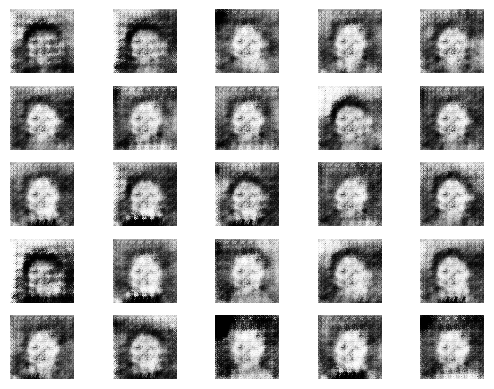

In [12]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, tamanio_codificacion))
gen_imgs = generador.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(gen_imgs[i * 5 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
plt.show()

--------
### **Reflexión**

Reflexione sobre lo aprendido en la sesión teórica y cómo se aplicó en el laboratorio. Algunos 
puntos que podrían considerar en su reflexión incluyen:

1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?

En este laboratorio, se usó diferentes técnicas, redes neuronales, y herramientas conocidas para poder crear un GAN (Generative Adversarial Network). Sin embargo, durante la elaboración del mismo encontramos ciertos aspectos de la teoría que fueron confusos o desafiantes. 

Por ejemplo, en clase aprendimos que el generador (durante su entrenamiento) nunca llega a ver las imágenes reales. Sin embargo, a la hora de realizar el código fue un poco confuso y desafiante terminar de comprender cómo el generador aprendía si nunca miraba las imágenes. Esto principalmente debido a que cuando aprendimos sobre CNNs, siempre le pasábamos las imágenes reales para que pudiera detectar los patrones presentes. En este caso, para terminar de comprender tuvimos que revisar los ejemplos colocados en Canvas para observar cómo se realiza el proceso de entrenamiento y confirmar que si se pueden obtener buenos resultados con este método. 

Otro aspecto desafiante de la teoría era el colapso de modo. Como se aprendió en clase, las GAN tienen una desventaja de que el generador produce unas pocas imágenes con las cuales puede “tontear” al discriminador. Esto causa que el generador solo produzca imágenes similares a esta. En clase se indicó que utilizar Deep Convolutional GANs puede resolver dicho problema. Sin embargo, nosotros implementamos este tipo de red neuronal y creemos que no terminó de solucionar el problema. Como resultado, sí encontramos este aspecto un poco confuso y frustrante. Esto especialmente considerando el tiempo que se tardaba el modelo para entrenar (más de 2 horas, ya que se usó todas las imágenes).


2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?
Como se mencionó anteriormente, el proceso de entrenamiento de las GAN es completamente diferente a como hemos entrenado redes neuronales en el pasado. Este laboratorio nos ayudó a terminar de comprender la teoría y porque se entrena el modelo por pasos; primero el discriminador y luego el generador. Asimismo, nos obligó a revisar ejemplos y más recursos para poder crear un modelo propio capaz de generar nuevos rostros.


3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?


Considerando algunos de los ejemplos vistos en clase y el laboraotrios, consideramos que las GANSs pueden ser aplicados en una variedad de campos y sectores. Por ejemplo:

a. Industria del Entretenimiento: Las GANs pueden ser utilizadas para crear efectos visuales en películas o videojuegos. Estas redes pueden generar paisajes, personajes y escenas que parecen realistas, reduciendo los costos y tiempos de producción. 


b. Medicina: Las GANs pueden ser empleadas para generar imágenes médicas para entrenamiento o investigación. Por ejemplo, podrían generar resonancias magnéticas o radiografías de tumores para ampliar los datasets de entrenamiento. 

c. Agricultura: Mediante el uso de GANs se pueden simular diferentes escenarios climáticos y evaluar cómo afectarían a los cultivos, permitiendo a los agricultores prepararse de mejor manera.

d. Educación: Las GANs podrían ser utilizadas para crear material didáctico, como simulaciones o reconstrucciones históricas que ayuden a los estudiantes a comprender mejor ciertos conceptos o eventos


4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?

Considerando que las GANs tienen una gran capacidad para generar datos esto trae consigo varias limitaciones y preocupaciones éticas:

a. Creación de Contenido Falso: Una de las principales inquietudes con las GANs es su habilidad para crear deepfakes, que son representaciones falsas pero realistas de imágenes, audios o videos. 

b. Violación de Derechos de Autor: Las GANs pueden ser empleadas para replicar estilos de artistas o diseñadores, creando obras que, aunque generadas por máquinas, podrían infringir derechos de autor al imitar demasiado de cerca el trabajo original.

c. Uso Inadecuado en Publicidad y Marketing: Las empresas podrían utilizar GANs para crear imágenes de productos que no representan exactamente lo que se está vendiendo, llevando a la desinformación o a expectativas no realistas para los consumidores

d. Manipulación a Masas: Hay preocupaciones sobre cómo las imágenes generadas por GANs podrían ser utilizadas para manipular emociones o percepciones, especialmente en contextos publicitarios o políticos.

5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la  experiencia práctica?


Realmente fue algo frustrante utilizar las GANs las primeras veces pues a veces se necesitaba esperar mucho tiempo a que terminara un entrenamiento. Es por ello que es innegable que enfrentamos momentos de frustración, especialmente cuando el modelo no converge o cuando los resultados no son los esperados. Estos desafíos, sin embargo, nos enseñaron la importancia de la perseverancia, la paciencia y la adaptabilidad en el mundo de la ciencia de datos. No obstante, también fue bastante satisfactorio cuando ya obteníamos resultados favorables para nuestro modelo. Esta experiencia ha avivado nuestra curiosidad sobre las potenciales implementaciones de las GANs y otros modelos generativos. Sin embargo, después de trabajar directamente con estas herramientas y ver su potencial, también somos más conscientes de las implicaciones éticas y los posibles abusos. Esta conciencia nos motiva a ser más críticos y responsables en futuras implementaciones.